In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl


from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from textblob import Word
from textblob import TextBlob
from nltk import PorterStemmer

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.svm import SVC


from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling,margin_sampling,entropy_sampling

import en_core_web_sm
nlp = en_core_web_sm.load()

df = pd.read_pickle("../../dataset/final_dataset/sem_eval_train.pkl")
df_test1 = pd.read_pickle("../../dataset/final_dataset/sem_eval_test1.pkl")
df_test2 = pd.read_pickle("../../dataset/final_dataset/sem_eval_test2.pkl")
df_test3 = pd.read_pickle("../../dataset/final_dataset/sem_eval_test3.pkl")

In [5]:
class Supervised_learner():
    def __init__(self,X,Y,model,X_test,Y_test):
        self.X = X
        self.Y = Y
        self.model = model
        self.X_test = X_test
        self.Y_test = Y_test
        

    def learn(self):
        super_acc = []
        super_f1 = []
        model = self.model
        model.fit(self.X, self.Y)
        
        model_accuracy = model.score(self.X_test, self.Y_test)
        super_acc.append(model_accuracy)
        
        model_pred = model.predict(self.X_test)
        model_f1 = f1_score(self.Y_test,model_pred,average ="weighted",labels=np.unique(model_pred))
        super_f1.append(model_f1)
        return super_acc, super_f1

In [6]:
class Active_learner():
    def __init__(self,X,Y,model,data, percentage,query_method,X_test,y_test):
        self.X = X
        self.Y = Y
        self.short_df = data.copy()
        self.percent = percentage
        self.model = model
        self.query_method = query_method
        self.X_test = X_test
        self.y_test = y_test
        
    def learn(self):       
        # seeding
        classes = self.short_df['grades_round'].unique()
        seed_index = []
        for i in classes:
            seed_index.append(self.short_df['grades_round'][self.short_df['grades_round']==i].index[0])
        seed_index

        act_data = self.short_df.copy()
        accuracy_list = []
        f1_list = []

        # initialising
        train_idx = seed_index
        X_train = self.X[train_idx]
        y_train = self.Y[train_idx]

        # generating the pool
        X_pool = np.delete(self.X, train_idx, axis=0)
        y_pool = np.delete(self.Y, train_idx)

        act_data = act_data.drop(axis=0,index = train_idx)
        act_data.reset_index(drop = True,inplace=True)


        # initializing the active learner

        learner = ActiveLearner(
            estimator = self.model,
            X_training = X_train, y_training=y_train,
            query_strategy=self.query_method
        )

        # pool-based sampling
        n_queries = int(len(X)/(100/self.percent))
        for idx in range(n_queries):
            print(idx)
            query_idx, query_instance = learner.query(X_pool)   
            learner.teach(
                X=X_pool[query_idx].reshape(1, -1),
                y=y_pool[query_idx].reshape(1, )
            )

            # remove queried instance from pool
            X_pool = np.delete(X_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx)

            act_data = act_data.drop(axis=0,index = query_idx)
            act_data.reset_index(drop=True, inplace=True)

            accuracy_list.append(learner.score(self.X_test,self.y_test))
            print('Accuracy after query no. %d: %f' % (idx+1, learner.score(self.X_test,self.y_test)))

            model_pred = learner.predict(self.X_test)
            model_f1 = f1_score(self.y_test,model_pred,average='weighted',labels=np.unique(model_pred))
            f1_list.append(model_f1)
        return accuracy_list,f1_list

In [7]:
## Active learner
X = df[['length_ratio','aligned_score','aligned_score_demo','cos_similarity','cos_similarity_demo']]
X = np.array(X) 
Y = df['grades_round'].values


X_test1 = df_test1[['length_ratio','aligned_score','aligned_score_demo','cos_similarity','cos_similarity_demo']]
X_test1 = np.array(X_test1) 
Y_test1 = df_test1['grades_round'].values


X_test2 = df_test2[['length_ratio','aligned_score','aligned_score_demo','cos_similarity','cos_similarity_demo']]
X_test2 = np.array(X_test2) 
Y_test2 = df_test2['grades_round'].values

X_test3 = df_test3[['length_ratio','aligned_score','aligned_score_demo','cos_similarity','cos_similarity_demo']]
X_test3 = np.array(X_test3) 
Y_test3 = df_test3['grades_round'].values

test_X = [X_test1 , X_test2 , X_test3]
test_Y = [Y_test1 , Y_test2 , Y_test3]
Percent = 98

dict_accuracy_al ={}
f1_score_list = {}
for test_idx, (X_test, Y_test) in enumerate(zip(test_X, test_Y)):
    models = [RandomForestClassifier(n_estimators =100)]
    query_methods = [uncertainty_sampling]
    dict_accuracy_al[test_idx] = []
    f1_score_list[test_idx] = []
    
    print("******************************************************************************")
    ac = Active_learner(X,Y,models[0],df, Percent,query_methods[0],X_test,Y_test)
    accuracy_list,f1 = ac.learn()
    dict_accuracy_al[test_idx].append(accuracy_list)
    f1_score_list[test_idx].append(f1)

# pkl.dump( dict_accuracy_al, open( "../../results/dict_accuracy_al_semeval_"+str(Percent)+".pkl", "wb" ) )
# pkl.dump( f1_score_list, open( "../../results/f1_score_list_al_semeval_"+str(Percent)+".pkl", "wb" ) )


******************************************************************************
0
Accuracy after query no. 1: 0.177778
1
Accuracy after query no. 2: 0.159259
2
Accuracy after query no. 3: 0.137037
3
Accuracy after query no. 4: 0.248148
4
Accuracy after query no. 5: 0.325926
5
Accuracy after query no. 6: 0.240741
6
Accuracy after query no. 7: 0.192593
7
Accuracy after query no. 8: 0.290741
8
Accuracy after query no. 9: 0.270370
9
Accuracy after query no. 10: 0.283333
10
Accuracy after query no. 11: 0.303704
11
Accuracy after query no. 12: 0.388889
12
Accuracy after query no. 13: 0.418519
13
Accuracy after query no. 14: 0.329630
14
Accuracy after query no. 15: 0.409259
15
Accuracy after query no. 16: 0.420370
16
Accuracy after query no. 17: 0.390741
17
Accuracy after query no. 18: 0.390741
18
Accuracy after query no. 19: 0.342593
19
Accuracy after query no. 20: 0.351852
20
Accuracy after query no. 21: 0.359259
21
Accuracy after query no. 22: 0.325926
22
Accuracy after query no. 23: 0.3611

Accuracy after query no. 195: 0.403704
195
Accuracy after query no. 196: 0.407407
196
Accuracy after query no. 197: 0.411111
197
Accuracy after query no. 198: 0.411111
198
Accuracy after query no. 199: 0.418519
199
Accuracy after query no. 200: 0.420370
200
Accuracy after query no. 201: 0.418519
201
Accuracy after query no. 202: 0.416667
202
Accuracy after query no. 203: 0.412963
203
Accuracy after query no. 204: 0.429630
204
Accuracy after query no. 205: 0.409259
205
Accuracy after query no. 206: 0.412963
206
Accuracy after query no. 207: 0.435185
207
Accuracy after query no. 208: 0.427778
208
Accuracy after query no. 209: 0.405556
209
Accuracy after query no. 210: 0.424074
210
Accuracy after query no. 211: 0.420370
211
Accuracy after query no. 212: 0.435185
212
Accuracy after query no. 213: 0.403704
213
Accuracy after query no. 214: 0.405556
214
Accuracy after query no. 215: 0.409259
215
Accuracy after query no. 216: 0.427778
216
Accuracy after query no. 217: 0.429630
217
Accuracy af

Accuracy after query no. 386: 0.472222
386
Accuracy after query no. 387: 0.487037
387
Accuracy after query no. 388: 0.470370
388
Accuracy after query no. 389: 0.470370
389
Accuracy after query no. 390: 0.442593
390
Accuracy after query no. 391: 0.477778
391
Accuracy after query no. 392: 0.462963
392
Accuracy after query no. 393: 0.477778
393
Accuracy after query no. 394: 0.462963
394
Accuracy after query no. 395: 0.466667
395
Accuracy after query no. 396: 0.457407
396
Accuracy after query no. 397: 0.477778
397
Accuracy after query no. 398: 0.468519
398
Accuracy after query no. 399: 0.470370
399
Accuracy after query no. 400: 0.485185
400
Accuracy after query no. 401: 0.468519
401
Accuracy after query no. 402: 0.462963
402
Accuracy after query no. 403: 0.470370
403
Accuracy after query no. 404: 0.470370
404
Accuracy after query no. 405: 0.479630
405
Accuracy after query no. 406: 0.485185
406
Accuracy after query no. 407: 0.474074
407
Accuracy after query no. 408: 0.481481
408
Accuracy af

Accuracy after query no. 577: 0.494444
577
Accuracy after query no. 578: 0.492593
578
Accuracy after query no. 579: 0.498148
579
Accuracy after query no. 580: 0.505556
580
Accuracy after query no. 581: 0.488889
581
Accuracy after query no. 582: 0.507407
582
Accuracy after query no. 583: 0.505556
583
Accuracy after query no. 584: 0.505556
584
Accuracy after query no. 585: 0.500000
585
Accuracy after query no. 586: 0.505556
586
Accuracy after query no. 587: 0.501852
587
Accuracy after query no. 588: 0.503704
588
Accuracy after query no. 589: 0.500000
589
Accuracy after query no. 590: 0.503704
590
Accuracy after query no. 591: 0.505556
591
Accuracy after query no. 592: 0.494444
592
Accuracy after query no. 593: 0.511111
593
Accuracy after query no. 594: 0.507407
594
Accuracy after query no. 595: 0.507407
595
Accuracy after query no. 596: 0.514815
596
Accuracy after query no. 597: 0.500000
597
Accuracy after query no. 598: 0.516667
598
Accuracy after query no. 599: 0.511111
599
Accuracy af

Accuracy after query no. 768: 0.496296
768
Accuracy after query no. 769: 0.512963
769
Accuracy after query no. 770: 0.496296
770
Accuracy after query no. 771: 0.500000
771
Accuracy after query no. 772: 0.509259
772
Accuracy after query no. 773: 0.488889
773
Accuracy after query no. 774: 0.490741
774
Accuracy after query no. 775: 0.500000
775
Accuracy after query no. 776: 0.492593
776
Accuracy after query no. 777: 0.492593
777
Accuracy after query no. 778: 0.498148
778
Accuracy after query no. 779: 0.487037
779
Accuracy after query no. 780: 0.505556
780
Accuracy after query no. 781: 0.498148
781
Accuracy after query no. 782: 0.505556
782
Accuracy after query no. 783: 0.505556
783
Accuracy after query no. 784: 0.507407
784
Accuracy after query no. 785: 0.500000
785
Accuracy after query no. 786: 0.490741
786
Accuracy after query no. 787: 0.507407
787
Accuracy after query no. 788: 0.496296
788
Accuracy after query no. 789: 0.503704
789
Accuracy after query no. 790: 0.500000
790
Accuracy af

Accuracy after query no. 959: 0.505556
959
Accuracy after query no. 960: 0.503704
960
Accuracy after query no. 961: 0.507407
961
Accuracy after query no. 962: 0.500000
962
Accuracy after query no. 963: 0.503704
963
Accuracy after query no. 964: 0.501852
964
Accuracy after query no. 965: 0.507407
965
Accuracy after query no. 966: 0.500000
966
Accuracy after query no. 967: 0.488889
967
Accuracy after query no. 968: 0.488889
968
Accuracy after query no. 969: 0.500000
969
Accuracy after query no. 970: 0.494444
970
Accuracy after query no. 971: 0.501852
971
Accuracy after query no. 972: 0.496296
972
Accuracy after query no. 973: 0.503704
973
Accuracy after query no. 974: 0.503704
974
Accuracy after query no. 975: 0.507407
975
Accuracy after query no. 976: 0.503704
976
Accuracy after query no. 977: 0.503704
977
Accuracy after query no. 978: 0.496296
978
Accuracy after query no. 979: 0.490741
979
Accuracy after query no. 980: 0.500000
980
Accuracy after query no. 981: 0.503704
981
Accuracy af

Accuracy after query no. 1143: 0.500000
1143
Accuracy after query no. 1144: 0.501852
1144
Accuracy after query no. 1145: 0.514815
1145
Accuracy after query no. 1146: 0.522222
1146
Accuracy after query no. 1147: 0.501852
1147
Accuracy after query no. 1148: 0.500000
1148
Accuracy after query no. 1149: 0.490741
1149
Accuracy after query no. 1150: 0.496296
1150
Accuracy after query no. 1151: 0.496296
1151
Accuracy after query no. 1152: 0.507407
1152
Accuracy after query no. 1153: 0.496296
1153
Accuracy after query no. 1154: 0.501852
1154
Accuracy after query no. 1155: 0.492593
1155
Accuracy after query no. 1156: 0.507407
1156
Accuracy after query no. 1157: 0.505556
1157
Accuracy after query no. 1158: 0.501852
1158
Accuracy after query no. 1159: 0.511111
1159
Accuracy after query no. 1160: 0.514815
1160
Accuracy after query no. 1161: 0.514815
1161
Accuracy after query no. 1162: 0.507407
1162
Accuracy after query no. 1163: 0.509259
1163
Accuracy after query no. 1164: 0.505556
1164
Accuracy a

Accuracy after query no. 1326: 0.509259
1326
Accuracy after query no. 1327: 0.503704
1327
Accuracy after query no. 1328: 0.514815
1328
Accuracy after query no. 1329: 0.511111
1329
Accuracy after query no. 1330: 0.516667
1330
Accuracy after query no. 1331: 0.516667
1331
Accuracy after query no. 1332: 0.518519
1332
Accuracy after query no. 1333: 0.500000
1333
Accuracy after query no. 1334: 0.524074
1334
Accuracy after query no. 1335: 0.501852
1335
Accuracy after query no. 1336: 0.516667
1336
Accuracy after query no. 1337: 0.505556
1337
Accuracy after query no. 1338: 0.516667
1338
Accuracy after query no. 1339: 0.509259
1339
Accuracy after query no. 1340: 0.514815
1340
Accuracy after query no. 1341: 0.514815
1341
Accuracy after query no. 1342: 0.512963
1342
Accuracy after query no. 1343: 0.509259
1343
Accuracy after query no. 1344: 0.507407
1344
Accuracy after query no. 1345: 0.509259
1345
Accuracy after query no. 1346: 0.507407
1346
Accuracy after query no. 1347: 0.516667
1347
Accuracy a

Accuracy after query no. 1509: 0.518519
1509
Accuracy after query no. 1510: 0.507407
1510
Accuracy after query no. 1511: 0.503704
1511
Accuracy after query no. 1512: 0.511111
1512
Accuracy after query no. 1513: 0.524074
1513
Accuracy after query no. 1514: 0.498148
1514
Accuracy after query no. 1515: 0.503704
1515
Accuracy after query no. 1516: 0.501852
1516
Accuracy after query no. 1517: 0.509259
1517
Accuracy after query no. 1518: 0.522222
1518
Accuracy after query no. 1519: 0.509259
1519
Accuracy after query no. 1520: 0.509259
1520
Accuracy after query no. 1521: 0.505556
1521
Accuracy after query no. 1522: 0.500000
1522
Accuracy after query no. 1523: 0.512963
1523
Accuracy after query no. 1524: 0.511111
1524
Accuracy after query no. 1525: 0.511111
1525
Accuracy after query no. 1526: 0.514815
1526
Accuracy after query no. 1527: 0.512963
1527
Accuracy after query no. 1528: 0.509259
1528
Accuracy after query no. 1529: 0.518519
1529
Accuracy after query no. 1530: 0.505556
1530
Accuracy a

Accuracy after query no. 1692: 0.518519
1692
Accuracy after query no. 1693: 0.516667
1693
Accuracy after query no. 1694: 0.509259
1694
Accuracy after query no. 1695: 0.520370
1695
Accuracy after query no. 1696: 0.509259
1696
Accuracy after query no. 1697: 0.507407
1697
Accuracy after query no. 1698: 0.496296
1698
Accuracy after query no. 1699: 0.509259
1699
Accuracy after query no. 1700: 0.518519
1700
Accuracy after query no. 1701: 0.520370
1701
Accuracy after query no. 1702: 0.503704
1702
Accuracy after query no. 1703: 0.503704
1703
Accuracy after query no. 1704: 0.501852
1704
Accuracy after query no. 1705: 0.522222
1705
Accuracy after query no. 1706: 0.514815
1706
Accuracy after query no. 1707: 0.511111
1707
Accuracy after query no. 1708: 0.518519
1708
Accuracy after query no. 1709: 0.516667
1709
Accuracy after query no. 1710: 0.490741
1710
Accuracy after query no. 1711: 0.509259
1711
Accuracy after query no. 1712: 0.505556
1712
Accuracy after query no. 1713: 0.514815
1713
Accuracy a

Accuracy after query no. 1875: 0.524074
1875
Accuracy after query no. 1876: 0.505556
1876
Accuracy after query no. 1877: 0.514815
1877
Accuracy after query no. 1878: 0.524074
1878
Accuracy after query no. 1879: 0.507407
1879
Accuracy after query no. 1880: 0.518519
1880
Accuracy after query no. 1881: 0.520370
1881
Accuracy after query no. 1882: 0.507407
1882
Accuracy after query no. 1883: 0.518519
1883
Accuracy after query no. 1884: 0.525926
1884
Accuracy after query no. 1885: 0.522222
1885
Accuracy after query no. 1886: 0.507407
1886
Accuracy after query no. 1887: 0.522222
1887
Accuracy after query no. 1888: 0.505556
1888
Accuracy after query no. 1889: 0.514815
1889
Accuracy after query no. 1890: 0.511111
1890
Accuracy after query no. 1891: 0.509259
1891
Accuracy after query no. 1892: 0.516667
1892
Accuracy after query no. 1893: 0.514815
1893
Accuracy after query no. 1894: 0.512963
1894
Accuracy after query no. 1895: 0.496296
1895
Accuracy after query no. 1896: 0.518519
1896
Accuracy a

Accuracy after query no. 2058: 0.524074
2058
Accuracy after query no. 2059: 0.518519
2059
Accuracy after query no. 2060: 0.531481
2060
Accuracy after query no. 2061: 0.520370
2061
Accuracy after query no. 2062: 0.516667
2062
Accuracy after query no. 2063: 0.533333
2063
Accuracy after query no. 2064: 0.509259
2064
Accuracy after query no. 2065: 0.518519
2065
Accuracy after query no. 2066: 0.509259
2066
Accuracy after query no. 2067: 0.518519
2067
Accuracy after query no. 2068: 0.514815
2068
Accuracy after query no. 2069: 0.518519
2069
Accuracy after query no. 2070: 0.514815
2070
Accuracy after query no. 2071: 0.512963
2071
Accuracy after query no. 2072: 0.522222
2072
Accuracy after query no. 2073: 0.518519
2073
Accuracy after query no. 2074: 0.525926
2074
Accuracy after query no. 2075: 0.516667
2075
Accuracy after query no. 2076: 0.524074
2076
Accuracy after query no. 2077: 0.522222
2077
Accuracy after query no. 2078: 0.516667
2078
Accuracy after query no. 2079: 0.516667
2079
Accuracy a

Accuracy after query no. 2241: 0.518519
2241
Accuracy after query no. 2242: 0.522222
2242
Accuracy after query no. 2243: 0.529630
2243
Accuracy after query no. 2244: 0.522222
2244
Accuracy after query no. 2245: 0.520370
2245
Accuracy after query no. 2246: 0.531481
2246
Accuracy after query no. 2247: 0.537037
2247
Accuracy after query no. 2248: 0.524074
2248
Accuracy after query no. 2249: 0.527778
2249
Accuracy after query no. 2250: 0.525926
2250
Accuracy after query no. 2251: 0.525926
2251
Accuracy after query no. 2252: 0.524074
2252
Accuracy after query no. 2253: 0.531481
2253
Accuracy after query no. 2254: 0.512963
2254
Accuracy after query no. 2255: 0.522222
2255
Accuracy after query no. 2256: 0.527778
2256
Accuracy after query no. 2257: 0.512963
2257
Accuracy after query no. 2258: 0.527778
2258
Accuracy after query no. 2259: 0.512963
2259
Accuracy after query no. 2260: 0.531481
2260
Accuracy after query no. 2261: 0.538889
2261
Accuracy after query no. 2262: 0.535185
2262
Accuracy a

Accuracy after query no. 2424: 0.535185
2424
Accuracy after query no. 2425: 0.527778
2425
Accuracy after query no. 2426: 0.514815
2426
Accuracy after query no. 2427: 0.522222
2427
Accuracy after query no. 2428: 0.505556
2428
Accuracy after query no. 2429: 0.535185
2429
Accuracy after query no. 2430: 0.518519
2430
Accuracy after query no. 2431: 0.527778
2431
Accuracy after query no. 2432: 0.542593
2432
Accuracy after query no. 2433: 0.533333
2433
Accuracy after query no. 2434: 0.529630
2434
Accuracy after query no. 2435: 0.511111
2435
Accuracy after query no. 2436: 0.531481
2436
Accuracy after query no. 2437: 0.522222
2437
Accuracy after query no. 2438: 0.524074
2438
Accuracy after query no. 2439: 0.520370
2439
Accuracy after query no. 2440: 0.533333
2440
Accuracy after query no. 2441: 0.522222
2441
Accuracy after query no. 2442: 0.524074
2442
Accuracy after query no. 2443: 0.507407
2443
Accuracy after query no. 2444: 0.535185
2444
Accuracy after query no. 2445: 0.524074
2445
Accuracy a

Accuracy after query no. 2607: 0.512963
2607
Accuracy after query no. 2608: 0.522222
2608
Accuracy after query no. 2609: 0.520370
2609
Accuracy after query no. 2610: 0.533333
2610
Accuracy after query no. 2611: 0.520370
2611
Accuracy after query no. 2612: 0.520370
2612
Accuracy after query no. 2613: 0.522222
2613
Accuracy after query no. 2614: 0.518519
2614
Accuracy after query no. 2615: 0.518519
2615
Accuracy after query no. 2616: 0.520370
2616
Accuracy after query no. 2617: 0.520370
2617
Accuracy after query no. 2618: 0.507407
2618
Accuracy after query no. 2619: 0.533333
2619
Accuracy after query no. 2620: 0.514815
2620
Accuracy after query no. 2621: 0.527778
2621
Accuracy after query no. 2622: 0.527778
2622
Accuracy after query no. 2623: 0.518519
2623
Accuracy after query no. 2624: 0.546296
2624
Accuracy after query no. 2625: 0.520370
2625
Accuracy after query no. 2626: 0.518519
2626
Accuracy after query no. 2627: 0.520370
2627
Accuracy after query no. 2628: 0.522222
2628
Accuracy a

Accuracy after query no. 2790: 0.527778
2790
Accuracy after query no. 2791: 0.518519
2791
Accuracy after query no. 2792: 0.507407
2792
Accuracy after query no. 2793: 0.525926
2793
Accuracy after query no. 2794: 0.527778
2794
Accuracy after query no. 2795: 0.525926
2795
Accuracy after query no. 2796: 0.524074
2796
Accuracy after query no. 2797: 0.522222
2797
Accuracy after query no. 2798: 0.512963
2798
Accuracy after query no. 2799: 0.509259
2799
Accuracy after query no. 2800: 0.518519
2800
Accuracy after query no. 2801: 0.522222
2801
Accuracy after query no. 2802: 0.527778
2802
Accuracy after query no. 2803: 0.516667
2803
Accuracy after query no. 2804: 0.505556
2804
Accuracy after query no. 2805: 0.535185
2805
Accuracy after query no. 2806: 0.520370
2806
Accuracy after query no. 2807: 0.533333
2807
Accuracy after query no. 2808: 0.520370
2808
Accuracy after query no. 2809: 0.516667
2809
Accuracy after query no. 2810: 0.524074
2810
Accuracy after query no. 2811: 0.537037
2811
Accuracy a

Accuracy after query no. 2973: 0.529630
2973
Accuracy after query no. 2974: 0.535185
2974
Accuracy after query no. 2975: 0.525926
2975
Accuracy after query no. 2976: 0.529630
2976
Accuracy after query no. 2977: 0.533333
2977
Accuracy after query no. 2978: 0.527778
2978
Accuracy after query no. 2979: 0.531481
2979
Accuracy after query no. 2980: 0.537037
2980
Accuracy after query no. 2981: 0.518519
2981
Accuracy after query no. 2982: 0.529630
2982
Accuracy after query no. 2983: 0.538889
2983
Accuracy after query no. 2984: 0.520370
2984
Accuracy after query no. 2985: 0.511111
2985
Accuracy after query no. 2986: 0.529630
2986
Accuracy after query no. 2987: 0.520370
2987
Accuracy after query no. 2988: 0.524074
2988
Accuracy after query no. 2989: 0.537037
2989
Accuracy after query no. 2990: 0.511111
2990
Accuracy after query no. 2991: 0.533333
2991
Accuracy after query no. 2992: 0.529630
2992
Accuracy after query no. 2993: 0.537037
2993
Accuracy after query no. 2994: 0.512963
2994
Accuracy a

Accuracy after query no. 3156: 0.540741
3156
Accuracy after query no. 3157: 0.518519
3157
Accuracy after query no. 3158: 0.529630
3158
Accuracy after query no. 3159: 0.537037
3159
Accuracy after query no. 3160: 0.537037
3160
Accuracy after query no. 3161: 0.511111
3161
Accuracy after query no. 3162: 0.525926
3162
Accuracy after query no. 3163: 0.537037
3163
Accuracy after query no. 3164: 0.529630
3164
Accuracy after query no. 3165: 0.509259
3165
Accuracy after query no. 3166: 0.533333
3166
Accuracy after query no. 3167: 0.525926
3167
Accuracy after query no. 3168: 0.520370
3168
Accuracy after query no. 3169: 0.509259
3169
Accuracy after query no. 3170: 0.524074
3170
Accuracy after query no. 3171: 0.520370
3171
Accuracy after query no. 3172: 0.522222
3172
Accuracy after query no. 3173: 0.516667
3173
Accuracy after query no. 3174: 0.520370
3174
Accuracy after query no. 3175: 0.525926
3175
Accuracy after query no. 3176: 0.524074
3176
Accuracy after query no. 3177: 0.525926
3177
Accuracy a

Accuracy after query no. 3339: 0.520370
3339
Accuracy after query no. 3340: 0.537037
3340
Accuracy after query no. 3341: 0.512963
3341
Accuracy after query no. 3342: 0.522222
3342
Accuracy after query no. 3343: 0.524074
3343
Accuracy after query no. 3344: 0.525926
3344
Accuracy after query no. 3345: 0.529630
3345
Accuracy after query no. 3346: 0.520370
3346
Accuracy after query no. 3347: 0.537037
3347
Accuracy after query no. 3348: 0.524074
3348
Accuracy after query no. 3349: 0.531481
3349
Accuracy after query no. 3350: 0.525926
3350
Accuracy after query no. 3351: 0.520370
3351
Accuracy after query no. 3352: 0.516667
3352
Accuracy after query no. 3353: 0.529630
3353
Accuracy after query no. 3354: 0.524074
3354
Accuracy after query no. 3355: 0.531481
3355
Accuracy after query no. 3356: 0.525926
3356
Accuracy after query no. 3357: 0.522222
3357
Accuracy after query no. 3358: 0.531481
3358
Accuracy after query no. 3359: 0.531481
3359
Accuracy after query no. 3360: 0.520370
3360
Accuracy a

Accuracy after query no. 3522: 0.518519
3522
Accuracy after query no. 3523: 0.520370
3523
Accuracy after query no. 3524: 0.524074
3524
Accuracy after query no. 3525: 0.527778
3525
Accuracy after query no. 3526: 0.525926
3526
Accuracy after query no. 3527: 0.538889
3527
Accuracy after query no. 3528: 0.516667
3528
Accuracy after query no. 3529: 0.518519
3529
Accuracy after query no. 3530: 0.525926
3530
Accuracy after query no. 3531: 0.516667
3531
Accuracy after query no. 3532: 0.531481
3532
Accuracy after query no. 3533: 0.520370
3533
Accuracy after query no. 3534: 0.522222
3534
Accuracy after query no. 3535: 0.512963
3535
Accuracy after query no. 3536: 0.520370
3536
Accuracy after query no. 3537: 0.531481
3537
Accuracy after query no. 3538: 0.535185
3538
Accuracy after query no. 3539: 0.514815
3539
Accuracy after query no. 3540: 0.531481
3540
Accuracy after query no. 3541: 0.520370
3541
Accuracy after query no. 3542: 0.531481
3542
Accuracy after query no. 3543: 0.520370
3543
Accuracy a

Accuracy after query no. 3705: 0.512963
3705
Accuracy after query no. 3706: 0.507407
3706
Accuracy after query no. 3707: 0.524074
3707
Accuracy after query no. 3708: 0.514815
3708
Accuracy after query no. 3709: 0.516667
3709
Accuracy after query no. 3710: 0.529630
3710
Accuracy after query no. 3711: 0.520370
3711
Accuracy after query no. 3712: 0.522222
3712
Accuracy after query no. 3713: 0.514815
3713
Accuracy after query no. 3714: 0.514815
3714
Accuracy after query no. 3715: 0.518519
3715
Accuracy after query no. 3716: 0.524074
3716
Accuracy after query no. 3717: 0.537037
3717
Accuracy after query no. 3718: 0.494444
3718
Accuracy after query no. 3719: 0.518519
3719
Accuracy after query no. 3720: 0.518519
3720
Accuracy after query no. 3721: 0.500000
3721
Accuracy after query no. 3722: 0.520370
3722
Accuracy after query no. 3723: 0.518519
3723
Accuracy after query no. 3724: 0.518519
3724
Accuracy after query no. 3725: 0.522222
3725
Accuracy after query no. 3726: 0.518519
3726
Accuracy a

Accuracy after query no. 3888: 0.509259
3888
Accuracy after query no. 3889: 0.514815
3889
Accuracy after query no. 3890: 0.524074
3890
Accuracy after query no. 3891: 0.512963
3891
Accuracy after query no. 3892: 0.522222
3892
Accuracy after query no. 3893: 0.525926
3893
Accuracy after query no. 3894: 0.512963
3894
Accuracy after query no. 3895: 0.518519
3895
Accuracy after query no. 3896: 0.527778
3896
Accuracy after query no. 3897: 0.512963
3897
Accuracy after query no. 3898: 0.524074
3898
Accuracy after query no. 3899: 0.507407
3899
Accuracy after query no. 3900: 0.503704
3900
Accuracy after query no. 3901: 0.518519
3901
Accuracy after query no. 3902: 0.509259
3902
Accuracy after query no. 3903: 0.518519
3903
Accuracy after query no. 3904: 0.512963
3904
Accuracy after query no. 3905: 0.522222
3905
Accuracy after query no. 3906: 0.520370
3906
Accuracy after query no. 3907: 0.520370
3907
Accuracy after query no. 3908: 0.514815
3908
Accuracy after query no. 3909: 0.514815
3909
Accuracy a

Accuracy after query no. 4071: 0.509259
4071
Accuracy after query no. 4072: 0.509259
4072
Accuracy after query no. 4073: 0.533333
4073
Accuracy after query no. 4074: 0.522222
4074
Accuracy after query no. 4075: 0.512963
4075
Accuracy after query no. 4076: 0.511111
4076
Accuracy after query no. 4077: 0.531481
4077
Accuracy after query no. 4078: 0.509259
4078
Accuracy after query no. 4079: 0.529630
4079
Accuracy after query no. 4080: 0.507407
4080
Accuracy after query no. 4081: 0.525926
4081
Accuracy after query no. 4082: 0.498148
4082
Accuracy after query no. 4083: 0.518519
4083
Accuracy after query no. 4084: 0.527778
4084
Accuracy after query no. 4085: 0.518519
4085
Accuracy after query no. 4086: 0.520370
4086
Accuracy after query no. 4087: 0.511111
4087
Accuracy after query no. 4088: 0.511111
4088
Accuracy after query no. 4089: 0.514815
4089
Accuracy after query no. 4090: 0.512963
4090
Accuracy after query no. 4091: 0.527778
4091
Accuracy after query no. 4092: 0.516667
4092
Accuracy a

Accuracy after query no. 4254: 0.518519
4254
Accuracy after query no. 4255: 0.524074
4255
Accuracy after query no. 4256: 0.512963
4256
Accuracy after query no. 4257: 0.511111
4257
Accuracy after query no. 4258: 0.522222
4258
Accuracy after query no. 4259: 0.518519
4259
Accuracy after query no. 4260: 0.525926
4260
Accuracy after query no. 4261: 0.522222
4261
Accuracy after query no. 4262: 0.503704
4262
Accuracy after query no. 4263: 0.505556
4263
Accuracy after query no. 4264: 0.524074
4264
Accuracy after query no. 4265: 0.527778
4265
Accuracy after query no. 4266: 0.514815
4266
Accuracy after query no. 4267: 0.516667
4267
Accuracy after query no. 4268: 0.511111
4268
Accuracy after query no. 4269: 0.525926
4269
Accuracy after query no. 4270: 0.516667
4270
Accuracy after query no. 4271: 0.500000
4271
Accuracy after query no. 4272: 0.524074
4272
Accuracy after query no. 4273: 0.522222
4273
Accuracy after query no. 4274: 0.509259
4274
Accuracy after query no. 4275: 0.509259
4275
Accuracy a

Accuracy after query no. 4437: 0.511111
4437
Accuracy after query no. 4438: 0.533333
4438
Accuracy after query no. 4439: 0.501852
4439
Accuracy after query no. 4440: 0.518519
4440
Accuracy after query no. 4441: 0.511111
4441
Accuracy after query no. 4442: 0.511111
4442
Accuracy after query no. 4443: 0.524074
4443
Accuracy after query no. 4444: 0.505556
4444
Accuracy after query no. 4445: 0.524074
4445
Accuracy after query no. 4446: 0.537037
4446
Accuracy after query no. 4447: 0.516667
4447
Accuracy after query no. 4448: 0.516667
4448
Accuracy after query no. 4449: 0.511111
4449
Accuracy after query no. 4450: 0.503704
4450
Accuracy after query no. 4451: 0.512963
4451
Accuracy after query no. 4452: 0.522222
4452
Accuracy after query no. 4453: 0.518519
4453
Accuracy after query no. 4454: 0.512963
4454
Accuracy after query no. 4455: 0.512963
4455
Accuracy after query no. 4456: 0.511111
4456
Accuracy after query no. 4457: 0.524074
4457
Accuracy after query no. 4458: 0.516667
4458
Accuracy a

Accuracy after query no. 4620: 0.511111
4620
Accuracy after query no. 4621: 0.518519
4621
Accuracy after query no. 4622: 0.505556
4622
Accuracy after query no. 4623: 0.514815
4623
Accuracy after query no. 4624: 0.527778
4624
Accuracy after query no. 4625: 0.509259
4625
Accuracy after query no. 4626: 0.503704
4626
Accuracy after query no. 4627: 0.518519
4627
Accuracy after query no. 4628: 0.518519
4628
Accuracy after query no. 4629: 0.512963
4629
Accuracy after query no. 4630: 0.518519
4630
Accuracy after query no. 4631: 0.514815
4631
Accuracy after query no. 4632: 0.509259
4632
Accuracy after query no. 4633: 0.507407
4633
Accuracy after query no. 4634: 0.509259
4634
Accuracy after query no. 4635: 0.507407
4635
Accuracy after query no. 4636: 0.518519
4636
Accuracy after query no. 4637: 0.512963
4637
Accuracy after query no. 4638: 0.516667
4638
Accuracy after query no. 4639: 0.512963
4639
Accuracy after query no. 4640: 0.514815
4640
Accuracy after query no. 4641: 0.525926
4641
Accuracy a

Accuracy after query no. 4803: 0.509259
4803
Accuracy after query no. 4804: 0.520370
4804
Accuracy after query no. 4805: 0.503704
4805
Accuracy after query no. 4806: 0.520370
4806
Accuracy after query no. 4807: 0.516667
4807
Accuracy after query no. 4808: 0.503704
4808
Accuracy after query no. 4809: 0.507407
4809
Accuracy after query no. 4810: 0.518519
4810
Accuracy after query no. 4811: 0.518519
4811
Accuracy after query no. 4812: 0.503704
4812
Accuracy after query no. 4813: 0.514815
4813
Accuracy after query no. 4814: 0.509259
4814
Accuracy after query no. 4815: 0.512963
4815
Accuracy after query no. 4816: 0.500000
4816
Accuracy after query no. 4817: 0.514815
4817
Accuracy after query no. 4818: 0.505556
4818
Accuracy after query no. 4819: 0.511111
4819
Accuracy after query no. 4820: 0.514815
4820
Accuracy after query no. 4821: 0.514815
4821
Accuracy after query no. 4822: 0.511111
4822
Accuracy after query no. 4823: 0.516667
4823
Accuracy after query no. 4824: 0.498148
4824
Accuracy a

Accuracy after query no. 125: 0.539676
125
Accuracy after query no. 126: 0.539676
126
Accuracy after query no. 127: 0.536826
127
Accuracy after query no. 128: 0.533757
128
Accuracy after query no. 129: 0.533100
129
Accuracy after query no. 130: 0.535730
130
Accuracy after query no. 131: 0.530250
131
Accuracy after query no. 132: 0.534415
132
Accuracy after query no. 133: 0.527619
133
Accuracy after query no. 134: 0.532661
134
Accuracy after query no. 135: 0.532661
135
Accuracy after query no. 136: 0.532004
136
Accuracy after query no. 137: 0.532004
137
Accuracy after query no. 138: 0.533976
138
Accuracy after query no. 139: 0.530250
139
Accuracy after query no. 140: 0.532442
140
Accuracy after query no. 141: 0.533976
141
Accuracy after query no. 142: 0.535949
142
Accuracy after query no. 143: 0.539456
143
Accuracy after query no. 144: 0.536388
144
Accuracy after query no. 145: 0.535949
145
Accuracy after query no. 146: 0.536826
146
Accuracy after query no. 147: 0.530031
147
Accuracy af

Accuracy after query no. 316: 0.535949
316
Accuracy after query no. 317: 0.536826
317
Accuracy after query no. 318: 0.536388
318
Accuracy after query no. 319: 0.537922
319
Accuracy after query no. 320: 0.533319
320
Accuracy after query no. 321: 0.540114
321
Accuracy after query no. 322: 0.538360
322
Accuracy after query no. 323: 0.540333
323
Accuracy after query no. 324: 0.537484
324
Accuracy after query no. 325: 0.530688
325
Accuracy after query no. 326: 0.540333
326
Accuracy after query no. 327: 0.536388
327
Accuracy after query no. 328: 0.536168
328
Accuracy after query no. 329: 0.539456
329
Accuracy after query no. 330: 0.531565
330
Accuracy after query no. 331: 0.532004
331
Accuracy after query no. 332: 0.543402
332
Accuracy after query no. 333: 0.537264
333
Accuracy after query no. 334: 0.541648
334
Accuracy after query no. 335: 0.543402
335
Accuracy after query no. 336: 0.540333
336
Accuracy after query no. 337: 0.542087
337
Accuracy after query no. 338: 0.543621
338
Accuracy af

Accuracy after query no. 507: 0.533976
507
Accuracy after query no. 508: 0.539018
508
Accuracy after query no. 509: 0.543183
509
Accuracy after query no. 510: 0.539237
510
Accuracy after query no. 511: 0.543621
511
Accuracy after query no. 512: 0.535730
512
Accuracy after query no. 513: 0.536388
513
Accuracy after query no. 514: 0.537264
514
Accuracy after query no. 515: 0.542087
515
Accuracy after query no. 516: 0.539676
516
Accuracy after query no. 517: 0.539237
517
Accuracy after query no. 518: 0.545156
518
Accuracy after query no. 519: 0.537264
519
Accuracy after query no. 520: 0.542306
520
Accuracy after query no. 521: 0.531127
521
Accuracy after query no. 522: 0.536388
522
Accuracy after query no. 523: 0.533319
523
Accuracy after query no. 524: 0.537922
524
Accuracy after query no. 525: 0.535511
525
Accuracy after query no. 526: 0.541210
526
Accuracy after query no. 527: 0.536388
527
Accuracy after query no. 528: 0.540772
528
Accuracy after query no. 529: 0.541429
529
Accuracy af

Accuracy after query no. 698: 0.528496
698
Accuracy after query no. 699: 0.533757
699
Accuracy after query no. 700: 0.533976
700
Accuracy after query no. 701: 0.532442
701
Accuracy after query no. 702: 0.532661
702
Accuracy after query no. 703: 0.539018
703
Accuracy after query no. 704: 0.535072
704
Accuracy after query no. 705: 0.531784
705
Accuracy after query no. 706: 0.533319
706
Accuracy after query no. 707: 0.528058
707
Accuracy after query no. 708: 0.532661
708
Accuracy after query no. 709: 0.529154
709
Accuracy after query no. 710: 0.539456
710
Accuracy after query no. 711: 0.530688
711
Accuracy after query no. 712: 0.532880
712
Accuracy after query no. 713: 0.527400
713
Accuracy after query no. 714: 0.535949
714
Accuracy after query no. 715: 0.530688
715
Accuracy after query no. 716: 0.533976
716
Accuracy after query no. 717: 0.529592
717
Accuracy after query no. 718: 0.532442
718
Accuracy after query no. 719: 0.528058
719
Accuracy after query no. 720: 0.530031
720
Accuracy af

Accuracy after query no. 889: 0.535072
889
Accuracy after query no. 890: 0.529811
890
Accuracy after query no. 891: 0.540991
891
Accuracy after query no. 892: 0.532442
892
Accuracy after query no. 893: 0.529373
893
Accuracy after query no. 894: 0.543621
894
Accuracy after query no. 895: 0.535949
895
Accuracy after query no. 896: 0.529811
896
Accuracy after query no. 897: 0.538799
897
Accuracy after query no. 898: 0.539456
898
Accuracy after query no. 899: 0.531346
899
Accuracy after query no. 900: 0.539237
900
Accuracy after query no. 901: 0.533100
901
Accuracy after query no. 902: 0.542087
902
Accuracy after query no. 903: 0.531127
903
Accuracy after query no. 904: 0.539456
904
Accuracy after query no. 905: 0.530250
905
Accuracy after query no. 906: 0.536826
906
Accuracy after query no. 907: 0.530250
907
Accuracy after query no. 908: 0.531127
908
Accuracy after query no. 909: 0.525427
909
Accuracy after query no. 910: 0.535072
910
Accuracy after query no. 911: 0.540333
911
Accuracy af

Accuracy after query no. 1076: 0.532442
1076
Accuracy after query no. 1077: 0.541429
1077
Accuracy after query no. 1078: 0.534415
1078
Accuracy after query no. 1079: 0.538141
1079
Accuracy after query no. 1080: 0.543183
1080
Accuracy after query no. 1081: 0.533319
1081
Accuracy after query no. 1082: 0.541429
1082
Accuracy after query no. 1083: 0.546909
1083
Accuracy after query no. 1084: 0.532442
1084
Accuracy after query no. 1085: 0.540333
1085
Accuracy after query no. 1086: 0.531784
1086
Accuracy after query no. 1087: 0.543402
1087
Accuracy after query no. 1088: 0.539895
1088
Accuracy after query no. 1089: 0.528496
1089
Accuracy after query no. 1090: 0.534634
1090
Accuracy after query no. 1091: 0.529373
1091
Accuracy after query no. 1092: 0.529592
1092
Accuracy after query no. 1093: 0.540114
1093
Accuracy after query no. 1094: 0.531346
1094
Accuracy after query no. 1095: 0.531346
1095
Accuracy after query no. 1096: 0.529811
1096
Accuracy after query no. 1097: 0.534196
1097
Accuracy a

Accuracy after query no. 1259: 0.532661
1259
Accuracy after query no. 1260: 0.538580
1260
Accuracy after query no. 1261: 0.534634
1261
Accuracy after query no. 1262: 0.535949
1262
Accuracy after query no. 1263: 0.539895
1263
Accuracy after query no. 1264: 0.535292
1264
Accuracy after query no. 1265: 0.541210
1265
Accuracy after query no. 1266: 0.534853
1266
Accuracy after query no. 1267: 0.526085
1267
Accuracy after query no. 1268: 0.530250
1268
Accuracy after query no. 1269: 0.526962
1269
Accuracy after query no. 1270: 0.538141
1270
Accuracy after query no. 1271: 0.529154
1271
Accuracy after query no. 1272: 0.536607
1272
Accuracy after query no. 1273: 0.543183
1273
Accuracy after query no. 1274: 0.524551
1274
Accuracy after query no. 1275: 0.536607
1275
Accuracy after query no. 1276: 0.537264
1276
Accuracy after query no. 1277: 0.527619
1277
Accuracy after query no. 1278: 0.542087
1278
Accuracy after query no. 1279: 0.533976
1279
Accuracy after query no. 1280: 0.535511
1280
Accuracy a

Accuracy after query no. 1442: 0.539895
1442
Accuracy after query no. 1443: 0.539676
1443
Accuracy after query no. 1444: 0.539676
1444
Accuracy after query no. 1445: 0.539676
1445
Accuracy after query no. 1446: 0.538360
1446
Accuracy after query no. 1447: 0.539676
1447
Accuracy after query no. 1448: 0.536826
1448
Accuracy after query no. 1449: 0.544060
1449
Accuracy after query no. 1450: 0.540772
1450
Accuracy after query no. 1451: 0.545156
1451
Accuracy after query no. 1452: 0.536607
1452
Accuracy after query no. 1453: 0.539456
1453
Accuracy after query no. 1454: 0.541868
1454
Accuracy after query no. 1455: 0.541868
1455
Accuracy after query no. 1456: 0.530031
1456
Accuracy after query no. 1457: 0.539018
1457
Accuracy after query no. 1458: 0.535511
1458
Accuracy after query no. 1459: 0.542964
1459
Accuracy after query no. 1460: 0.540552
1460
Accuracy after query no. 1461: 0.533100
1461
Accuracy after query no. 1462: 0.538580
1462
Accuracy after query no. 1463: 0.542306
1463
Accuracy a

Accuracy after query no. 1625: 0.530907
1625
Accuracy after query no. 1626: 0.544060
1626
Accuracy after query no. 1627: 0.539018
1627
Accuracy after query no. 1628: 0.542525
1628
Accuracy after query no. 1629: 0.528496
1629
Accuracy after query no. 1630: 0.532442
1630
Accuracy after query no. 1631: 0.538580
1631
Accuracy after query no. 1632: 0.538141
1632
Accuracy after query no. 1633: 0.534853
1633
Accuracy after query no. 1634: 0.530250
1634
Accuracy after query no. 1635: 0.535072
1635
Accuracy after query no. 1636: 0.527181
1636
Accuracy after query no. 1637: 0.540114
1637
Accuracy after query no. 1638: 0.526962
1638
Accuracy after query no. 1639: 0.533319
1639
Accuracy after query no. 1640: 0.529592
1640
Accuracy after query no. 1641: 0.534853
1641
Accuracy after query no. 1642: 0.528715
1642
Accuracy after query no. 1643: 0.536168
1643
Accuracy after query no. 1644: 0.529373
1644
Accuracy after query no. 1645: 0.541648
1645
Accuracy after query no. 1646: 0.537484
1646
Accuracy a

Accuracy after query no. 1808: 0.526743
1808
Accuracy after query no. 1809: 0.533757
1809
Accuracy after query no. 1810: 0.523893
1810
Accuracy after query no. 1811: 0.523674
1811
Accuracy after query no. 1812: 0.533976
1812
Accuracy after query no. 1813: 0.528715
1813
Accuracy after query no. 1814: 0.524770
1814
Accuracy after query no. 1815: 0.525866
1815
Accuracy after query no. 1816: 0.521263
1816
Accuracy after query no. 1817: 0.526085
1817
Accuracy after query no. 1818: 0.532880
1818
Accuracy after query no. 1819: 0.530031
1819
Accuracy after query no. 1820: 0.523016
1820
Accuracy after query no. 1821: 0.528715
1821
Accuracy after query no. 1822: 0.513371
1822
Accuracy after query no. 1823: 0.528496
1823
Accuracy after query no. 1824: 0.532661
1824
Accuracy after query no. 1825: 0.519728
1825
Accuracy after query no. 1826: 0.523893
1826
Accuracy after query no. 1827: 0.515344
1827
Accuracy after query no. 1828: 0.530250
1828
Accuracy after query no. 1829: 0.520386
1829
Accuracy a

Accuracy after query no. 1991: 0.507014
1991
Accuracy after query no. 1992: 0.526743
1992
Accuracy after query no. 1993: 0.534415
1993
Accuracy after query no. 1994: 0.525208
1994
Accuracy after query no. 1995: 0.524989
1995
Accuracy after query no. 1996: 0.526085
1996
Accuracy after query no. 1997: 0.517536
1997
Accuracy after query no. 1998: 0.518413
1998
Accuracy after query no. 1999: 0.521263
1999
Accuracy after query no. 2000: 0.526085
2000
Accuracy after query no. 2001: 0.517536
2001
Accuracy after query no. 2002: 0.523674
2002
Accuracy after query no. 2003: 0.526304
2003
Accuracy after query no. 2004: 0.520824
2004
Accuracy after query no. 2005: 0.521263
2005
Accuracy after query no. 2006: 0.520824
2006
Accuracy after query no. 2007: 0.515783
2007
Accuracy after query no. 2008: 0.522578
2008
Accuracy after query no. 2009: 0.527839
2009
Accuracy after query no. 2010: 0.518194
2010
Accuracy after query no. 2011: 0.520167
2011
Accuracy after query no. 2012: 0.533976
2012
Accuracy a

Accuracy after query no. 2174: 0.515344
2174
Accuracy after query no. 2175: 0.524989
2175
Accuracy after query no. 2176: 0.513810
2176
Accuracy after query no. 2177: 0.522139
2177
Accuracy after query no. 2178: 0.524989
2178
Accuracy after query no. 2179: 0.536826
2179
Accuracy after query no. 2180: 0.527839
2180
Accuracy after query no. 2181: 0.532223
2181
Accuracy after query no. 2182: 0.526304
2182
Accuracy after query no. 2183: 0.527619
2183
Accuracy after query no. 2184: 0.530031
2184
Accuracy after query no. 2185: 0.531346
2185
Accuracy after query no. 2186: 0.527400
2186
Accuracy after query no. 2187: 0.519947
2187
Accuracy after query no. 2188: 0.530469
2188
Accuracy after query no. 2189: 0.524112
2189
Accuracy after query no. 2190: 0.529154
2190
Accuracy after query no. 2191: 0.527839
2191
Accuracy after query no. 2192: 0.526304
2192
Accuracy after query no. 2193: 0.529154
2193
Accuracy after query no. 2194: 0.532880
2194
Accuracy after query no. 2195: 0.526085
2195
Accuracy a

Accuracy after query no. 2357: 0.526304
2357
Accuracy after query no. 2358: 0.521701
2358
Accuracy after query no. 2359: 0.524112
2359
Accuracy after query no. 2360: 0.514029
2360
Accuracy after query no. 2361: 0.523455
2361
Accuracy after query no. 2362: 0.531565
2362
Accuracy after query no. 2363: 0.521920
2363
Accuracy after query no. 2364: 0.531127
2364
Accuracy after query no. 2365: 0.530031
2365
Accuracy after query no. 2366: 0.525427
2366
Accuracy after query no. 2367: 0.522797
2367
Accuracy after query no. 2368: 0.528496
2368
Accuracy after query no. 2369: 0.528715
2369
Accuracy after query no. 2370: 0.537703
2370
Accuracy after query no. 2371: 0.531565
2371
Accuracy after query no. 2372: 0.520605
2372
Accuracy after query no. 2373: 0.522139
2373
Accuracy after query no. 2374: 0.525427
2374
Accuracy after query no. 2375: 0.525427
2375
Accuracy after query no. 2376: 0.526523
2376
Accuracy after query no. 2377: 0.530907
2377
Accuracy after query no. 2378: 0.526085
2378
Accuracy a

Accuracy after query no. 2540: 0.542744
2540
Accuracy after query no. 2541: 0.536607
2541
Accuracy after query no. 2542: 0.543402
2542
Accuracy after query no. 2543: 0.537045
2543
Accuracy after query no. 2544: 0.538360
2544
Accuracy after query no. 2545: 0.537922
2545
Accuracy after query no. 2546: 0.539456
2546
Accuracy after query no. 2547: 0.530688
2547
Accuracy after query no. 2548: 0.533100
2548
Accuracy after query no. 2549: 0.534415
2549
Accuracy after query no. 2550: 0.531565
2550
Accuracy after query no. 2551: 0.535072
2551
Accuracy after query no. 2552: 0.535292
2552
Accuracy after query no. 2553: 0.536168
2553
Accuracy after query no. 2554: 0.540333
2554
Accuracy after query no. 2555: 0.535072
2555
Accuracy after query no. 2556: 0.540114
2556
Accuracy after query no. 2557: 0.538799
2557
Accuracy after query no. 2558: 0.538580
2558
Accuracy after query no. 2559: 0.540991
2559
Accuracy after query no. 2560: 0.535511
2560
Accuracy after query no. 2561: 0.538141
2561
Accuracy a

Accuracy after query no. 2723: 0.537264
2723
Accuracy after query no. 2724: 0.536826
2724
Accuracy after query no. 2725: 0.538799
2725
Accuracy after query no. 2726: 0.534415
2726
Accuracy after query no. 2727: 0.542964
2727
Accuracy after query no. 2728: 0.534853
2728
Accuracy after query no. 2729: 0.541429
2729
Accuracy after query no. 2730: 0.535730
2730
Accuracy after query no. 2731: 0.536388
2731
Accuracy after query no. 2732: 0.539237
2732
Accuracy after query no. 2733: 0.546690
2733
Accuracy after query no. 2734: 0.538141
2734
Accuracy after query no. 2735: 0.544279
2735
Accuracy after query no. 2736: 0.535292
2736
Accuracy after query no. 2737: 0.535949
2737
Accuracy after query no. 2738: 0.533757
2738
Accuracy after query no. 2739: 0.539676
2739
Accuracy after query no. 2740: 0.534415
2740
Accuracy after query no. 2741: 0.536826
2741
Accuracy after query no. 2742: 0.534634
2742
Accuracy after query no. 2743: 0.535949
2743
Accuracy after query no. 2744: 0.540114
2744
Accuracy a

Accuracy after query no. 2906: 0.537264
2906
Accuracy after query no. 2907: 0.531346
2907
Accuracy after query no. 2908: 0.539895
2908
Accuracy after query no. 2909: 0.537922
2909
Accuracy after query no. 2910: 0.539895
2910
Accuracy after query no. 2911: 0.537045
2911
Accuracy after query no. 2912: 0.535292
2912
Accuracy after query no. 2913: 0.534415
2913
Accuracy after query no. 2914: 0.534196
2914
Accuracy after query no. 2915: 0.541429
2915
Accuracy after query no. 2916: 0.542087
2916
Accuracy after query no. 2917: 0.542525
2917
Accuracy after query no. 2918: 0.544717
2918
Accuracy after query no. 2919: 0.539676
2919
Accuracy after query no. 2920: 0.535292
2920
Accuracy after query no. 2921: 0.532223
2921
Accuracy after query no. 2922: 0.537264
2922
Accuracy after query no. 2923: 0.536607
2923
Accuracy after query no. 2924: 0.538360
2924
Accuracy after query no. 2925: 0.541648
2925
Accuracy after query no. 2926: 0.539018
2926
Accuracy after query no. 2927: 0.537703
2927
Accuracy a

Accuracy after query no. 3089: 0.531346
3089
Accuracy after query no. 3090: 0.543183
3090
Accuracy after query no. 3091: 0.542087
3091
Accuracy after query no. 3092: 0.530031
3092
Accuracy after query no. 3093: 0.531784
3093
Accuracy after query no. 3094: 0.532442
3094
Accuracy after query no. 3095: 0.534196
3095
Accuracy after query no. 3096: 0.537703
3096
Accuracy after query no. 3097: 0.539456
3097
Accuracy after query no. 3098: 0.536168
3098
Accuracy after query no. 3099: 0.534634
3099
Accuracy after query no. 3100: 0.537703
3100
Accuracy after query no. 3101: 0.534196
3101
Accuracy after query no. 3102: 0.534634
3102
Accuracy after query no. 3103: 0.528715
3103
Accuracy after query no. 3104: 0.537264
3104
Accuracy after query no. 3105: 0.532880
3105
Accuracy after query no. 3106: 0.539456
3106
Accuracy after query no. 3107: 0.543840
3107
Accuracy after query no. 3108: 0.535949
3108
Accuracy after query no. 3109: 0.535949
3109
Accuracy after query no. 3110: 0.539237
3110
Accuracy a

Accuracy after query no. 3272: 0.532004
3272
Accuracy after query no. 3273: 0.541868
3273
Accuracy after query no. 3274: 0.532661
3274
Accuracy after query no. 3275: 0.540333
3275
Accuracy after query no. 3276: 0.531346
3276
Accuracy after query no. 3277: 0.533538
3277
Accuracy after query no. 3278: 0.539456
3278
Accuracy after query no. 3279: 0.533976
3279
Accuracy after query no. 3280: 0.532880
3280
Accuracy after query no. 3281: 0.535730
3281
Accuracy after query no. 3282: 0.535292
3282
Accuracy after query no. 3283: 0.531784
3283
Accuracy after query no. 3284: 0.534853
3284
Accuracy after query no. 3285: 0.533538
3285
Accuracy after query no. 3286: 0.534196
3286
Accuracy after query no. 3287: 0.538141
3287
Accuracy after query no. 3288: 0.535072
3288
Accuracy after query no. 3289: 0.538580
3289
Accuracy after query no. 3290: 0.542087
3290
Accuracy after query no. 3291: 0.540114
3291
Accuracy after query no. 3292: 0.537703
3292
Accuracy after query no. 3293: 0.534196
3293
Accuracy a

Accuracy after query no. 3455: 0.534415
3455
Accuracy after query no. 3456: 0.529373
3456
Accuracy after query no. 3457: 0.529373
3457
Accuracy after query no. 3458: 0.534415
3458
Accuracy after query no. 3459: 0.539018
3459
Accuracy after query no. 3460: 0.530907
3460
Accuracy after query no. 3461: 0.532004
3461
Accuracy after query no. 3462: 0.537045
3462
Accuracy after query no. 3463: 0.539018
3463
Accuracy after query no. 3464: 0.531784
3464
Accuracy after query no. 3465: 0.533100
3465
Accuracy after query no. 3466: 0.531346
3466
Accuracy after query no. 3467: 0.529811
3467
Accuracy after query no. 3468: 0.534853
3468
Accuracy after query no. 3469: 0.529811
3469
Accuracy after query no. 3470: 0.530469
3470
Accuracy after query no. 3471: 0.528277
3471
Accuracy after query no. 3472: 0.535730
3472
Accuracy after query no. 3473: 0.532004
3473
Accuracy after query no. 3474: 0.529592
3474
Accuracy after query no. 3475: 0.533100
3475
Accuracy after query no. 3476: 0.536388
3476
Accuracy a

Accuracy after query no. 3638: 0.525647
3638
Accuracy after query no. 3639: 0.528058
3639
Accuracy after query no. 3640: 0.526304
3640
Accuracy after query no. 3641: 0.533319
3641
Accuracy after query no. 3642: 0.528277
3642
Accuracy after query no. 3643: 0.536826
3643
Accuracy after query no. 3644: 0.531346
3644
Accuracy after query no. 3645: 0.528277
3645
Accuracy after query no. 3646: 0.525208
3646
Accuracy after query no. 3647: 0.534415
3647
Accuracy after query no. 3648: 0.532442
3648
Accuracy after query no. 3649: 0.529592
3649
Accuracy after query no. 3650: 0.525427
3650
Accuracy after query no. 3651: 0.526085
3651
Accuracy after query no. 3652: 0.525647
3652
Accuracy after query no. 3653: 0.525866
3653
Accuracy after query no. 3654: 0.527619
3654
Accuracy after query no. 3655: 0.530688
3655
Accuracy after query no. 3656: 0.521701
3656
Accuracy after query no. 3657: 0.529154
3657
Accuracy after query no. 3658: 0.521701
3658
Accuracy after query no. 3659: 0.523016
3659
Accuracy a

Accuracy after query no. 3821: 0.521263
3821
Accuracy after query no. 3822: 0.519947
3822
Accuracy after query no. 3823: 0.530688
3823
Accuracy after query no. 3824: 0.527181
3824
Accuracy after query no. 3825: 0.531784
3825
Accuracy after query no. 3826: 0.530688
3826
Accuracy after query no. 3827: 0.524551
3827
Accuracy after query no. 3828: 0.532004
3828
Accuracy after query no. 3829: 0.525427
3829
Accuracy after query no. 3830: 0.526304
3830
Accuracy after query no. 3831: 0.527619
3831
Accuracy after query no. 3832: 0.527839
3832
Accuracy after query no. 3833: 0.523674
3833
Accuracy after query no. 3834: 0.526523
3834
Accuracy after query no. 3835: 0.535949
3835
Accuracy after query no. 3836: 0.522359
3836
Accuracy after query no. 3837: 0.530469
3837
Accuracy after query no. 3838: 0.530250
3838
Accuracy after query no. 3839: 0.533538
3839
Accuracy after query no. 3840: 0.535292
3840
Accuracy after query no. 3841: 0.529811
3841
Accuracy after query no. 3842: 0.528935
3842
Accuracy a

Accuracy after query no. 4004: 0.522578
4004
Accuracy after query no. 4005: 0.526523
4005
Accuracy after query no. 4006: 0.519947
4006
Accuracy after query no. 4007: 0.530907
4007
Accuracy after query no. 4008: 0.531346
4008
Accuracy after query no. 4009: 0.520167
4009
Accuracy after query no. 4010: 0.524331
4010
Accuracy after query no. 4011: 0.527839
4011
Accuracy after query no. 4012: 0.521043
4012
Accuracy after query no. 4013: 0.534415
4013
Accuracy after query no. 4014: 0.525647
4014
Accuracy after query no. 4015: 0.525866
4015
Accuracy after query no. 4016: 0.518194
4016
Accuracy after query no. 4017: 0.532223
4017
Accuracy after query no. 4018: 0.538141
4018
Accuracy after query no. 4019: 0.526962
4019
Accuracy after query no. 4020: 0.527181
4020
Accuracy after query no. 4021: 0.525647
4021
Accuracy after query no. 4022: 0.527400
4022
Accuracy after query no. 4023: 0.523235
4023
Accuracy after query no. 4024: 0.528496
4024
Accuracy after query no. 4025: 0.526085
4025
Accuracy a

Accuracy after query no. 4187: 0.525208
4187
Accuracy after query no. 4188: 0.523235
4188
Accuracy after query no. 4189: 0.528935
4189
Accuracy after query no. 4190: 0.527400
4190
Accuracy after query no. 4191: 0.523455
4191
Accuracy after query no. 4192: 0.523016
4192
Accuracy after query no. 4193: 0.528496
4193
Accuracy after query no. 4194: 0.529373
4194
Accuracy after query no. 4195: 0.531346
4195
Accuracy after query no. 4196: 0.526085
4196
Accuracy after query no. 4197: 0.532004
4197
Accuracy after query no. 4198: 0.531127
4198
Accuracy after query no. 4199: 0.526523
4199
Accuracy after query no. 4200: 0.523016
4200
Accuracy after query no. 4201: 0.524770
4201
Accuracy after query no. 4202: 0.535949
4202
Accuracy after query no. 4203: 0.525866
4203
Accuracy after query no. 4204: 0.526523
4204
Accuracy after query no. 4205: 0.520386
4205
Accuracy after query no. 4206: 0.531565
4206
Accuracy after query no. 4207: 0.526304
4207
Accuracy after query no. 4208: 0.526523
4208
Accuracy a

Accuracy after query no. 4370: 0.526085
4370
Accuracy after query no. 4371: 0.519947
4371
Accuracy after query no. 4372: 0.535949
4372
Accuracy after query no. 4373: 0.520824
4373
Accuracy after query no. 4374: 0.523235
4374
Accuracy after query no. 4375: 0.523016
4375
Accuracy after query no. 4376: 0.532880
4376
Accuracy after query no. 4377: 0.525427
4377
Accuracy after query no. 4378: 0.520167
4378
Accuracy after query no. 4379: 0.521263
4379
Accuracy after query no. 4380: 0.526523
4380
Accuracy after query no. 4381: 0.519071
4381
Accuracy after query no. 4382: 0.524551
4382
Accuracy after query no. 4383: 0.520824
4383
Accuracy after query no. 4384: 0.537484
4384
Accuracy after query no. 4385: 0.530031
4385
Accuracy after query no. 4386: 0.519509
4386
Accuracy after query no. 4387: 0.527181
4387
Accuracy after query no. 4388: 0.529592
4388
Accuracy after query no. 4389: 0.527181
4389
Accuracy after query no. 4390: 0.524770
4390
Accuracy after query no. 4391: 0.524331
4391
Accuracy a

Accuracy after query no. 4553: 0.519509
4553
Accuracy after query no. 4554: 0.521263
4554
Accuracy after query no. 4555: 0.529154
4555
Accuracy after query no. 4556: 0.523235
4556
Accuracy after query no. 4557: 0.526962
4557
Accuracy after query no. 4558: 0.527839
4558
Accuracy after query no. 4559: 0.521920
4559
Accuracy after query no. 4560: 0.524112
4560
Accuracy after query no. 4561: 0.522578
4561
Accuracy after query no. 4562: 0.514029
4562
Accuracy after query no. 4563: 0.527181
4563
Accuracy after query no. 4564: 0.524112
4564
Accuracy after query no. 4565: 0.520605
4565
Accuracy after query no. 4566: 0.535511
4566
Accuracy after query no. 4567: 0.528058
4567
Accuracy after query no. 4568: 0.526304
4568
Accuracy after query no. 4569: 0.524551
4569
Accuracy after query no. 4570: 0.521263
4570
Accuracy after query no. 4571: 0.525427
4571
Accuracy after query no. 4572: 0.526962
4572
Accuracy after query no. 4573: 0.529592
4573
Accuracy after query no. 4574: 0.527181
4574
Accuracy a

Accuracy after query no. 4736: 0.528715
4736
Accuracy after query no. 4737: 0.524112
4737
Accuracy after query no. 4738: 0.517317
4738
Accuracy after query no. 4739: 0.529373
4739
Accuracy after query no. 4740: 0.526304
4740
Accuracy after query no. 4741: 0.515344
4741
Accuracy after query no. 4742: 0.528935
4742
Accuracy after query no. 4743: 0.517755
4743
Accuracy after query no. 4744: 0.528058
4744
Accuracy after query no. 4745: 0.529373
4745
Accuracy after query no. 4746: 0.523235
4746
Accuracy after query no. 4747: 0.531127
4747
Accuracy after query no. 4748: 0.521701
4748
Accuracy after query no. 4749: 0.519509
4749
Accuracy after query no. 4750: 0.522359
4750
Accuracy after query no. 4751: 0.521263
4751
Accuracy after query no. 4752: 0.528496
4752
Accuracy after query no. 4753: 0.536826
4753
Accuracy after query no. 4754: 0.523893
4754
Accuracy after query no. 4755: 0.520167
4755
Accuracy after query no. 4756: 0.519509
4756
Accuracy after query no. 4757: 0.521920
4757
Accuracy a

/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3: 0.206003
3
Accuracy after query no. 4: 0.184175
4


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 5: 0.230559
5
Accuracy after query no. 6: 0.221010
6


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 7: 0.236016
7
Accuracy after query no. 8: 0.251023
8


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 9: 0.211460
9
Accuracy after query no. 10: 0.246930
10


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 11: 0.256480
11
Accuracy after query no. 12: 0.244202
12


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 13: 0.257844
13
Accuracy after query no. 14: 0.246930
14


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 15: 0.283765
15
Accuracy after query no. 16: 0.285130
16


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 17: 0.264666
17
Accuracy after query no. 18: 0.276944
18
Accuracy after query no. 19: 0.267394
19
Accuracy after query no. 20: 0.276944
20
Accuracy after query no. 21: 0.354707
21
Accuracy after query no. 22: 0.330150
22
Accuracy after query no. 23: 0.327422
23
Accuracy after query no. 24: 0.323329
24
Accuracy after query no. 25: 0.334243
25
Accuracy after query no. 26: 0.294679
26
Accuracy after query no. 27: 0.334243
27
Accuracy after query no. 28: 0.309686
28
Accuracy after query no. 29: 0.342428
29
Accuracy after query no. 30: 0.353342
30


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 31: 0.300136
31
Accuracy after query no. 32: 0.351978
32
Accuracy after query no. 33: 0.326057
33
Accuracy after query no. 34: 0.320600
34


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 35: 0.364256
35
Accuracy after query no. 36: 0.324693
36
Accuracy after query no. 37: 0.345157
37
Accuracy after query no. 38: 0.366985
38
Accuracy after query no. 39: 0.313779
39
Accuracy after query no. 40: 0.366985
40
Accuracy after query no. 41: 0.391542
41
Accuracy after query no. 42: 0.422920
42


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 43: 0.380628
43
Accuracy after query no. 44: 0.436562
44


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 45: 0.406548
45
Accuracy after query no. 46: 0.410641
46


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 47: 0.402456
47
Accuracy after query no. 48: 0.418827
48


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 49: 0.376535
49
Accuracy after query no. 50: 0.365621
50
Accuracy after query no. 51: 0.429741
51
Accuracy after query no. 52: 0.429741
52
Accuracy after query no. 53: 0.414734
53
Accuracy after query no. 54: 0.427012
54


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 55: 0.443383
55
Accuracy after query no. 56: 0.457026
56
Accuracy after query no. 57: 0.413370
57
Accuracy after query no. 58: 0.384720
58


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 59: 0.439291
59
Accuracy after query no. 60: 0.436562
60


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 61: 0.437926
61
Accuracy after query no. 62: 0.432469
62


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 63: 0.437926
63
Accuracy after query no. 64: 0.432469
64


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 65: 0.452933
65
Accuracy after query no. 66: 0.463847
66
Accuracy after query no. 67: 0.455662
67
Accuracy after query no. 68: 0.473397
68


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 69: 0.414734
69
Accuracy after query no. 70: 0.485675
70
Accuracy after query no. 71: 0.457026
71
Accuracy after query no. 72: 0.451569
72
Accuracy after query no. 73: 0.472033
73
Accuracy after query no. 74: 0.484311
74
Accuracy after query no. 75: 0.473397
75
Accuracy after query no. 76: 0.447476
76
Accuracy after query no. 77: 0.448840
77
Accuracy after query no. 78: 0.465211
78


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 79: 0.465211
79
Accuracy after query no. 80: 0.473397
80


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 81: 0.474761
81
Accuracy after query no. 82: 0.477490
82
Accuracy after query no. 83: 0.476126
83
Accuracy after query no. 84: 0.473397
84


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 85: 0.466576
85
Accuracy after query no. 86: 0.472033
86


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 87: 0.476126
87
Accuracy after query no. 88: 0.476126
88


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 89: 0.451569
89
Accuracy after query no. 90: 0.469304
90


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 91: 0.477490
91
Accuracy after query no. 92: 0.455662
92


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 93: 0.480218
93
Accuracy after query no. 94: 0.466576
94
Accuracy after query no. 95: 0.461119
95
Accuracy after query no. 96: 0.470668
96


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 97: 0.480218
97
Accuracy after query no. 98: 0.476126
98
Accuracy after query no. 99: 0.480218
99
Accuracy after query no. 100: 0.476126
100


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 101: 0.466576
101
Accuracy after query no. 102: 0.473397
102


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 103: 0.467940
103
Accuracy after query no. 104: 0.480218
104
Accuracy after query no. 105: 0.467940
105
Accuracy after query no. 106: 0.478854
106
Accuracy after query no. 107: 0.480218
107
Accuracy after query no. 108: 0.478854
108


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 109: 0.470668
109
Accuracy after query no. 110: 0.495225
110
Accuracy after query no. 111: 0.491132
111
Accuracy after query no. 112: 0.478854
112
Accuracy after query no. 113: 0.482947
113
Accuracy after query no. 114: 0.476126
114
Accuracy after query no. 115: 0.491132
115
Accuracy after query no. 116: 0.477490
116


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 117: 0.484311
117
Accuracy after query no. 118: 0.482947
118


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 119: 0.477490
119
Accuracy after query no. 120: 0.491132
120
Accuracy after query no. 121: 0.485675
121
Accuracy after query no. 122: 0.482947
122
Accuracy after query no. 123: 0.489768
123
Accuracy after query no. 124: 0.491132
124
Accuracy after query no. 125: 0.481583
125
Accuracy after query no. 126: 0.477490
126
Accuracy after query no. 127: 0.477490
127


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 128: 0.488404
128
Accuracy after query no. 129: 0.482947
129


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 130: 0.487040
130
Accuracy after query no. 131: 0.493861


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


131
Accuracy after query no. 132: 0.489768
132
Accuracy after query no. 133: 0.484311
133
Accuracy after query no. 134: 0.480218
134
Accuracy after query no. 135: 0.478854
135
Accuracy after query no. 136: 0.493861
136


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 137: 0.493861
137
Accuracy after query no. 138: 0.492497
138
Accuracy after query no. 139: 0.491132
139
Accuracy after query no. 140: 0.489768


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


140
Accuracy after query no. 141: 0.477490
141
Accuracy after query no. 142: 0.485675
142
Accuracy after query no. 143: 0.488404
143


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 144: 0.485675
144
Accuracy after query no. 145: 0.489768
145
Accuracy after query no. 146: 0.492497
146
Accuracy after query no. 147: 0.492497
147
Accuracy after query no. 148: 0.492497
148
Accuracy after query no. 149: 0.495225


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


149
Accuracy after query no. 150: 0.491132
150
Accuracy after query no. 151: 0.492497


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


151
Accuracy after query no. 152: 0.485675
152
Accuracy after query no. 153: 0.488404
153
Accuracy after query no. 154: 0.491132


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


154
Accuracy after query no. 155: 0.495225
155
Accuracy after query no. 156: 0.491132
156


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 157: 0.487040
157
Accuracy after query no. 158: 0.492497
158
Accuracy after query no. 159: 0.485675
159
Accuracy after query no. 160: 0.491132
160
Accuracy after query no. 161: 0.495225


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


161
Accuracy after query no. 162: 0.488404
162
Accuracy after query no. 163: 0.502046
163
Accuracy after query no. 164: 0.484311
164
Accuracy after query no. 165: 0.488404
165


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 166: 0.491132
166
Accuracy after query no. 167: 0.503411
167
Accuracy after query no. 168: 0.495225


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


168
Accuracy after query no. 169: 0.502046


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


169
Accuracy after query no. 170: 0.495225
170
Accuracy after query no. 171: 0.506139
171
Accuracy after query no. 172: 0.489768
172
Accuracy after query no. 173: 0.482947
173
Accuracy after query no. 174: 0.487040
174
Accuracy after query no. 175: 0.482947


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


175
Accuracy after query no. 176: 0.512960
176
Accuracy after query no. 177: 0.492497
177
Accuracy after query no. 178: 0.492497


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


178
Accuracy after query no. 179: 0.484311


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


179
Accuracy after query no. 180: 0.499318
180
Accuracy after query no. 181: 0.492497
181
Accuracy after query no. 182: 0.499318
182
Accuracy after query no. 183: 0.499318
183
Accuracy after query no. 184: 0.495225
184
Accuracy after query no. 185: 0.493861
185
Accuracy after query no. 186: 0.493861
186
Accuracy after query no. 187: 0.497954
187
Accuracy after query no. 188: 0.495225
188
Accuracy after query no. 189: 0.500682
189
Accuracy after query no. 190: 0.500682
190
Accuracy after query no. 191: 0.487040


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


191
Accuracy after query no. 192: 0.484311
192
Accuracy after query no. 193: 0.484311
193


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 194: 0.487040
194
Accuracy after query no. 195: 0.496589
195
Accuracy after query no. 196: 0.495225
196
Accuracy after query no. 197: 0.499318
197


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 198: 0.503411
198
Accuracy after query no. 199: 0.473397
199
Accuracy after query no. 200: 0.481583


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


200
Accuracy after query no. 201: 0.485675


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


201
Accuracy after query no. 202: 0.482947
202
Accuracy after query no. 203: 0.473397
203
Accuracy after query no. 204: 0.469304


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


204
Accuracy after query no. 205: 0.472033


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


205
Accuracy after query no. 206: 0.476126
206
Accuracy after query no. 207: 0.476126
207
Accuracy after query no. 208: 0.491132
208
Accuracy after query no. 209: 0.491132
209
Accuracy after query no. 210: 0.476126
210
Accuracy after query no. 211: 0.488404
211
Accuracy after query no. 212: 0.491132


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


212
Accuracy after query no. 213: 0.474761
213
Accuracy after query no. 214: 0.472033


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


214
Accuracy after query no. 215: 0.480218
215
Accuracy after query no. 216: 0.476126


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


216
Accuracy after query no. 217: 0.480218
217
Accuracy after query no. 218: 0.484311
218
Accuracy after query no. 219: 0.480218


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


219
Accuracy after query no. 220: 0.488404
220
Accuracy after query no. 221: 0.487040


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


221
Accuracy after query no. 222: 0.487040
222
Accuracy after query no. 223: 0.474761


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


223
Accuracy after query no. 224: 0.474761


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


224
Accuracy after query no. 225: 0.473397
225


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 226: 0.473397
226
Accuracy after query no. 227: 0.478854
227
Accuracy after query no. 228: 0.474761
228
Accuracy after query no. 229: 0.481583
229
Accuracy after query no. 230: 0.484311
230
Accuracy after query no. 231: 0.484311
231
Accuracy after query no. 232: 0.473397
232
Accuracy after query no. 233: 0.480218
233
Accuracy after query no. 234: 0.472033
234
Accuracy after query no. 235: 0.478854
235


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 236: 0.477490
236
Accuracy after query no. 237: 0.467940
237


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 238: 0.473397
238
Accuracy after query no. 239: 0.477490
239
Accuracy after query no. 240: 0.473397
240
Accuracy after query no. 241: 0.478854
241
Accuracy after query no. 242: 0.463847
242


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 243: 0.472033
243
Accuracy after query no. 244: 0.480218
244


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 245: 0.478854
245


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 246: 0.459754
246


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 247: 0.476126
247
Accuracy after query no. 248: 0.485675
248
Accuracy after query no. 249: 0.473397
249
Accuracy after query no. 250: 0.472033
250


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 251: 0.472033
251
Accuracy after query no. 252: 0.480218
252


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 253: 0.473397
253
Accuracy after query no. 254: 0.470668
254


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 255: 0.473397
255
Accuracy after query no. 256: 0.465211
256
Accuracy after query no. 257: 0.477490
257


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 258: 0.478854
258
Accuracy after query no. 259: 0.476126
259
Accuracy after query no. 260: 0.477490
260


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 261: 0.474761
261


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 262: 0.481583
262
Accuracy after query no. 263: 0.478854
263
Accuracy after query no. 264: 0.470668
264


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 265: 0.474761
265


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 266: 0.473397
266
Accuracy after query no. 267: 0.487040
267


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 268: 0.484311
268


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 269: 0.474761
269
Accuracy after query no. 270: 0.473397
270
Accuracy after query no. 271: 0.477490
271


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 272: 0.477490
272


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 273: 0.476126
273
Accuracy after query no. 274: 0.481583
274
Accuracy after query no. 275: 0.480218
275
Accuracy after query no. 276: 0.482947
276
Accuracy after query no. 277: 0.485675
277


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 278: 0.482947
278


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 279: 0.488404
279


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 280: 0.492497
280


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 281: 0.482947
281
Accuracy after query no. 282: 0.488404
282


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 283: 0.476126
283
Accuracy after query no. 284: 0.482947
284


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 285: 0.481583
285


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 286: 0.480218
286
Accuracy after query no. 287: 0.487040
287
Accuracy after query no. 288: 0.484311
288


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 289: 0.481583
289


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 290: 0.478854
290


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 291: 0.489768
291
Accuracy after query no. 292: 0.489768
292


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 293: 0.478854
293


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 294: 0.480218
294
Accuracy after query no. 295: 0.485675
295


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 296: 0.481583
296
Accuracy after query no. 297: 0.482947
297


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 298: 0.478854
298
Accuracy after query no. 299: 0.487040
299
Accuracy after query no. 300: 0.495225
300
Accuracy after query no. 301: 0.484311
301


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 302: 0.478854
302


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 303: 0.484311
303
Accuracy after query no. 304: 0.463847
304


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 305: 0.477490
305
Accuracy after query no. 306: 0.487040
306


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 307: 0.480218
307
Accuracy after query no. 308: 0.474761
308


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 309: 0.477490
309


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 310: 0.480218
310


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 311: 0.482947
311


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 312: 0.481583
312
Accuracy after query no. 313: 0.493861
313
Accuracy after query no. 314: 0.484311
314


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 315: 0.477490
315
Accuracy after query no. 316: 0.487040
316


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 317: 0.478854
317


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 318: 0.495225
318


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 319: 0.489768
319


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 320: 0.488404
320


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 321: 0.484311
321


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 322: 0.488404
322


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 323: 0.476126
323
Accuracy after query no. 324: 0.495225
324


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 325: 0.488404
325
Accuracy after query no. 326: 0.489768
326
Accuracy after query no. 327: 0.473397
327


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 328: 0.497954
328


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 329: 0.484311
329
Accuracy after query no. 330: 0.477490
330
Accuracy after query no. 331: 0.488404
331


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 332: 0.495225
332
Accuracy after query no. 333: 0.497954
333


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 334: 0.487040
334


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 335: 0.482947
335


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 336: 0.491132
336


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 337: 0.495225
337


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 338: 0.478854
338


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 339: 0.495225
339
Accuracy after query no. 340: 0.493861
340


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 341: 0.491132
341
Accuracy after query no. 342: 0.489768
342
Accuracy after query no. 343: 0.497954
343
Accuracy after query no. 344: 0.481583
344
Accuracy after query no. 345: 0.497954
345


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 346: 0.491132
346


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 347: 0.491132
347
Accuracy after query no. 348: 0.497954
348


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 349: 0.488404
349


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 350: 0.497954
350


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 351: 0.504775
351
Accuracy after query no. 352: 0.482947
352


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 353: 0.491132
353


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 354: 0.489768
354
Accuracy after query no. 355: 0.495225
355


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 356: 0.492497
356
Accuracy after query no. 357: 0.481583
357


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 358: 0.487040
358


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 359: 0.484311
359
Accuracy after query no. 360: 0.488404
360
Accuracy after query no. 361: 0.492497
361
Accuracy after query no. 362: 0.499318
362
Accuracy after query no. 363: 0.491132
363


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 364: 0.489768
364
Accuracy after query no. 365: 0.492497
365


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 366: 0.488404
366


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 367: 0.480218
367
Accuracy after query no. 368: 0.480218
368
Accuracy after query no. 369: 0.484311
369
Accuracy after query no. 370: 0.487040
370


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 371: 0.489768
371


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 372: 0.491132
372


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 373: 0.495225
373
Accuracy after query no. 374: 0.495225
374


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 375: 0.491132
375


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 376: 0.499318
376


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 377: 0.497954
377


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 378: 0.497954
378
Accuracy after query no. 379: 0.499318
379
Accuracy after query no. 380: 0.497954
380


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 381: 0.492497
381
Accuracy after query no. 382: 0.499318
382
Accuracy after query no. 383: 0.496589
383


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 384: 0.503411
384


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 385: 0.499318
385


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 386: 0.507503
386


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 387: 0.499318
387
Accuracy after query no. 388: 0.493861
388


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 389: 0.496589
389
Accuracy after query no. 390: 0.504775
390
Accuracy after query no. 391: 0.495225
391


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 392: 0.497954
392


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 393: 0.499318
393


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 394: 0.504775
394


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 395: 0.495225
395


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 396: 0.495225
396


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 397: 0.499318
397
Accuracy after query no. 398: 0.507503
398
Accuracy after query no. 399: 0.492497
399
Accuracy after query no. 400: 0.503411
400


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 401: 0.493861
401
Accuracy after query no. 402: 0.499318
402


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 403: 0.487040
403


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 404: 0.506139
404


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 405: 0.499318
405
Accuracy after query no. 406: 0.502046
406
Accuracy after query no. 407: 0.503411
407
Accuracy after query no. 408: 0.488404
408


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 409: 0.499318
409


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 410: 0.487040
410


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 411: 0.499318
411


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 412: 0.496589
412
Accuracy after query no. 413: 0.502046
413


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 414: 0.488404
414


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 415: 0.496589
415
Accuracy after query no. 416: 0.493861
416
Accuracy after query no. 417: 0.491132
417


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 418: 0.492497
418
Accuracy after query no. 419: 0.504775
419


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 420: 0.489768
420


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 421: 0.489768
421


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 422: 0.493861
422


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 423: 0.488404
423
Accuracy after query no. 424: 0.502046
424


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 425: 0.495225
425


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 426: 0.487040
426


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 427: 0.491132
427


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 428: 0.495225
428


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 429: 0.491132
429


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 430: 0.493861
430


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 431: 0.493861
431


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 432: 0.495225
432
Accuracy after query no. 433: 0.488404
433


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 434: 0.491132
434


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 435: 0.492497
435


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 436: 0.481583
436
Accuracy after query no. 437: 0.497954
437


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 438: 0.497954
438


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 439: 0.497954
439
Accuracy after query no. 440: 0.496589
440
Accuracy after query no. 441: 0.499318
441
Accuracy after query no. 442: 0.485675
442
Accuracy after query no. 443: 0.497954
443
Accuracy after query no. 444: 0.495225
444
Accuracy after query no. 445: 0.502046
445


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 446: 0.495225
446


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 447: 0.492497
447
Accuracy after query no. 448: 0.481583
448


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 449: 0.493861
449


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 450: 0.508868
450
Accuracy after query no. 451: 0.502046
451
Accuracy after query no. 452: 0.492497
452


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 453: 0.496589
453
Accuracy after query no. 454: 0.497954
454
Accuracy after query no. 455: 0.499318
455
Accuracy after query no. 456: 0.502046
456
Accuracy after query no. 457: 0.495225
457


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 458: 0.492497
458


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 459: 0.491132
459


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 460: 0.497954
460


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 461: 0.496589
461
Accuracy after query no. 462: 0.488404
462


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 463: 0.495225
463


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 464: 0.492497
464


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 465: 0.491132
465


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 466: 0.497954
466


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 467: 0.502046
467


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 468: 0.495225
468


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 469: 0.499318
469


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 470: 0.506139
470
Accuracy after query no. 471: 0.500682
471
Accuracy after query no. 472: 0.496589
472


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 473: 0.502046
473


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 474: 0.492497
474


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 475: 0.499318
475


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 476: 0.492497
476


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 477: 0.492497
477


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 478: 0.492497
478
Accuracy after query no. 479: 0.493861
479


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 480: 0.492497
480


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 481: 0.493861
481


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 482: 0.497954
482


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 483: 0.495225
483
Accuracy after query no. 484: 0.491132
484
Accuracy after query no. 485: 0.493861
485


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 486: 0.495225
486
Accuracy after query no. 487: 0.487040
487
Accuracy after query no. 488: 0.484311
488


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 489: 0.491132
489


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 490: 0.488404
490
Accuracy after query no. 491: 0.499318
491


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 492: 0.489768
492


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 493: 0.493861
493


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 494: 0.489768
494


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 495: 0.497954
495


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 496: 0.495225
496


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 497: 0.493861
497


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 498: 0.493861
498
Accuracy after query no. 499: 0.488404
499


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 500: 0.496589
500
Accuracy after query no. 501: 0.489768
501


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 502: 0.497954
502


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 503: 0.484311
503


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 504: 0.495225
504


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 505: 0.492497
505
Accuracy after query no. 506: 0.504775
506
Accuracy after query no. 507: 0.485675
507


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 508: 0.495225
508


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 509: 0.496589
509
Accuracy after query no. 510: 0.493861
510


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 511: 0.484311
511


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 512: 0.485675
512


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 513: 0.487040
513


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 514: 0.499318
514


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 515: 0.497954
515


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 516: 0.482947
516


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 517: 0.491132
517


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 518: 0.503411
518


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 519: 0.487040
519


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 520: 0.499318
520


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 521: 0.506139
521


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 522: 0.491132
522


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 523: 0.496589
523


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 524: 0.488404
524


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 525: 0.488404
525


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 526: 0.487040
526


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 527: 0.493861
527


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 528: 0.487040
528


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 529: 0.496589
529


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 530: 0.493861
530
Accuracy after query no. 531: 0.500682
531
Accuracy after query no. 532: 0.496589
532


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 533: 0.491132
533


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 534: 0.504775
534
Accuracy after query no. 535: 0.499318
535


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 536: 0.488404
536


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 537: 0.489768
537


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 538: 0.495225
538


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 539: 0.487040
539


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 540: 0.500682
540


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 541: 0.495225
541


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 542: 0.488404
542


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 543: 0.493861
543
Accuracy after query no. 544: 0.493861
544


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 545: 0.493861
545


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 546: 0.495225
546


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 547: 0.487040
547


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 548: 0.493861
548
Accuracy after query no. 549: 0.485675
549
Accuracy after query no. 550: 0.495225
550


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 551: 0.485675
551


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 552: 0.489768
552


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 553: 0.481583
553


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 554: 0.491132
554


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 555: 0.495225
555


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 556: 0.488404
556


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 557: 0.488404
557
Accuracy after query no. 558: 0.482947
558


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 559: 0.497954
559
Accuracy after query no. 560: 0.492497
560


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 561: 0.492497
561
Accuracy after query no. 562: 0.485675
562
Accuracy after query no. 563: 0.484311
563


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 564: 0.496589
564


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 565: 0.491132
565


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 566: 0.493861
566


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 567: 0.481583
567


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 568: 0.493861
568


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 569: 0.497954
569


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 570: 0.488404
570


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 571: 0.502046
571


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 572: 0.493861
572


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 573: 0.487040
573
Accuracy after query no. 574: 0.488404
574


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 575: 0.492497
575


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 576: 0.488404
576


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 577: 0.478854
577


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 578: 0.482947
578
Accuracy after query no. 579: 0.487040
579


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 580: 0.492497
580


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 581: 0.485675
581


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 582: 0.491132
582


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 583: 0.491132
583


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 584: 0.497954
584
Accuracy after query no. 585: 0.481583
585


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 586: 0.480218
586


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 587: 0.493861
587


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 588: 0.485675
588


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 589: 0.493861
589


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 590: 0.485675
590


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 591: 0.488404
591


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 592: 0.484311
592


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 593: 0.480218
593


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 594: 0.484311
594


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 595: 0.485675
595


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 596: 0.482947
596
Accuracy after query no. 597: 0.487040
597


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 598: 0.485675
598
Accuracy after query no. 599: 0.480218
599


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 600: 0.488404
600


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 601: 0.489768
601
Accuracy after query no. 602: 0.487040
602
Accuracy after query no. 603: 0.491132
603


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 604: 0.489768
604


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 605: 0.477490
605


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 606: 0.484311
606


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 607: 0.472033
607


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 608: 0.467940
608


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 609: 0.480218
609
Accuracy after query no. 610: 0.482947
610
Accuracy after query no. 611: 0.491132
611


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 612: 0.473397
612


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 613: 0.488404
613


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 614: 0.484311
614


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 615: 0.491132
615


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 616: 0.497954
616
Accuracy after query no. 617: 0.491132
617


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 618: 0.481583
618


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 619: 0.487040
619


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 620: 0.484311
620


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 621: 0.487040
621


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 622: 0.480218
622


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 623: 0.489768
623


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 624: 0.484311
624
Accuracy after query no. 625: 0.484311
625


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 626: 0.485675
626


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 627: 0.484311
627


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 628: 0.487040
628
Accuracy after query no. 629: 0.491132
629


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 630: 0.493861
630


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 631: 0.477490
631


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 632: 0.489768
632


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 633: 0.491132
633


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 634: 0.488404
634


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 635: 0.482947
635
Accuracy after query no. 636: 0.485675
636


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 637: 0.489768
637


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 638: 0.491132
638


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 639: 0.478854
639


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 640: 0.482947
640


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 641: 0.484311
641


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 642: 0.477490
642


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 643: 0.488404
643


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 644: 0.482947
644
Accuracy after query no. 645: 0.487040
645


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 646: 0.478854
646


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 647: 0.488404
647


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 648: 0.482947
648


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 649: 0.473397
649


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 650: 0.491132
650


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 651: 0.488404
651


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 652: 0.480218
652


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 653: 0.480218
653


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 654: 0.485675
654


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 655: 0.482947
655


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 656: 0.484311
656
Accuracy after query no. 657: 0.482947
657


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 658: 0.487040
658


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 659: 0.485675
659


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 660: 0.481583
660


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 661: 0.485675
661


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 662: 0.480218
662


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 663: 0.485675
663


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 664: 0.499318
664
Accuracy after query no. 665: 0.489768
665
Accuracy after query no. 666: 0.482947
666


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 667: 0.485675
667
Accuracy after query no. 668: 0.488404
668


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 669: 0.489768
669


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 670: 0.484311
670


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 671: 0.482947
671


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 672: 0.496589
672


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 673: 0.482947
673


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 674: 0.493861
674
Accuracy after query no. 675: 0.492497
675


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 676: 0.495225
676


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 677: 0.484311
677


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 678: 0.472033
678


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 679: 0.496589
679


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 680: 0.489768
680


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 681: 0.491132
681


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 682: 0.481583
682


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 683: 0.488404
683


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 684: 0.482947
684


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 685: 0.474761
685


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 686: 0.488404
686
Accuracy after query no. 687: 0.489768
687


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 688: 0.492497
688


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 689: 0.485675
689
Accuracy after query no. 690: 0.489768
690


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 691: 0.485675
691


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 692: 0.478854
692


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 693: 0.485675
693


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 694: 0.485675
694


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 695: 0.485675
695


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 696: 0.480218
696


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 697: 0.482947
697
Accuracy after query no. 698: 0.495225
698


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 699: 0.481583
699


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 700: 0.489768
700


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 701: 0.485675
701
Accuracy after query no. 702: 0.496589
702


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 703: 0.482947
703


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 704: 0.487040
704
Accuracy after query no. 705: 0.487040
705


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 706: 0.487040
706


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 707: 0.489768
707


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 708: 0.480218
708


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 709: 0.496589
709


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 710: 0.491132
710


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 711: 0.492497
711


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 712: 0.485675
712


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 713: 0.492497
713


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 714: 0.491132
714


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 715: 0.492497
715


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 716: 0.482947
716


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 717: 0.484311
717
Accuracy after query no. 718: 0.495225
718


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 719: 0.493861
719


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 720: 0.489768
720


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 721: 0.489768
721


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 722: 0.495225
722
Accuracy after query no. 723: 0.495225
723


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 724: 0.484311
724


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 725: 0.485675
725


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 726: 0.489768
726


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 727: 0.504775
727
Accuracy after query no. 728: 0.491132
728


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 729: 0.496589
729


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 730: 0.495225
730


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 731: 0.497954
731


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 732: 0.496589
732


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 733: 0.503411
733
Accuracy after query no. 734: 0.492497
734


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 735: 0.487040
735


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 736: 0.487040
736
Accuracy after query no. 737: 0.488404
737


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 738: 0.492497
738
Accuracy after query no. 739: 0.503411
739
Accuracy after query no. 740: 0.488404
740


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 741: 0.507503
741


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 742: 0.497954
742


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 743: 0.497954
743


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 744: 0.495225
744


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 745: 0.496589
745


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 746: 0.489768
746


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 747: 0.495225
747


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 748: 0.493861
748


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 749: 0.484311
749


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 750: 0.497954
750


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 751: 0.492497
751


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 752: 0.493861
752


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 753: 0.493861
753


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 754: 0.492497
754


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 755: 0.496589
755


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 756: 0.484311
756


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 757: 0.489768
757


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 758: 0.497954
758


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 759: 0.495225
759


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 760: 0.503411
760
Accuracy after query no. 761: 0.495225
761
Accuracy after query no. 762: 0.500682
762
Accuracy after query no. 763: 0.485675
763


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 764: 0.489768
764


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 765: 0.487040
765


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 766: 0.493861
766


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 767: 0.492497
767


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 768: 0.496589
768


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 769: 0.489768
769


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 770: 0.484311
770


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 771: 0.482947
771


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 772: 0.492497
772
Accuracy after query no. 773: 0.489768
773


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 774: 0.500682
774
Accuracy after query no. 775: 0.477490
775


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 776: 0.499318
776


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 777: 0.481583
777


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 778: 0.499318
778


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 779: 0.478854
779


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 780: 0.487040
780


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 781: 0.496589
781


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 782: 0.497954
782
Accuracy after query no. 783: 0.488404
783


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 784: 0.477490
784


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 785: 0.477490
785
Accuracy after query no. 786: 0.482947
786


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 787: 0.497954
787


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 788: 0.500682
788


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 789: 0.478854
789


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 790: 0.481583
790
Accuracy after query no. 791: 0.482947
791


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 792: 0.491132
792


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 793: 0.489768
793


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 794: 0.487040
794


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 795: 0.484311
795


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 796: 0.484311
796


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 797: 0.495225
797


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 798: 0.492497
798


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 799: 0.495225
799
Accuracy after query no. 800: 0.493861
800


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 801: 0.487040
801


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 802: 0.482947
802


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 803: 0.482947
803


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 804: 0.487040
804


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 805: 0.485675
805


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 806: 0.488404
806
Accuracy after query no. 807: 0.492497
807


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 808: 0.484311
808


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 809: 0.489768
809
Accuracy after query no. 810: 0.485675
810


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 811: 0.480218
811


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 812: 0.492497
812


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 813: 0.477490
813


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 814: 0.487040
814


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 815: 0.488404
815


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 816: 0.491132
816


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 817: 0.495225
817


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 818: 0.489768
818


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 819: 0.480218
819
Accuracy after query no. 820: 0.482947
820


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 821: 0.492497
821


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 822: 0.487040
822
Accuracy after query no. 823: 0.492497
823
Accuracy after query no. 824: 0.482947
824
Accuracy after query no. 825: 0.495225
825


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 826: 0.491132
826


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 827: 0.493861
827


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 828: 0.495225
828
Accuracy after query no. 829: 0.496589
829
Accuracy after query no. 830: 0.497954
830


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 831: 0.492497
831


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 832: 0.499318
832
Accuracy after query no. 833: 0.485675
833
Accuracy after query no. 834: 0.480218
834


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 835: 0.491132
835
Accuracy after query no. 836: 0.477490
836


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 837: 0.476126
837


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 838: 0.492497
838


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 839: 0.491132
839


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 840: 0.484311
840


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 841: 0.488404
841


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 842: 0.487040
842


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 843: 0.493861
843
Accuracy after query no. 844: 0.492497
844


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 845: 0.495225
845
Accuracy after query no. 846: 0.497954
846


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 847: 0.495225
847


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 848: 0.488404
848


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 849: 0.487040
849
Accuracy after query no. 850: 0.492497
850


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 851: 0.497954
851


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 852: 0.502046
852


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 853: 0.484311
853


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 854: 0.489768
854


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 855: 0.495225
855


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 856: 0.485675
856


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 857: 0.485675
857
Accuracy after query no. 858: 0.492497
858


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 859: 0.493861
859


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 860: 0.489768
860


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 861: 0.491132
861


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 862: 0.491132
862


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 863: 0.488404
863


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 864: 0.489768
864


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 865: 0.484311
865


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 866: 0.473397
866


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 867: 0.493861
867


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 868: 0.497954
868
Accuracy after query no. 869: 0.497954
869
Accuracy after query no. 870: 0.493861
870


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 871: 0.480218
871


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 872: 0.496589
872


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 873: 0.495225
873


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 874: 0.499318
874


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 875: 0.484311
875


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 876: 0.499318
876


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 877: 0.489768
877


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 878: 0.491132
878


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 879: 0.480218
879


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 880: 0.491132
880


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 881: 0.492497
881


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 882: 0.492497
882


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 883: 0.496589
883
Accuracy after query no. 884: 0.491132
884


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 885: 0.497954
885


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 886: 0.493861
886


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 887: 0.496589
887


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 888: 0.492497
888


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 889: 0.497954
889


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 890: 0.491132
890
Accuracy after query no. 891: 0.496589
891


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 892: 0.492497
892


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 893: 0.510232
893


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 894: 0.497954
894


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 895: 0.500682
895
Accuracy after query no. 896: 0.502046
896


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 897: 0.500682
897


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 898: 0.497954
898


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 899: 0.495225
899


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 900: 0.499318
900


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 901: 0.489768
901


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 902: 0.488404
902


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 903: 0.491132
903


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 904: 0.500682
904


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 905: 0.497954
905


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 906: 0.492497
906


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 907: 0.489768
907


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 908: 0.493861
908


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 909: 0.491132
909


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 910: 0.495225
910


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 911: 0.502046
911


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 912: 0.504775
912


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 913: 0.488404
913


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 914: 0.485675
914


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 915: 0.488404
915


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 916: 0.495225
916


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 917: 0.495225
917


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 918: 0.495225
918


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 919: 0.485675
919


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 920: 0.488404
920


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 921: 0.495225
921


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 922: 0.493861
922


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 923: 0.502046
923


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 924: 0.495225
924


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 925: 0.492497
925


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 926: 0.495225
926


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 927: 0.504775
927
Accuracy after query no. 928: 0.495225
928


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 929: 0.495225
929


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 930: 0.492497
930


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 931: 0.484311
931
Accuracy after query no. 932: 0.487040
932
Accuracy after query no. 933: 0.484311
933
Accuracy after query no. 934: 0.487040
934


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 935: 0.485675
935


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 936: 0.496589
936


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 937: 0.497954
937
Accuracy after query no. 938: 0.481583
938


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 939: 0.488404
939


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 940: 0.491132
940
Accuracy after query no. 941: 0.491132
941
Accuracy after query no. 942: 0.493861
942


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 943: 0.496589
943


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 944: 0.480218
944
Accuracy after query no. 945: 0.492497
945


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 946: 0.489768
946


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 947: 0.484311
947


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 948: 0.477490
948


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 949: 0.474761
949


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 950: 0.484311
950


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 951: 0.477490
951


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 952: 0.480218
952


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 953: 0.488404
953


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 954: 0.482947
954


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 955: 0.482947
955


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 956: 0.484311
956
Accuracy after query no. 957: 0.482947
957


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 958: 0.489768
958


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 959: 0.495225
959


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 960: 0.489768
960
Accuracy after query no. 961: 0.485675
961


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 962: 0.481583
962


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 963: 0.484311
963


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 964: 0.476126
964


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 965: 0.488404
965
Accuracy after query no. 966: 0.489768
966


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 967: 0.487040
967


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 968: 0.492497
968


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 969: 0.491132
969
Accuracy after query no. 970: 0.478854
970


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 971: 0.497954
971


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 972: 0.485675
972
Accuracy after query no. 973: 0.492497
973


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 974: 0.491132
974


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 975: 0.489768
975


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 976: 0.497954
976
Accuracy after query no. 977: 0.489768
977


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 978: 0.495225
978


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 979: 0.496589
979


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 980: 0.488404
980
Accuracy after query no. 981: 0.495225
981


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 982: 0.482947
982


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 983: 0.484311
983


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 984: 0.477490
984


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 985: 0.502046
985


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 986: 0.495225
986


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 987: 0.476126
987


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 988: 0.480218
988


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 989: 0.482947
989


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 990: 0.497954
990


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 991: 0.484311
991
Accuracy after query no. 992: 0.488404
992


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 993: 0.488404
993


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 994: 0.474761
994


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 995: 0.497954
995


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 996: 0.489768
996
Accuracy after query no. 997: 0.473397
997
Accuracy after query no. 998: 0.485675
998


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 999: 0.496589
999


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1000: 0.489768
1000
Accuracy after query no. 1001: 0.495225
1001


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1002: 0.487040
1002


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1003: 0.482947
1003


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1004: 0.482947
1004


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1005: 0.489768
1005


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1006: 0.496589
1006


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1007: 0.489768
1007


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1008: 0.484311
1008


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1009: 0.492497
1009


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1010: 0.492497
1010


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1011: 0.492497
1011


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1012: 0.495225
1012
Accuracy after query no. 1013: 0.489768
1013


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1014: 0.489768
1014
Accuracy after query no. 1015: 0.495225
1015
Accuracy after query no. 1016: 0.484311
1016


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1017: 0.484311
1017


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1018: 0.489768
1018
Accuracy after query no. 1019: 0.499318
1019


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1020: 0.492497
1020


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1021: 0.492497
1021


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1022: 0.499318
1022


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1023: 0.474761
1023


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1024: 0.480218
1024


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1025: 0.489768
1025


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1026: 0.485675
1026


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1027: 0.484311
1027


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1028: 0.491132
1028


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1029: 0.487040
1029


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1030: 0.488404
1030


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1031: 0.496589
1031


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1032: 0.481583
1032


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1033: 0.484311
1033


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1034: 0.495225
1034


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1035: 0.485675
1035


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1036: 0.495225
1036


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1037: 0.489768
1037


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1038: 0.499318
1038
Accuracy after query no. 1039: 0.472033
1039


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1040: 0.487040
1040


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1041: 0.497954
1041


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1042: 0.495225
1042


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1043: 0.497954
1043
Accuracy after query no. 1044: 0.476126
1044


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1045: 0.489768
1045


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1046: 0.497954
1046
Accuracy after query no. 1047: 0.491132
1047


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1048: 0.489768
1048


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1049: 0.488404
1049


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1050: 0.495225
1050


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1051: 0.488404
1051


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1052: 0.482947
1052


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1053: 0.487040
1053


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1054: 0.499318
1054


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1055: 0.474761
1055


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1056: 0.484311
1056


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1057: 0.488404
1057


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1058: 0.477490
1058


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1059: 0.480218
1059


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1060: 0.496589
1060


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1061: 0.492497
1061


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1062: 0.492497
1062


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1063: 0.487040
1063
Accuracy after query no. 1064: 0.499318
1064


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1065: 0.491132
1065


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1066: 0.478854
1066


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1067: 0.484311
1067


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1068: 0.488404
1068


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1069: 0.489768
1069


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1070: 0.485675
1070


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1071: 0.502046
1071


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1072: 0.487040
1072


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1073: 0.484311
1073


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1074: 0.478854
1074


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1075: 0.485675
1075


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1076: 0.500682
1076


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1077: 0.480218
1077


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1078: 0.492497
1078


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1079: 0.492497
1079


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1080: 0.491132
1080


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1081: 0.496589
1081


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1082: 0.481583
1082


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1083: 0.489768
1083


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1084: 0.485675
1084


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1085: 0.480218
1085
Accuracy after query no. 1086: 0.489768
1086
Accuracy after query no. 1087: 0.496589
1087


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1088: 0.493861
1088
Accuracy after query no. 1089: 0.482947
1089


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1090: 0.485675
1090


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1091: 0.491132
1091


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1092: 0.477490
1092


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1093: 0.484311
1093


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1094: 0.496589
1094
Accuracy after query no. 1095: 0.496589
1095


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1096: 0.484311
1096


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1097: 0.487040
1097


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1098: 0.487040
1098


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1099: 0.495225
1099


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1100: 0.480218
1100


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1101: 0.489768
1101


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1102: 0.499318
1102


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1103: 0.489768
1103
Accuracy after query no. 1104: 0.499318
1104


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1105: 0.495225
1105


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1106: 0.485675
1106


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1107: 0.492497
1107


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1108: 0.482947
1108
Accuracy after query no. 1109: 0.488404
1109


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1110: 0.489768
1110


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1111: 0.485675
1111


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1112: 0.492497
1112


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1113: 0.482947
1113
Accuracy after query no. 1114: 0.492497
1114


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1115: 0.497954
1115
Accuracy after query no. 1116: 0.496589
1116


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1117: 0.492497
1117


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1118: 0.487040
1118


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1119: 0.496589
1119


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1120: 0.489768
1120


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1121: 0.499318
1121


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1122: 0.477490
1122


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1123: 0.484311
1123


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1124: 0.484311
1124


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1125: 0.491132
1125


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1126: 0.502046
1126


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1127: 0.487040
1127


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1128: 0.487040
1128


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1129: 0.492497
1129
Accuracy after query no. 1130: 0.497954
1130
Accuracy after query no. 1131: 0.489768
1131


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1132: 0.481583
1132


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1133: 0.491132
1133


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1134: 0.482947
1134
Accuracy after query no. 1135: 0.485675
1135


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1136: 0.477490
1136


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1137: 0.485675
1137


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1138: 0.478854
1138
Accuracy after query no. 1139: 0.484311
1139


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1140: 0.489768
1140


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1141: 0.484311
1141


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1142: 0.487040
1142


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1143: 0.478854
1143


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1144: 0.489768
1144
Accuracy after query no. 1145: 0.488404
1145


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1146: 0.485675
1146
Accuracy after query no. 1147: 0.481583
1147


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1148: 0.485675
1148


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1149: 0.476126
1149


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1150: 0.467940
1150


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1151: 0.472033
1151


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1152: 0.477490
1152


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1153: 0.474761
1153


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1154: 0.482947
1154


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1155: 0.473397
1155


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1156: 0.480218
1156


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1157: 0.470668
1157


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1158: 0.482947
1158


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1159: 0.481583
1159
Accuracy after query no. 1160: 0.477490
1160


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1161: 0.477490
1161


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1162: 0.463847
1162


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1163: 0.481583
1163


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1164: 0.470668
1164


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1165: 0.480218
1165


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1166: 0.485675
1166


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1167: 0.484311
1167


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1168: 0.484311
1168
Accuracy after query no. 1169: 0.488404
1169


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1170: 0.476126
1170


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1171: 0.491132
1171


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1172: 0.485675
1172


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1173: 0.477490
1173


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1174: 0.480218
1174


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1175: 0.469304
1175
Accuracy after query no. 1176: 0.477490
1176


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1177: 0.485675
1177


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1178: 0.474761
1178


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1179: 0.474761
1179


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1180: 0.484311
1180


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1181: 0.470668
1181


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1182: 0.473397
1182
Accuracy after query no. 1183: 0.478854
1183


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1184: 0.472033
1184


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1185: 0.484311
1185


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1186: 0.481583
1186


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1187: 0.482947
1187


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1188: 0.477490
1188


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1189: 0.473397
1189


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1190: 0.467940
1190


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1191: 0.481583
1191


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1192: 0.472033
1192
Accuracy after query no. 1193: 0.488404
1193


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1194: 0.459754
1194


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1195: 0.476126
1195
Accuracy after query no. 1196: 0.465211
1196


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1197: 0.476126
1197


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1198: 0.467940
1198


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1199: 0.467940
1199


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1200: 0.477490
1200


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1201: 0.480218
1201


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1202: 0.484311
1202


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1203: 0.488404
1203


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1204: 0.488404
1204


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1205: 0.489768
1205
Accuracy after query no. 1206: 0.502046
1206


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1207: 0.482947
1207


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1208: 0.491132
1208


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1209: 0.484311
1209


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1210: 0.492497
1210


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1211: 0.481583
1211


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1212: 0.480218
1212
Accuracy after query no. 1213: 0.507503
1213


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1214: 0.480218
1214


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1215: 0.470668
1215


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1216: 0.474761
1216


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1217: 0.477490
1217


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1218: 0.480218
1218


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1219: 0.491132
1219


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1220: 0.489768
1220


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1221: 0.480218
1221


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1222: 0.477490
1222
Accuracy after query no. 1223: 0.476126
1223
Accuracy after query no. 1224: 0.482947
1224


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1225: 0.480218
1225


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1226: 0.478854
1226


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1227: 0.480218
1227


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1228: 0.476126
1228


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1229: 0.488404
1229
Accuracy after query no. 1230: 0.472033
1230


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1231: 0.477490
1231


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1232: 0.491132
1232
Accuracy after query no. 1233: 0.477490
1233


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1234: 0.481583
1234


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1235: 0.488404
1235


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1236: 0.476126
1236


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1237: 0.470668
1237


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1238: 0.474761
1238


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1239: 0.474761
1239


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1240: 0.484311
1240


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1241: 0.487040
1241


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1242: 0.484311
1242


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1243: 0.477490
1243


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1244: 0.478854
1244


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1245: 0.482947
1245
Accuracy after query no. 1246: 0.478854
1246


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1247: 0.474761
1247


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1248: 0.481583
1248


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1249: 0.487040
1249


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1250: 0.482947
1250


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1251: 0.470668
1251


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1252: 0.480218
1252
Accuracy after query no. 1253: 0.481583
1253


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1254: 0.493861
1254
Accuracy after query no. 1255: 0.485675
1255


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1256: 0.477490
1256


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1257: 0.472033
1257


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1258: 0.474761
1258


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1259: 0.481583
1259


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1260: 0.484311
1260


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1261: 0.467940
1261


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1262: 0.476126
1262
Accuracy after query no. 1263: 0.476126
1263


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1264: 0.481583
1264


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1265: 0.482947
1265


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1266: 0.484311
1266


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1267: 0.493861
1267


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1268: 0.484311
1268


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1269: 0.495225
1269


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1270: 0.480218
1270


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1271: 0.485675
1271


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1272: 0.477490
1272


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1273: 0.488404
1273


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1274: 0.485675
1274


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1275: 0.489768
1275
Accuracy after query no. 1276: 0.480218
1276


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1277: 0.472033
1277


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1278: 0.474761
1278


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1279: 0.492497
1279


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1280: 0.491132
1280


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1281: 0.485675
1281


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1282: 0.484311
1282


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1283: 0.484311
1283


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1284: 0.481583
1284


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1285: 0.477490
1285


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1286: 0.495225
1286


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1287: 0.484311
1287


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1288: 0.473397
1288


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1289: 0.480218
1289
Accuracy after query no. 1290: 0.482947
1290


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1291: 0.487040
1291


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1292: 0.481583
1292


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1293: 0.462483
1293


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1294: 0.492497
1294


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1295: 0.487040
1295
Accuracy after query no. 1296: 0.484311
1296


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1297: 0.481583
1297


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1298: 0.476126
1298


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1299: 0.477490
1299


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1300: 0.493861
1300
Accuracy after query no. 1301: 0.477490
1301


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1302: 0.466576
1302


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1303: 0.481583
1303


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1304: 0.481583
1304


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1305: 0.491132
1305


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1306: 0.487040
1306


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1307: 0.474761
1307


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1308: 0.476126
1308
Accuracy after query no. 1309: 0.481583
1309


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1310: 0.480218
1310
Accuracy after query no. 1311: 0.474761
1311


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1312: 0.472033
1312


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1313: 0.480218
1313


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1314: 0.484311
1314


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1315: 0.482947
1315


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1316: 0.477490
1316


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1317: 0.478854
1317


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1318: 0.478854
1318


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1319: 0.488404
1319


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1320: 0.476126
1320


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1321: 0.474761
1321


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1322: 0.466576
1322


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1323: 0.480218
1323


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1324: 0.485675
1324


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1325: 0.485675
1325


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1326: 0.484311
1326


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1327: 0.477490
1327
Accuracy after query no. 1328: 0.470668
1328


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1329: 0.477490
1329


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1330: 0.473397
1330


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1331: 0.487040
1331


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1332: 0.476126
1332


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1333: 0.478854
1333


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1334: 0.474761
1334


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1335: 0.488404
1335


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1336: 0.469304
1336


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1337: 0.477490
1337


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1338: 0.478854
1338


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1339: 0.484311
1339
Accuracy after query no. 1340: 0.478854
1340


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1341: 0.485675
1341


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1342: 0.485675
1342


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1343: 0.480218
1343


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1344: 0.470668
1344


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1345: 0.476126
1345


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1346: 0.484311
1346


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1347: 0.481583
1347


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1348: 0.477490
1348


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1349: 0.481583
1349


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1350: 0.473397
1350


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1351: 0.487040
1351


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1352: 0.489768
1352
Accuracy after query no. 1353: 0.478854
1353


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1354: 0.467940
1354


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1355: 0.476126
1355


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1356: 0.472033
1356


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1357: 0.474761
1357


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1358: 0.463847
1358


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1359: 0.481583
1359


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1360: 0.469304
1360
Accuracy after query no. 1361: 0.469304
1361


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1362: 0.469304
1362


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1363: 0.470668
1363


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1364: 0.472033
1364


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1365: 0.485675
1365


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1366: 0.481583
1366


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1367: 0.478854
1367


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1368: 0.477490
1368
Accuracy after query no. 1369: 0.465211
1369


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1370: 0.473397
1370


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1371: 0.477490
1371


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1372: 0.473397
1372


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1373: 0.476126
1373
Accuracy after query no. 1374: 0.470668
1374


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1375: 0.473397
1375


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1376: 0.467940
1376


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1377: 0.488404
1377


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1378: 0.481583
1378


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1379: 0.485675
1379
Accuracy after query no. 1380: 0.473397
1380
Accuracy after query no. 1381: 0.470668
1381


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1382: 0.467940
1382


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1383: 0.476126
1383


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1384: 0.473397
1384


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1385: 0.462483
1385
Accuracy after query no. 1386: 0.480218
1386


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1387: 0.482947
1387


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1388: 0.467940
1388


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1389: 0.470668
1389
Accuracy after query no. 1390: 0.480218
1390


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1391: 0.463847
1391
Accuracy after query no. 1392: 0.478854
1392


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1393: 0.469304
1393


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1394: 0.476126
1394


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1395: 0.465211
1395


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1396: 0.463847
1396


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1397: 0.481583
1397


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1398: 0.465211
1398


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1399: 0.473397
1399


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1400: 0.466576
1400


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1401: 0.487040
1401
Accuracy after query no. 1402: 0.487040
1402


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1403: 0.481583
1403
Accuracy after query no. 1404: 0.478854
1404
Accuracy after query no. 1405: 0.480218
1405


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1406: 0.473397
1406


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1407: 0.481583
1407
Accuracy after query no. 1408: 0.488404
1408


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1409: 0.518417
1409


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1410: 0.482947
1410


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1411: 0.480218
1411


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1412: 0.478854
1412


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1413: 0.474761
1413


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1414: 0.480218
1414


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1415: 0.466576
1415


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1416: 0.482947
1416


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1417: 0.481583
1417


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1418: 0.472033
1418


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1419: 0.469304
1419


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1420: 0.482947
1420


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1421: 0.480218
1421


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1422: 0.478854
1422


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1423: 0.492497
1423
Accuracy after query no. 1424: 0.485675
1424


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1425: 0.478854
1425
Accuracy after query no. 1426: 0.477490
1426
Accuracy after query no. 1427: 0.481583
1427
Accuracy after query no. 1428: 0.470668
1428


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1429: 0.482947
1429


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1430: 0.482947
1430
Accuracy after query no. 1431: 0.477490
1431
Accuracy after query no. 1432: 0.482947
1432


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1433: 0.484311
1433


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1434: 0.476126
1434


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1435: 0.469304
1435


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1436: 0.474761
1436


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1437: 0.463847
1437


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1438: 0.482947
1438


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1439: 0.472033
1439


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1440: 0.482947
1440
Accuracy after query no. 1441: 0.492497
1441


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1442: 0.477490
1442
Accuracy after query no. 1443: 0.487040
1443


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1444: 0.485675
1444


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1445: 0.480218
1445


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1446: 0.485675
1446


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1447: 0.480218
1447


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1448: 0.474761
1448
Accuracy after query no. 1449: 0.481583
1449


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1450: 0.484311
1450


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1451: 0.487040
1451


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1452: 0.484311
1452


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1453: 0.473397
1453


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1454: 0.474761
1454


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1455: 0.476126
1455


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1456: 0.493861
1456


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1457: 0.476126
1457


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1458: 0.484311
1458
Accuracy after query no. 1459: 0.477490
1459
Accuracy after query no. 1460: 0.484311
1460


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1461: 0.493861
1461
Accuracy after query no. 1462: 0.492497
1462


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1463: 0.474761
1463


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1464: 0.481583
1464


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1465: 0.474761
1465


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1466: 0.484311
1466
Accuracy after query no. 1467: 0.478854
1467


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1468: 0.480218
1468


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1469: 0.481583
1469


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1470: 0.467940
1470
Accuracy after query no. 1471: 0.480218
1471


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1472: 0.482947
1472


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1473: 0.477490
1473
Accuracy after query no. 1474: 0.472033
1474


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1475: 0.476126
1475


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1476: 0.480218
1476


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1477: 0.476126
1477
Accuracy after query no. 1478: 0.482947
1478
Accuracy after query no. 1479: 0.469304
1479


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1480: 0.477490
1480


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1481: 0.485675
1481


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1482: 0.487040
1482


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1483: 0.469304
1483
Accuracy after query no. 1484: 0.476126
1484
Accuracy after query no. 1485: 0.473397
1485
Accuracy after query no. 1486: 0.474761
1486
Accuracy after query no. 1487: 0.476126
1487
Accuracy after query no. 1488: 0.473397
1488
Accuracy after query no. 1489: 0.484311
1489


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1490: 0.484311
1490
Accuracy after query no. 1491: 0.470668
1491


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1492: 0.482947
1492
Accuracy after query no. 1493: 0.481583
1493
Accuracy after query no. 1494: 0.472033
1494
Accuracy after query no. 1495: 0.462483
1495
Accuracy after query no. 1496: 0.484311
1496
Accuracy after query no. 1497: 0.477490
1497


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1498: 0.477490
1498
Accuracy after query no. 1499: 0.469304
1499
Accuracy after query no. 1500: 0.477490
1500


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1501: 0.485675
1501
Accuracy after query no. 1502: 0.474761
1502
Accuracy after query no. 1503: 0.476126
1503


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1504: 0.476126
1504
Accuracy after query no. 1505: 0.466576
1505
Accuracy after query no. 1506: 0.477490
1506
Accuracy after query no. 1507: 0.474761
1507
Accuracy after query no. 1508: 0.472033
1508
Accuracy after query no. 1509: 0.466576
1509
Accuracy after query no. 1510: 0.474761
1510
Accuracy after query no. 1511: 0.472033
1511


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1512: 0.474761
1512
Accuracy after query no. 1513: 0.469304
1513
Accuracy after query no. 1514: 0.476126
1514
Accuracy after query no. 1515: 0.465211
1515
Accuracy after query no. 1516: 0.480218
1516
Accuracy after query no. 1517: 0.495225
1517
Accuracy after query no. 1518: 0.452933
1518


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1519: 0.472033
1519
Accuracy after query no. 1520: 0.487040
1520
Accuracy after query no. 1521: 0.476126
1521


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1522: 0.470668
1522


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1523: 0.474761
1523


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1524: 0.463847
1524
Accuracy after query no. 1525: 0.470668
1525
Accuracy after query no. 1526: 0.489768
1526
Accuracy after query no. 1527: 0.473397
1527


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1528: 0.480218
1528
Accuracy after query no. 1529: 0.469304
1529
Accuracy after query no. 1530: 0.469304
1530
Accuracy after query no. 1531: 0.481583
1531
Accuracy after query no. 1532: 0.467940
1532
Accuracy after query no. 1533: 0.470668
1533
Accuracy after query no. 1534: 0.473397
1534
Accuracy after query no. 1535: 0.470668
1535
Accuracy after query no. 1536: 0.492497
1536
Accuracy after query no. 1537: 0.480218
1537
Accuracy after query no. 1538: 0.482947
1538
Accuracy after query no. 1539: 0.477490
1539
Accuracy after query no. 1540: 0.480218
1540
Accuracy after query no. 1541: 0.474761
1541
Accuracy after query no. 1542: 0.472033
1542
Accuracy after query no. 1543: 0.480218
1543
Accuracy after query no. 1544: 0.473397
1544
Accuracy after query no. 1545: 0.465211
1545
Accuracy after query no. 1546: 0.485675
1546
Accuracy after query no. 1547: 0.478854
1547
Accuracy after query no. 1548: 0.472033
1548
Accuracy after query no. 1549: 0.473397
1549
Accuracy a

/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1557: 0.481583
1557


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1558: 0.481583
1558
Accuracy after query no. 1559: 0.481583
1559
Accuracy after query no. 1560: 0.470668
1560


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1561: 0.474761
1561
Accuracy after query no. 1562: 0.488404
1562


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1563: 0.473397
1563
Accuracy after query no. 1564: 0.485675
1564
Accuracy after query no. 1565: 0.481583
1565
Accuracy after query no. 1566: 0.478854
1566
Accuracy after query no. 1567: 0.477490
1567
Accuracy after query no. 1568: 0.474761
1568
Accuracy after query no. 1569: 0.474761
1569
Accuracy after query no. 1570: 0.476126
1570
Accuracy after query no. 1571: 0.474761
1571
Accuracy after query no. 1572: 0.463847
1572
Accuracy after query no. 1573: 0.465211
1573
Accuracy after query no. 1574: 0.472033
1574


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1575: 0.473397
1575
Accuracy after query no. 1576: 0.472033
1576
Accuracy after query no. 1577: 0.482947
1577


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1578: 0.477490
1578
Accuracy after query no. 1579: 0.472033
1579
Accuracy after query no. 1580: 0.467940
1580
Accuracy after query no. 1581: 0.469304
1581
Accuracy after query no. 1582: 0.477490
1582


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1583: 0.478854
1583
Accuracy after query no. 1584: 0.467940
1584
Accuracy after query no. 1585: 0.477490
1585
Accuracy after query no. 1586: 0.466576
1586
Accuracy after query no. 1587: 0.467940
1587
Accuracy after query no. 1588: 0.462483
1588
Accuracy after query no. 1589: 0.478854
1589


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1590: 0.478854
1590
Accuracy after query no. 1591: 0.484311
1591


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1592: 0.470668
1592
Accuracy after query no. 1593: 0.459754
1593
Accuracy after query no. 1594: 0.472033
1594
Accuracy after query no. 1595: 0.467940
1595
Accuracy after query no. 1596: 0.473397
1596
Accuracy after query no. 1597: 0.458390
1597
Accuracy after query no. 1598: 0.477490
1598
Accuracy after query no. 1599: 0.462483
1599
Accuracy after query no. 1600: 0.463847
1600
Accuracy after query no. 1601: 0.476126
1601
Accuracy after query no. 1602: 0.476126
1602
Accuracy after query no. 1603: 0.476126
1603
Accuracy after query no. 1604: 0.476126
1604
Accuracy after query no. 1605: 0.469304
1605
Accuracy after query no. 1606: 0.478854
1606


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1607: 0.473397
1607
Accuracy after query no. 1608: 0.465211
1608
Accuracy after query no. 1609: 0.467940
1609
Accuracy after query no. 1610: 0.467940
1610
Accuracy after query no. 1611: 0.466576
1611
Accuracy after query no. 1612: 0.480218
1612
Accuracy after query no. 1613: 0.465211
1613
Accuracy after query no. 1614: 0.469304
1614
Accuracy after query no. 1615: 0.467940
1615


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1616: 0.458390
1616
Accuracy after query no. 1617: 0.474761
1617
Accuracy after query no. 1618: 0.462483
1618
Accuracy after query no. 1619: 0.474761
1619
Accuracy after query no. 1620: 0.461119
1620
Accuracy after query no. 1621: 0.480218
1621
Accuracy after query no. 1622: 0.472033
1622


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1623: 0.466576
1623
Accuracy after query no. 1624: 0.480218
1624
Accuracy after query no. 1625: 0.476126
1625
Accuracy after query no. 1626: 0.474761
1626
Accuracy after query no. 1627: 0.465211
1627
Accuracy after query no. 1628: 0.470668
1628
Accuracy after query no. 1629: 0.480218
1629
Accuracy after query no. 1630: 0.474761
1630
Accuracy after query no. 1631: 0.474761
1631
Accuracy after query no. 1632: 0.466576
1632
Accuracy after query no. 1633: 0.489768
1633


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1634: 0.480218
1634
Accuracy after query no. 1635: 0.484311
1635
Accuracy after query no. 1636: 0.480218
1636
Accuracy after query no. 1637: 0.481583
1637
Accuracy after query no. 1638: 0.470668
1638
Accuracy after query no. 1639: 0.478854
1639
Accuracy after query no. 1640: 0.472033
1640
Accuracy after query no. 1641: 0.474761
1641


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1642: 0.477490
1642
Accuracy after query no. 1643: 0.480218
1643
Accuracy after query no. 1644: 0.472033
1644
Accuracy after query no. 1645: 0.485675
1645
Accuracy after query no. 1646: 0.467940
1646


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1647: 0.482947
1647
Accuracy after query no. 1648: 0.478854
1648
Accuracy after query no. 1649: 0.481583
1649
Accuracy after query no. 1650: 0.478854
1650
Accuracy after query no. 1651: 0.481583
1651
Accuracy after query no. 1652: 0.476126
1652
Accuracy after query no. 1653: 0.481583
1653


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1654: 0.474761
1654
Accuracy after query no. 1655: 0.482947
1655
Accuracy after query no. 1656: 0.482947
1656
Accuracy after query no. 1657: 0.480218
1657
Accuracy after query no. 1658: 0.492497
1658


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1659: 0.482947
1659
Accuracy after query no. 1660: 0.484311
1660


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1661: 0.476126
1661


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1662: 0.487040
1662
Accuracy after query no. 1663: 0.480218
1663
Accuracy after query no. 1664: 0.484311
1664
Accuracy after query no. 1665: 0.478854
1665
Accuracy after query no. 1666: 0.482947
1666


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1667: 0.477490
1667
Accuracy after query no. 1668: 0.477490
1668


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1669: 0.472033
1669
Accuracy after query no. 1670: 0.474761
1670
Accuracy after query no. 1671: 0.484311
1671


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1672: 0.478854
1672


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1673: 0.477490
1673


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1674: 0.477490
1674
Accuracy after query no. 1675: 0.481583
1675
Accuracy after query no. 1676: 0.474761
1676


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1677: 0.472033
1677


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1678: 0.481583
1678
Accuracy after query no. 1679: 0.480218
1679


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1680: 0.476126
1680
Accuracy after query no. 1681: 0.495225
1681
Accuracy after query no. 1682: 0.482947
1682
Accuracy after query no. 1683: 0.489768
1683
Accuracy after query no. 1684: 0.474761
1684
Accuracy after query no. 1685: 0.474761
1685


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1686: 0.485675
1686
Accuracy after query no. 1687: 0.473397
1687
Accuracy after query no. 1688: 0.473397
1688


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1689: 0.481583
1689
Accuracy after query no. 1690: 0.480218
1690


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1691: 0.491132
1691
Accuracy after query no. 1692: 0.469304
1692
Accuracy after query no. 1693: 0.477490
1693


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1694: 0.470668
1694
Accuracy after query no. 1695: 0.480218
1695
Accuracy after query no. 1696: 0.485675
1696
Accuracy after query no. 1697: 0.467940
1697


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1698: 0.487040
1698
Accuracy after query no. 1699: 0.480218
1699
Accuracy after query no. 1700: 0.477490
1700
Accuracy after query no. 1701: 0.477490
1701
Accuracy after query no. 1702: 0.484311
1702
Accuracy after query no. 1703: 0.480218
1703
Accuracy after query no. 1704: 0.485675
1704
Accuracy after query no. 1705: 0.472033
1705


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1706: 0.487040
1706


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1707: 0.470668
1707


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1708: 0.480218
1708
Accuracy after query no. 1709: 0.481583
1709
Accuracy after query no. 1710: 0.484311
1710


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1711: 0.466576
1711


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1712: 0.472033
1712
Accuracy after query no. 1713: 0.467940
1713


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1714: 0.495225
1714
Accuracy after query no. 1715: 0.472033
1715


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1716: 0.472033
1716


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1717: 0.476126
1717
Accuracy after query no. 1718: 0.482947
1718
Accuracy after query no. 1719: 0.478854
1719
Accuracy after query no. 1720: 0.476126
1720
Accuracy after query no. 1721: 0.493861
1721
Accuracy after query no. 1722: 0.487040
1722
Accuracy after query no. 1723: 0.480218
1723
Accuracy after query no. 1724: 0.474761
1724
Accuracy after query no. 1725: 0.485675
1725


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1726: 0.484311
1726


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1727: 0.484311
1727
Accuracy after query no. 1728: 0.484311
1728
Accuracy after query no. 1729: 0.472033
1729
Accuracy after query no. 1730: 0.484311
1730
Accuracy after query no. 1731: 0.482947
1731
Accuracy after query no. 1732: 0.481583
1732
Accuracy after query no. 1733: 0.482947
1733


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1734: 0.476126
1734
Accuracy after query no. 1735: 0.485675
1735
Accuracy after query no. 1736: 0.488404
1736


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1737: 0.476126
1737
Accuracy after query no. 1738: 0.493861
1738
Accuracy after query no. 1739: 0.491132
1739
Accuracy after query no. 1740: 0.470668
1740
Accuracy after query no. 1741: 0.478854
1741
Accuracy after query no. 1742: 0.476126
1742
Accuracy after query no. 1743: 0.480218
1743
Accuracy after query no. 1744: 0.487040
1744


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1745: 0.487040
1745
Accuracy after query no. 1746: 0.477490
1746


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1747: 0.491132
1747
Accuracy after query no. 1748: 0.465211
1748


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1749: 0.476126
1749
Accuracy after query no. 1750: 0.481583
1750
Accuracy after query no. 1751: 0.489768
1751
Accuracy after query no. 1752: 0.477490
1752
Accuracy after query no. 1753: 0.481583
1753
Accuracy after query no. 1754: 0.474761
1754
Accuracy after query no. 1755: 0.470668
1755
Accuracy after query no. 1756: 0.477490
1756
Accuracy after query no. 1757: 0.480218
1757
Accuracy after query no. 1758: 0.482947
1758
Accuracy after query no. 1759: 0.480218
1759


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1760: 0.482947
1760
Accuracy after query no. 1761: 0.474761
1761


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1762: 0.474761
1762
Accuracy after query no. 1763: 0.491132
1763
Accuracy after query no. 1764: 0.484311
1764
Accuracy after query no. 1765: 0.474761
1765


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1766: 0.487040
1766


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1767: 0.481583
1767
Accuracy after query no. 1768: 0.476126
1768


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1769: 0.478854
1769
Accuracy after query no. 1770: 0.480218
1770
Accuracy after query no. 1771: 0.477490
1771


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1772: 0.476126
1772
Accuracy after query no. 1773: 0.476126
1773
Accuracy after query no. 1774: 0.476126
1774
Accuracy after query no. 1775: 0.481583
1775


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1776: 0.476126
1776


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1777: 0.484311
1777
Accuracy after query no. 1778: 0.480218
1778
Accuracy after query no. 1779: 0.491132
1779
Accuracy after query no. 1780: 0.470668
1780
Accuracy after query no. 1781: 0.476126
1781
Accuracy after query no. 1782: 0.472033
1782
Accuracy after query no. 1783: 0.473397
1783


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1784: 0.476126
1784
Accuracy after query no. 1785: 0.481583
1785
Accuracy after query no. 1786: 0.478854
1786


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1787: 0.478854
1787


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1788: 0.481583
1788
Accuracy after query no. 1789: 0.465211
1789


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1790: 0.481583
1790


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1791: 0.481583
1791
Accuracy after query no. 1792: 0.469304
1792


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1793: 0.492497
1793
Accuracy after query no. 1794: 0.482947
1794


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1795: 0.488404
1795
Accuracy after query no. 1796: 0.489768
1796
Accuracy after query no. 1797: 0.482947
1797
Accuracy after query no. 1798: 0.465211
1798
Accuracy after query no. 1799: 0.488404
1799
Accuracy after query no. 1800: 0.467940
1800
Accuracy after query no. 1801: 0.470668
1801
Accuracy after query no. 1802: 0.480218
1802


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1803: 0.482947
1803
Accuracy after query no. 1804: 0.489768
1804
Accuracy after query no. 1805: 0.484311
1805
Accuracy after query no. 1806: 0.473397
1806
Accuracy after query no. 1807: 0.478854
1807
Accuracy after query no. 1808: 0.484311
1808
Accuracy after query no. 1809: 0.480218
1809
Accuracy after query no. 1810: 0.476126
1810
Accuracy after query no. 1811: 0.481583
1811
Accuracy after query no. 1812: 0.491132
1812
Accuracy after query no. 1813: 0.466576
1813


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1814: 0.476126
1814
Accuracy after query no. 1815: 0.491132
1815


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1816: 0.511596
1816
Accuracy after query no. 1817: 0.482947
1817
Accuracy after query no. 1818: 0.476126
1818
Accuracy after query no. 1819: 0.466576
1819
Accuracy after query no. 1820: 0.481583
1820
Accuracy after query no. 1821: 0.474761
1821
Accuracy after query no. 1822: 0.480218
1822


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1823: 0.481583
1823
Accuracy after query no. 1824: 0.503411
1824


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1825: 0.473397
1825
Accuracy after query no. 1826: 0.480218
1826


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1827: 0.484311
1827
Accuracy after query no. 1828: 0.478854
1828
Accuracy after query no. 1829: 0.476126
1829
Accuracy after query no. 1830: 0.489768
1830
Accuracy after query no. 1831: 0.482947
1831
Accuracy after query no. 1832: 0.472033
1832
Accuracy after query no. 1833: 0.488404
1833
Accuracy after query no. 1834: 0.477490
1834


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1835: 0.467940
1835
Accuracy after query no. 1836: 0.481583
1836
Accuracy after query no. 1837: 0.485675
1837


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1838: 0.487040
1838


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1839: 0.465211
1839
Accuracy after query no. 1840: 0.476126
1840
Accuracy after query no. 1841: 0.485675
1841
Accuracy after query no. 1842: 0.473397
1842


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1843: 0.489768
1843


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1844: 0.481583
1844
Accuracy after query no. 1845: 0.474761
1845
Accuracy after query no. 1846: 0.504775
1846
Accuracy after query no. 1847: 0.478854
1847
Accuracy after query no. 1848: 0.493861
1848
Accuracy after query no. 1849: 0.487040
1849
Accuracy after query no. 1850: 0.484311
1850
Accuracy after query no. 1851: 0.488404
1851
Accuracy after query no. 1852: 0.474761
1852
Accuracy after query no. 1853: 0.482947
1853
Accuracy after query no. 1854: 0.478854
1854
Accuracy after query no. 1855: 0.491132
1855
Accuracy after query no. 1856: 0.476126
1856
Accuracy after query no. 1857: 0.477490
1857
Accuracy after query no. 1858: 0.477490
1858
Accuracy after query no. 1859: 0.466576
1859


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1860: 0.473397
1860


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1861: 0.481583
1861
Accuracy after query no. 1862: 0.476126
1862
Accuracy after query no. 1863: 0.482947
1863
Accuracy after query no. 1864: 0.481583
1864
Accuracy after query no. 1865: 0.478854
1865
Accuracy after query no. 1866: 0.472033
1866
Accuracy after query no. 1867: 0.466576
1867
Accuracy after query no. 1868: 0.480218
1868
Accuracy after query no. 1869: 0.470668
1869
Accuracy after query no. 1870: 0.474761
1870
Accuracy after query no. 1871: 0.478854
1871
Accuracy after query no. 1872: 0.469304
1872
Accuracy after query no. 1873: 0.487040
1873
Accuracy after query no. 1874: 0.488404
1874
Accuracy after query no. 1875: 0.476126
1875


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1876: 0.474761
1876
Accuracy after query no. 1877: 0.476126
1877


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1878: 0.495225
1878
Accuracy after query no. 1879: 0.476126
1879
Accuracy after query no. 1880: 0.481583
1880
Accuracy after query no. 1881: 0.491132
1881


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1882: 0.476126
1882
Accuracy after query no. 1883: 0.477490
1883
Accuracy after query no. 1884: 0.472033
1884
Accuracy after query no. 1885: 0.463847
1885
Accuracy after query no. 1886: 0.478854
1886
Accuracy after query no. 1887: 0.465211
1887


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1888: 0.482947
1888


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1889: 0.482947
1889
Accuracy after query no. 1890: 0.480218
1890
Accuracy after query no. 1891: 0.507503
1891
Accuracy after query no. 1892: 0.477490
1892
Accuracy after query no. 1893: 0.485675
1893
Accuracy after query no. 1894: 0.466576
1894
Accuracy after query no. 1895: 0.482947
1895


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1896: 0.474761
1896
Accuracy after query no. 1897: 0.478854
1897
Accuracy after query no. 1898: 0.480218
1898
Accuracy after query no. 1899: 0.502046
1899
Accuracy after query no. 1900: 0.507503
1900


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1901: 0.484311
1901


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1902: 0.476126
1902
Accuracy after query no. 1903: 0.482947
1903
Accuracy after query no. 1904: 0.499318
1904
Accuracy after query no. 1905: 0.499318
1905
Accuracy after query no. 1906: 0.458390
1906
Accuracy after query no. 1907: 0.461119
1907
Accuracy after query no. 1908: 0.480218
1908
Accuracy after query no. 1909: 0.467940
1909
Accuracy after query no. 1910: 0.485675
1910
Accuracy after query no. 1911: 0.511596
1911
Accuracy after query no. 1912: 0.488404
1912
Accuracy after query no. 1913: 0.476126
1913
Accuracy after query no. 1914: 0.467940
1914
Accuracy after query no. 1915: 0.459754
1915


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1916: 0.500682
1916


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1917: 0.507503
1917
Accuracy after query no. 1918: 0.485675
1918
Accuracy after query no. 1919: 0.507503
1919
Accuracy after query no. 1920: 0.499318
1920
Accuracy after query no. 1921: 0.487040
1921
Accuracy after query no. 1922: 0.519782
1922


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1923: 0.478854
1923


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1924: 0.503411
1924
Accuracy after query no. 1925: 0.476126
1925
Accuracy after query no. 1926: 0.476126
1926


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1927: 0.497954
1927
Accuracy after query no. 1928: 0.512960
1928
Accuracy after query no. 1929: 0.510232
1929
Accuracy after query no. 1930: 0.481583
1930
Accuracy after query no. 1931: 0.480218
1931


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1932: 0.508868
1932
Accuracy after query no. 1933: 0.491132
1933


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1934: 0.508868
1934
Accuracy after query no. 1935: 0.473397
1935
Accuracy after query no. 1936: 0.499318
1936
Accuracy after query no. 1937: 0.496589
1937
Accuracy after query no. 1938: 0.489768
1938


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1939: 0.481583
1939
Accuracy after query no. 1940: 0.507503
1940
Accuracy after query no. 1941: 0.517053
1941
Accuracy after query no. 1942: 0.472033
1942
Accuracy after query no. 1943: 0.472033
1943


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1944: 0.481583
1944
Accuracy after query no. 1945: 0.467940
1945
Accuracy after query no. 1946: 0.485675
1946
Accuracy after query no. 1947: 0.470668
1947
Accuracy after query no. 1948: 0.500682
1948
Accuracy after query no. 1949: 0.478854
1949


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1950: 0.481583
1950


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1951: 0.477490
1951
Accuracy after query no. 1952: 0.512960
1952
Accuracy after query no. 1953: 0.485675
1953
Accuracy after query no. 1954: 0.478854
1954
Accuracy after query no. 1955: 0.470668
1955
Accuracy after query no. 1956: 0.481583
1956
Accuracy after query no. 1957: 0.467940
1957
Accuracy after query no. 1958: 0.489768
1958
Accuracy after query no. 1959: 0.489768
1959


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1960: 0.476126
1960


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1961: 0.474761
1961


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1962: 0.496589
1962
Accuracy after query no. 1963: 0.476126
1963
Accuracy after query no. 1964: 0.495225
1964


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1965: 0.480218
1965


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1966: 0.497954
1966
Accuracy after query no. 1967: 0.478854
1967
Accuracy after query no. 1968: 0.508868
1968
Accuracy after query no. 1969: 0.480218
1969
Accuracy after query no. 1970: 0.480218
1970
Accuracy after query no. 1971: 0.493861
1971
Accuracy after query no. 1972: 0.480218
1972
Accuracy after query no. 1973: 0.481583
1973
Accuracy after query no. 1974: 0.488404
1974
Accuracy after query no. 1975: 0.488404
1975
Accuracy after query no. 1976: 0.481583
1976
Accuracy after query no. 1977: 0.478854
1977


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1978: 0.493861
1978
Accuracy after query no. 1979: 0.487040
1979
Accuracy after query no. 1980: 0.477490
1980
Accuracy after query no. 1981: 0.476126
1981
Accuracy after query no. 1982: 0.482947
1982
Accuracy after query no. 1983: 0.457026
1983
Accuracy after query no. 1984: 0.496589
1984
Accuracy after query no. 1985: 0.481583
1985
Accuracy after query no. 1986: 0.481583
1986
Accuracy after query no. 1987: 0.474761
1987
Accuracy after query no. 1988: 0.470668
1988
Accuracy after query no. 1989: 0.480218
1989


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1990: 0.463847
1990
Accuracy after query no. 1991: 0.459754
1991
Accuracy after query no. 1992: 0.478854
1992
Accuracy after query no. 1993: 0.481583
1993
Accuracy after query no. 1994: 0.470668
1994


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 1995: 0.515689
1995
Accuracy after query no. 1996: 0.500682
1996
Accuracy after query no. 1997: 0.495225
1997
Accuracy after query no. 1998: 0.508868
1998
Accuracy after query no. 1999: 0.506139
1999
Accuracy after query no. 2000: 0.503411
2000
Accuracy after query no. 2001: 0.495225
2001
Accuracy after query no. 2002: 0.514325
2002
Accuracy after query no. 2003: 0.499318
2003
Accuracy after query no. 2004: 0.506139
2004
Accuracy after query no. 2005: 0.507503
2005
Accuracy after query no. 2006: 0.511596
2006
Accuracy after query no. 2007: 0.504775
2007
Accuracy after query no. 2008: 0.497954
2008
Accuracy after query no. 2009: 0.499318
2009
Accuracy after query no. 2010: 0.511596
2010
Accuracy after query no. 2011: 0.488404
2011


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2012: 0.497954
2012
Accuracy after query no. 2013: 0.497954
2013
Accuracy after query no. 2014: 0.512960
2014
Accuracy after query no. 2015: 0.506139
2015
Accuracy after query no. 2016: 0.510232
2016
Accuracy after query no. 2017: 0.491132
2017
Accuracy after query no. 2018: 0.491132
2018
Accuracy after query no. 2019: 0.512960
2019


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2020: 0.502046
2020
Accuracy after query no. 2021: 0.502046
2021
Accuracy after query no. 2022: 0.496589
2022
Accuracy after query no. 2023: 0.508868
2023
Accuracy after query no. 2024: 0.499318
2024
Accuracy after query no. 2025: 0.493861
2025
Accuracy after query no. 2026: 0.503411
2026
Accuracy after query no. 2027: 0.492497
2027
Accuracy after query no. 2028: 0.495225
2028


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2029: 0.508868
2029
Accuracy after query no. 2030: 0.510232
2030
Accuracy after query no. 2031: 0.517053
2031
Accuracy after query no. 2032: 0.515689
2032
Accuracy after query no. 2033: 0.495225
2033
Accuracy after query no. 2034: 0.502046
2034
Accuracy after query no. 2035: 0.512960
2035
Accuracy after query no. 2036: 0.508868
2036
Accuracy after query no. 2037: 0.499318
2037
Accuracy after query no. 2038: 0.492497
2038
Accuracy after query no. 2039: 0.506139
2039


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2040: 0.495225
2040


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2041: 0.502046
2041
Accuracy after query no. 2042: 0.496589
2042
Accuracy after query no. 2043: 0.512960
2043
Accuracy after query no. 2044: 0.504775
2044
Accuracy after query no. 2045: 0.507503
2045
Accuracy after query no. 2046: 0.500682
2046
Accuracy after query no. 2047: 0.515689
2047
Accuracy after query no. 2048: 0.499318
2048
Accuracy after query no. 2049: 0.506139
2049
Accuracy after query no. 2050: 0.503411
2050
Accuracy after query no. 2051: 0.496589
2051
Accuracy after query no. 2052: 0.506139
2052
Accuracy after query no. 2053: 0.506139
2053
Accuracy after query no. 2054: 0.504775
2054


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2055: 0.511596
2055
Accuracy after query no. 2056: 0.495225
2056
Accuracy after query no. 2057: 0.503411
2057
Accuracy after query no. 2058: 0.504775
2058
Accuracy after query no. 2059: 0.499318
2059
Accuracy after query no. 2060: 0.502046
2060
Accuracy after query no. 2061: 0.507503
2061
Accuracy after query no. 2062: 0.496589
2062
Accuracy after query no. 2063: 0.495225
2063
Accuracy after query no. 2064: 0.508868
2064
Accuracy after query no. 2065: 0.503411
2065
Accuracy after query no. 2066: 0.503411
2066
Accuracy after query no. 2067: 0.510232
2067
Accuracy after query no. 2068: 0.493861
2068
Accuracy after query no. 2069: 0.484311
2069
Accuracy after query no. 2070: 0.502046
2070
Accuracy after query no. 2071: 0.506139
2071
Accuracy after query no. 2072: 0.502046
2072


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2073: 0.500682
2073
Accuracy after query no. 2074: 0.492497
2074
Accuracy after query no. 2075: 0.495225
2075


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2076: 0.504775
2076
Accuracy after query no. 2077: 0.507503
2077
Accuracy after query no. 2078: 0.499318
2078
Accuracy after query no. 2079: 0.503411
2079
Accuracy after query no. 2080: 0.508868
2080
Accuracy after query no. 2081: 0.503411
2081
Accuracy after query no. 2082: 0.504775
2082
Accuracy after query no. 2083: 0.503411
2083
Accuracy after query no. 2084: 0.507503
2084
Accuracy after query no. 2085: 0.504775
2085
Accuracy after query no. 2086: 0.506139
2086
Accuracy after query no. 2087: 0.506139
2087


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2088: 0.504775
2088
Accuracy after query no. 2089: 0.493861
2089
Accuracy after query no. 2090: 0.491132
2090
Accuracy after query no. 2091: 0.511596
2091
Accuracy after query no. 2092: 0.510232
2092
Accuracy after query no. 2093: 0.504775
2093
Accuracy after query no. 2094: 0.510232
2094
Accuracy after query no. 2095: 0.510232
2095
Accuracy after query no. 2096: 0.510232
2096
Accuracy after query no. 2097: 0.510232
2097
Accuracy after query no. 2098: 0.504775
2098


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2099: 0.502046
2099
Accuracy after query no. 2100: 0.500682
2100
Accuracy after query no. 2101: 0.492497
2101
Accuracy after query no. 2102: 0.506139
2102
Accuracy after query no. 2103: 0.495225
2103
Accuracy after query no. 2104: 0.508868
2104
Accuracy after query no. 2105: 0.500682
2105
Accuracy after query no. 2106: 0.492497
2106
Accuracy after query no. 2107: 0.495225
2107
Accuracy after query no. 2108: 0.493861
2108
Accuracy after query no. 2109: 0.484311
2109
Accuracy after query no. 2110: 0.493861
2110
Accuracy after query no. 2111: 0.514325
2111
Accuracy after query no. 2112: 0.500682
2112
Accuracy after query no. 2113: 0.499318
2113
Accuracy after query no. 2114: 0.491132
2114
Accuracy after query no. 2115: 0.487040
2115
Accuracy after query no. 2116: 0.495225
2116
Accuracy after query no. 2117: 0.500682
2117
Accuracy after query no. 2118: 0.492497
2118
Accuracy after query no. 2119: 0.506139
2119
Accuracy after query no. 2120: 0.472033
2120
Accuracy a

/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2134: 0.511596
2134
Accuracy after query no. 2135: 0.493861
2135
Accuracy after query no. 2136: 0.511596
2136
Accuracy after query no. 2137: 0.496589
2137
Accuracy after query no. 2138: 0.463847
2138


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2139: 0.502046
2139
Accuracy after query no. 2140: 0.496589
2140
Accuracy after query no. 2141: 0.499318
2141
Accuracy after query no. 2142: 0.503411
2142
Accuracy after query no. 2143: 0.478854
2143
Accuracy after query no. 2144: 0.487040
2144
Accuracy after query no. 2145: 0.502046
2145
Accuracy after query no. 2146: 0.492497
2146
Accuracy after query no. 2147: 0.497954
2147
Accuracy after query no. 2148: 0.500682
2148
Accuracy after query no. 2149: 0.488404
2149
Accuracy after query no. 2150: 0.506139
2150
Accuracy after query no. 2151: 0.495225
2151


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2152: 0.499318
2152
Accuracy after query no. 2153: 0.493861
2153
Accuracy after query no. 2154: 0.503411
2154
Accuracy after query no. 2155: 0.496589
2155
Accuracy after query no. 2156: 0.492497
2156
Accuracy after query no. 2157: 0.497954
2157
Accuracy after query no. 2158: 0.503411
2158
Accuracy after query no. 2159: 0.491132
2159


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2160: 0.500682
2160
Accuracy after query no. 2161: 0.488404
2161
Accuracy after query no. 2162: 0.499318
2162
Accuracy after query no. 2163: 0.487040
2163
Accuracy after query no. 2164: 0.497954
2164
Accuracy after query no. 2165: 0.489768
2165
Accuracy after query no. 2166: 0.500682
2166
Accuracy after query no. 2167: 0.499318
2167


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2168: 0.500682
2168
Accuracy after query no. 2169: 0.492497
2169
Accuracy after query no. 2170: 0.504775
2170
Accuracy after query no. 2171: 0.489768
2171
Accuracy after query no. 2172: 0.485675
2172
Accuracy after query no. 2173: 0.489768
2173
Accuracy after query no. 2174: 0.488404
2174


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2175: 0.496589
2175
Accuracy after query no. 2176: 0.489768
2176
Accuracy after query no. 2177: 0.507503
2177
Accuracy after query no. 2178: 0.503411
2178
Accuracy after query no. 2179: 0.500682
2179
Accuracy after query no. 2180: 0.487040
2180
Accuracy after query no. 2181: 0.496589
2181
Accuracy after query no. 2182: 0.517053
2182
Accuracy after query no. 2183: 0.500682
2183
Accuracy after query no. 2184: 0.504775
2184
Accuracy after query no. 2185: 0.512960
2185
Accuracy after query no. 2186: 0.504775
2186
Accuracy after query no. 2187: 0.491132
2187
Accuracy after query no. 2188: 0.502046
2188
Accuracy after query no. 2189: 0.499318
2189
Accuracy after query no. 2190: 0.511596
2190
Accuracy after query no. 2191: 0.504775
2191
Accuracy after query no. 2192: 0.492497
2192
Accuracy after query no. 2193: 0.497954
2193
Accuracy after query no. 2194: 0.497954
2194
Accuracy after query no. 2195: 0.499318
2195


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2196: 0.508868
2196
Accuracy after query no. 2197: 0.502046
2197
Accuracy after query no. 2198: 0.495225
2198
Accuracy after query no. 2199: 0.514325
2199
Accuracy after query no. 2200: 0.507503
2200
Accuracy after query no. 2201: 0.499318
2201
Accuracy after query no. 2202: 0.482947
2202
Accuracy after query no. 2203: 0.497954
2203
Accuracy after query no. 2204: 0.506139
2204
Accuracy after query no. 2205: 0.502046
2205
Accuracy after query no. 2206: 0.512960
2206
Accuracy after query no. 2207: 0.496589
2207
Accuracy after query no. 2208: 0.476126
2208
Accuracy after query no. 2209: 0.500682
2209


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2210: 0.496589
2210
Accuracy after query no. 2211: 0.511596
2211
Accuracy after query no. 2212: 0.504775
2212
Accuracy after query no. 2213: 0.508868
2213
Accuracy after query no. 2214: 0.504775
2214
Accuracy after query no. 2215: 0.503411
2215
Accuracy after query no. 2216: 0.497954
2216
Accuracy after query no. 2217: 0.510232
2217
Accuracy after query no. 2218: 0.510232
2218
Accuracy after query no. 2219: 0.499318
2219
Accuracy after query no. 2220: 0.503411
2220
Accuracy after query no. 2221: 0.506139
2221
Accuracy after query no. 2222: 0.507503
2222
Accuracy after query no. 2223: 0.503411
2223
Accuracy after query no. 2224: 0.506139
2224
Accuracy after query no. 2225: 0.503411
2225
Accuracy after query no. 2226: 0.504775
2226
Accuracy after query no. 2227: 0.465211
2227
Accuracy after query no. 2228: 0.495225
2228
Accuracy after query no. 2229: 0.508868
2229
Accuracy after query no. 2230: 0.493861
2230
Accuracy after query no. 2231: 0.488404
2231
Accuracy a

/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2233: 0.518417
2233
Accuracy after query no. 2234: 0.507503
2234
Accuracy after query no. 2235: 0.492497
2235
Accuracy after query no. 2236: 0.506139
2236
Accuracy after query no. 2237: 0.506139
2237
Accuracy after query no. 2238: 0.507503
2238
Accuracy after query no. 2239: 0.508868
2239
Accuracy after query no. 2240: 0.503411
2240
Accuracy after query no. 2241: 0.489768
2241
Accuracy after query no. 2242: 0.496589
2242
Accuracy after query no. 2243: 0.506139
2243
Accuracy after query no. 2244: 0.502046
2244
Accuracy after query no. 2245: 0.497954
2245
Accuracy after query no. 2246: 0.497954
2246
Accuracy after query no. 2247: 0.508868
2247
Accuracy after query no. 2248: 0.496589
2248
Accuracy after query no. 2249: 0.495225
2249
Accuracy after query no. 2250: 0.496589
2250
Accuracy after query no. 2251: 0.499318
2251
Accuracy after query no. 2252: 0.506139
2252
Accuracy after query no. 2253: 0.503411
2253
Accuracy after query no. 2254: 0.506139
2254
Accuracy a

/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2300: 0.504775
2300
Accuracy after query no. 2301: 0.495225
2301
Accuracy after query no. 2302: 0.497954
2302
Accuracy after query no. 2303: 0.495225
2303


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2304: 0.508868
2304


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2305: 0.500682
2305
Accuracy after query no. 2306: 0.499318
2306
Accuracy after query no. 2307: 0.508868
2307
Accuracy after query no. 2308: 0.502046
2308
Accuracy after query no. 2309: 0.504775
2309
Accuracy after query no. 2310: 0.511596
2310
Accuracy after query no. 2311: 0.495225
2311
Accuracy after query no. 2312: 0.508868
2312
Accuracy after query no. 2313: 0.478854
2313
Accuracy after query no. 2314: 0.506139
2314
Accuracy after query no. 2315: 0.489768
2315
Accuracy after query no. 2316: 0.507503
2316
Accuracy after query no. 2317: 0.507503
2317
Accuracy after query no. 2318: 0.511596
2318
Accuracy after query no. 2319: 0.480218
2319


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2320: 0.497954
2320


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2321: 0.495225
2321


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2322: 0.497954
2322


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2323: 0.497954
2323


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2324: 0.503411
2324


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2325: 0.502046
2325


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2326: 0.502046
2326


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2327: 0.491132
2327


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2328: 0.485675
2328


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2329: 0.507503
2329


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2330: 0.504775
2330


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2331: 0.507503
2331


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2332: 0.500682
2332


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2333: 0.523874
2333


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2334: 0.503411
2334


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2335: 0.488404
2335


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2336: 0.496589
2336


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2337: 0.506139
2337


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2338: 0.499318
2338


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2339: 0.495225
2339


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2340: 0.503411
2340


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2341: 0.477490
2341


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2342: 0.500682
2342


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2343: 0.488404
2343


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2344: 0.493861
2344


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2345: 0.507503
2345


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2346: 0.502046
2346


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2347: 0.488404
2347


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2348: 0.463847
2348


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2349: 0.493861
2349


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2350: 0.489768
2350


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2351: 0.497954
2351


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2352: 0.507503
2352


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2353: 0.499318
2353


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2354: 0.492497
2354


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2355: 0.497954
2355


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2356: 0.495225
2356


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2357: 0.488404
2357


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2358: 0.514325
2358


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2359: 0.469304
2359


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2360: 0.502046
2360


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2361: 0.499318
2361


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2362: 0.497954
2362


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2363: 0.499318
2363


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2364: 0.503411
2364


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2365: 0.496589
2365


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2366: 0.493861
2366


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2367: 0.485675
2367


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2368: 0.495225
2368


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2369: 0.493861
2369


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2370: 0.488404
2370


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2371: 0.492497
2371


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2372: 0.500682
2372


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2373: 0.497954
2373


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2374: 0.497954
2374


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2375: 0.507503
2375


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2376: 0.480218
2376


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2377: 0.496589
2377


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2378: 0.497954
2378


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2379: 0.502046
2379


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2380: 0.507503
2380


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2381: 0.507503
2381


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2382: 0.503411
2382


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2383: 0.504775
2383
Accuracy after query no. 2384: 0.493861
2384


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2385: 0.507503
2385
Accuracy after query no. 2386: 0.512960
2386
Accuracy after query no. 2387: 0.510232
2387


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2388: 0.500682
2388


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2389: 0.499318
2389
Accuracy after query no. 2390: 0.518417
2390


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2391: 0.499318
2391


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2392: 0.495225
2392


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2393: 0.504775
2393


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2394: 0.506139
2394


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2395: 0.495225
2395


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2396: 0.500682
2396


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2397: 0.500682
2397


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2398: 0.492497
2398


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2399: 0.504775
2399


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2400: 0.506139
2400


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2401: 0.507503
2401


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2402: 0.510232
2402


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2403: 0.497954
2403


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2404: 0.485675
2404


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2405: 0.508868
2405


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2406: 0.488404
2406


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2407: 0.499318
2407


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2408: 0.496589
2408


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2409: 0.502046
2409


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2410: 0.488404
2410
Accuracy after query no. 2411: 0.503411
2411


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2412: 0.503411
2412
Accuracy after query no. 2413: 0.500682
2413


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2414: 0.497954
2414


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2415: 0.482947
2415
Accuracy after query no. 2416: 0.500682
2416


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2417: 0.497954
2417


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2418: 0.500682
2418


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2419: 0.497954
2419


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2420: 0.512960
2420


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2421: 0.517053
2421


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2422: 0.504775
2422


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2423: 0.504775
2423
Accuracy after query no. 2424: 0.514325
2424
Accuracy after query no. 2425: 0.488404
2425


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2426: 0.496589
2426


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2427: 0.493861
2427
Accuracy after query no. 2428: 0.500682
2428


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2429: 0.503411
2429


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2430: 0.493861
2430


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2431: 0.496589
2431


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2432: 0.510232
2432


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2433: 0.484311
2433


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2434: 0.507503
2434
Accuracy after query no. 2435: 0.502046
2435


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2436: 0.500682
2436
Accuracy after query no. 2437: 0.506139
2437


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2438: 0.493861
2438


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2439: 0.497954
2439


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2440: 0.503411
2440


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2441: 0.497954
2441
Accuracy after query no. 2442: 0.495225
2442


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2443: 0.497954
2443
Accuracy after query no. 2444: 0.510232
2444


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2445: 0.504775
2445


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2446: 0.512960
2446
Accuracy after query no. 2447: 0.500682
2447
Accuracy after query no. 2448: 0.502046
2448


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2449: 0.497954
2449
Accuracy after query no. 2450: 0.492497
2450


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2451: 0.493861
2451
Accuracy after query no. 2452: 0.500682
2452
Accuracy after query no. 2453: 0.493861
2453


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2454: 0.496589
2454


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2455: 0.499318
2455
Accuracy after query no. 2456: 0.496589
2456


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2457: 0.491132
2457


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2458: 0.512960
2458


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2459: 0.502046
2459


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2460: 0.503411
2460
Accuracy after query no. 2461: 0.496589
2461


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2462: 0.496589
2462


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2463: 0.482947
2463


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2464: 0.500682
2464


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2465: 0.504775
2465


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2466: 0.489768
2466


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2467: 0.493861
2467


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2468: 0.489768
2468


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2469: 0.517053
2469
Accuracy after query no. 2470: 0.506139
2470
Accuracy after query no. 2471: 0.495225
2471


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2472: 0.499318
2472


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2473: 0.493861
2473


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2474: 0.502046
2474


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2475: 0.495225
2475


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2476: 0.496589
2476


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2477: 0.503411
2477


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2478: 0.506139
2478


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2479: 0.470668
2479


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2480: 0.484311
2480


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2481: 0.489768
2481


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2482: 0.497954
2482
Accuracy after query no. 2483: 0.511596
2483
Accuracy after query no. 2484: 0.507503
2484


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2485: 0.506139
2485


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2486: 0.495225
2486
Accuracy after query no. 2487: 0.497954
2487


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2488: 0.496589
2488


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2489: 0.503411
2489
Accuracy after query no. 2490: 0.495225
2490


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2491: 0.495225
2491


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2492: 0.500682
2492


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2493: 0.504775
2493


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2494: 0.492497
2494


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2495: 0.495225
2495


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2496: 0.485675
2496


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2497: 0.496589
2497


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2498: 0.491132
2498


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2499: 0.493861
2499


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2500: 0.500682
2500


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2501: 0.489768
2501


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2502: 0.500682
2502


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2503: 0.506139
2503


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2504: 0.499318
2504


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2505: 0.510232
2505
Accuracy after query no. 2506: 0.510232
2506


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2507: 0.473397
2507


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2508: 0.496589
2508


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2509: 0.497954
2509
Accuracy after query no. 2510: 0.492497
2510


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2511: 0.495225
2511


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2512: 0.497954
2512


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2513: 0.496589
2513


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2514: 0.491132
2514


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2515: 0.499318
2515


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2516: 0.510232
2516


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2517: 0.492497
2517


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2518: 0.493861
2518


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2519: 0.463847
2519


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2520: 0.496589
2520


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2521: 0.489768
2521


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2522: 0.512960
2522


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2523: 0.493861
2523


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2524: 0.499318
2524


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2525: 0.506139
2525


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2526: 0.510232
2526


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2527: 0.495225
2527
Accuracy after query no. 2528: 0.500682
2528


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2529: 0.502046
2529


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2530: 0.502046
2530


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2531: 0.506139
2531


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2532: 0.504775
2532


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2533: 0.491132
2533


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2534: 0.508868
2534
Accuracy after query no. 2535: 0.497954
2535


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2536: 0.493861
2536


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2537: 0.504775
2537


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2538: 0.485675
2538


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2539: 0.497954
2539


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2540: 0.500682
2540


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2541: 0.495225
2541


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2542: 0.503411
2542


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2543: 0.502046
2543


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2544: 0.496589
2544


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2545: 0.507503
2545


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2546: 0.512960
2546


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2547: 0.500682
2547


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2548: 0.499318
2548


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2549: 0.507503
2549
Accuracy after query no. 2550: 0.492497
2550


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2551: 0.499318
2551


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2552: 0.518417
2552
Accuracy after query no. 2553: 0.491132
2553


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2554: 0.502046
2554


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2555: 0.514325
2555
Accuracy after query no. 2556: 0.496589
2556
Accuracy after query no. 2557: 0.492497
2557


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2558: 0.499318
2558
Accuracy after query no. 2559: 0.496589
2559


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2560: 0.499318
2560
Accuracy after query no. 2561: 0.492497
2561


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2562: 0.492497
2562


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2563: 0.488404
2563


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2564: 0.506139
2564
Accuracy after query no. 2565: 0.488404
2565
Accuracy after query no. 2566: 0.493861
2566


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2567: 0.503411
2567


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2568: 0.497954
2568


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2569: 0.500682
2569


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2570: 0.504775
2570


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2571: 0.497954
2571


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2572: 0.496589
2572


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2573: 0.502046
2573
Accuracy after query no. 2574: 0.506139
2574


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2575: 0.489768
2575
Accuracy after query no. 2576: 0.504775
2576


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2577: 0.502046
2577


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2578: 0.504775
2578


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2579: 0.499318
2579


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2580: 0.491132
2580
Accuracy after query no. 2581: 0.482947
2581


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2582: 0.504775
2582


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2583: 0.493861
2583


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2584: 0.495225
2584


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2585: 0.508868
2585
Accuracy after query no. 2586: 0.493861
2586


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2587: 0.499318
2587


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2588: 0.493861
2588
Accuracy after query no. 2589: 0.502046
2589


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2590: 0.495225
2590


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2591: 0.497954
2591


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2592: 0.497954
2592


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2593: 0.484311
2593


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2594: 0.502046
2594
Accuracy after query no. 2595: 0.502046
2595


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2596: 0.497954
2596


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2597: 0.504775
2597


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2598: 0.502046
2598
Accuracy after query no. 2599: 0.500682
2599


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2600: 0.497954
2600
Accuracy after query no. 2601: 0.517053
2601


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2602: 0.504775
2602


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2603: 0.503411
2603
Accuracy after query no. 2604: 0.495225
2604
Accuracy after query no. 2605: 0.500682
2605
Accuracy after query no. 2606: 0.492497
2606
Accuracy after query no. 2607: 0.504775
2607
Accuracy after query no. 2608: 0.500682
2608
Accuracy after query no. 2609: 0.504775
2609


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2610: 0.496589
2610


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2611: 0.495225
2611


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2612: 0.500682
2612


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2613: 0.499318
2613


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2614: 0.491132
2614


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2615: 0.497954
2615


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2616: 0.493861
2616


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2617: 0.510232
2617
Accuracy after query no. 2618: 0.503411
2618


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2619: 0.508868
2619
Accuracy after query no. 2620: 0.496589
2620


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2621: 0.493861
2621


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2622: 0.488404
2622


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2623: 0.500682
2623


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2624: 0.499318
2624


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2625: 0.497954
2625


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2626: 0.497954
2626
Accuracy after query no. 2627: 0.487040
2627
Accuracy after query no. 2628: 0.503411
2628


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2629: 0.507503
2629


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2630: 0.504775
2630


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2631: 0.507503
2631


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2632: 0.503411
2632


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2633: 0.493861
2633


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2634: 0.491132
2634


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2635: 0.499318
2635


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2636: 0.502046
2636
Accuracy after query no. 2637: 0.506139
2637
Accuracy after query no. 2638: 0.503411
2638


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2639: 0.497954
2639
Accuracy after query no. 2640: 0.492497
2640


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2641: 0.496589
2641
Accuracy after query no. 2642: 0.502046
2642


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2643: 0.487040
2643
Accuracy after query no. 2644: 0.503411
2644


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2645: 0.496589
2645


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2646: 0.497954
2646
Accuracy after query no. 2647: 0.496589
2647
Accuracy after query no. 2648: 0.499318
2648


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2649: 0.489768
2649
Accuracy after query no. 2650: 0.502046
2650


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2651: 0.496589
2651


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2652: 0.495225
2652


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2653: 0.502046
2653


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2654: 0.506139
2654


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2655: 0.506139
2655
Accuracy after query no. 2656: 0.493861
2656
Accuracy after query no. 2657: 0.499318
2657
Accuracy after query no. 2658: 0.503411
2658


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2659: 0.499318
2659


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2660: 0.512960
2660


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2661: 0.499318
2661


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2662: 0.502046
2662
Accuracy after query no. 2663: 0.491132
2663


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2664: 0.493861
2664
Accuracy after query no. 2665: 0.500682
2665


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2666: 0.496589
2666


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2667: 0.502046
2667
Accuracy after query no. 2668: 0.497954
2668


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2669: 0.508868
2669
Accuracy after query no. 2670: 0.499318
2670
Accuracy after query no. 2671: 0.510232
2671


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2672: 0.506139
2672


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2673: 0.510232
2673
Accuracy after query no. 2674: 0.502046
2674
Accuracy after query no. 2675: 0.496589
2675


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2676: 0.497954
2676


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2677: 0.500682
2677


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2678: 0.500682
2678


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2679: 0.507503
2679
Accuracy after query no. 2680: 0.515689
2680
Accuracy after query no. 2681: 0.511596
2681


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2682: 0.495225
2682


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2683: 0.507503
2683


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2684: 0.497954
2684


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2685: 0.489768
2685


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2686: 0.502046
2686
Accuracy after query no. 2687: 0.493861
2687


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2688: 0.507503
2688
Accuracy after query no. 2689: 0.504775
2689


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2690: 0.497954
2690


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2691: 0.492497
2691


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2692: 0.506139
2692
Accuracy after query no. 2693: 0.500682
2693
Accuracy after query no. 2694: 0.497954
2694
Accuracy after query no. 2695: 0.495225
2695


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2696: 0.492497
2696


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2697: 0.497954
2697


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2698: 0.504775
2698
Accuracy after query no. 2699: 0.511596
2699
Accuracy after query no. 2700: 0.497954
2700


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2701: 0.487040
2701
Accuracy after query no. 2702: 0.504775
2702


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2703: 0.517053
2703


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2704: 0.492497
2704
Accuracy after query no. 2705: 0.500682
2705
Accuracy after query no. 2706: 0.492497
2706
Accuracy after query no. 2707: 0.507503
2707


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2708: 0.502046
2708
Accuracy after query no. 2709: 0.521146
2709
Accuracy after query no. 2710: 0.503411
2710
Accuracy after query no. 2711: 0.489768
2711
Accuracy after query no. 2712: 0.503411
2712


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2713: 0.506139
2713


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2714: 0.493861
2714


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2715: 0.484311
2715


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2716: 0.499318
2716


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2717: 0.510232
2717
Accuracy after query no. 2718: 0.489768
2718


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2719: 0.510232
2719


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2720: 0.511596
2720


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2721: 0.502046
2721


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2722: 0.508868
2722


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2723: 0.503411
2723


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2724: 0.504775
2724


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2725: 0.495225
2725


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2726: 0.497954
2726


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2727: 0.503411
2727


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2728: 0.503411
2728
Accuracy after query no. 2729: 0.497954
2729
Accuracy after query no. 2730: 0.500682
2730


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2731: 0.499318
2731


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2732: 0.526603
2732
Accuracy after query no. 2733: 0.504775
2733


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2734: 0.493861
2734


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2735: 0.495225
2735


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2736: 0.503411
2736


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2737: 0.508868
2737
Accuracy after query no. 2738: 0.507503
2738
Accuracy after query no. 2739: 0.502046
2739
Accuracy after query no. 2740: 0.506139
2740


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2741: 0.496589
2741


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2742: 0.496589
2742


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2743: 0.512960
2743


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2744: 0.493861
2744


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2745: 0.512960
2745


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2746: 0.506139
2746


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2747: 0.500682
2747
Accuracy after query no. 2748: 0.502046
2748


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2749: 0.506139
2749
Accuracy after query no. 2750: 0.503411
2750
Accuracy after query no. 2751: 0.506139
2751
Accuracy after query no. 2752: 0.507503
2752


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2753: 0.503411
2753


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2754: 0.506139
2754


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2755: 0.484311
2755


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2756: 0.502046
2756
Accuracy after query no. 2757: 0.504775
2757


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2758: 0.507503
2758


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2759: 0.497954
2759


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2760: 0.487040
2760


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2761: 0.508868
2761


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2762: 0.497954
2762
Accuracy after query no. 2763: 0.504775
2763


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2764: 0.500682
2764
Accuracy after query no. 2765: 0.497954
2765


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2766: 0.500682
2766


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2767: 0.506139
2767


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2768: 0.499318
2768


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2769: 0.496589
2769


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2770: 0.508868
2770


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2771: 0.504775
2771


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2772: 0.497954
2772
Accuracy after query no. 2773: 0.507503
2773


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2774: 0.511596
2774
Accuracy after query no. 2775: 0.507503
2775


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2776: 0.497954
2776


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2777: 0.491132
2777


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2778: 0.503411
2778
Accuracy after query no. 2779: 0.495225
2779
Accuracy after query no. 2780: 0.510232
2780
Accuracy after query no. 2781: 0.507503
2781


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2782: 0.492497
2782


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2783: 0.497954
2783


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2784: 0.508868
2784
Accuracy after query no. 2785: 0.497954
2785
Accuracy after query no. 2786: 0.504775
2786


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2787: 0.488404
2787
Accuracy after query no. 2788: 0.511596
2788


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2789: 0.514325
2789


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2790: 0.477490
2790


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2791: 0.512960
2791


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2792: 0.496589
2792


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2793: 0.496589
2793
Accuracy after query no. 2794: 0.500682
2794


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2795: 0.492497
2795


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2796: 0.507503
2796


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2797: 0.500682
2797
Accuracy after query no. 2798: 0.512960
2798


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2799: 0.496589
2799


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2800: 0.508868
2800


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2801: 0.517053
2801


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2802: 0.502046
2802


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2803: 0.515689
2803
Accuracy after query no. 2804: 0.492497
2804
Accuracy after query no. 2805: 0.497954
2805
Accuracy after query no. 2806: 0.503411
2806


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2807: 0.507503
2807
Accuracy after query no. 2808: 0.496589
2808
Accuracy after query no. 2809: 0.510232
2809


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2810: 0.503411
2810
Accuracy after query no. 2811: 0.493861
2811
Accuracy after query no. 2812: 0.500682
2812
Accuracy after query no. 2813: 0.497954
2813
Accuracy after query no. 2814: 0.511596
2814


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2815: 0.510232
2815
Accuracy after query no. 2816: 0.495225
2816
Accuracy after query no. 2817: 0.512960
2817
Accuracy after query no. 2818: 0.504775
2818


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2819: 0.497954
2819


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2820: 0.500682
2820
Accuracy after query no. 2821: 0.504775
2821
Accuracy after query no. 2822: 0.503411
2822


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2823: 0.499318
2823
Accuracy after query no. 2824: 0.504775
2824


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2825: 0.499318
2825


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2826: 0.491132
2826


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2827: 0.499318
2827
Accuracy after query no. 2828: 0.492497
2828
Accuracy after query no. 2829: 0.508868
2829


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2830: 0.503411
2830


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2831: 0.500682
2831
Accuracy after query no. 2832: 0.496589
2832
Accuracy after query no. 2833: 0.492497
2833


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2834: 0.496589
2834
Accuracy after query no. 2835: 0.500682
2835
Accuracy after query no. 2836: 0.510232
2836


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2837: 0.495225
2837
Accuracy after query no. 2838: 0.493861
2838
Accuracy after query no. 2839: 0.496589
2839
Accuracy after query no. 2840: 0.504775
2840


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2841: 0.497954
2841


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2842: 0.506139
2842
Accuracy after query no. 2843: 0.515689
2843
Accuracy after query no. 2844: 0.512960
2844
Accuracy after query no. 2845: 0.495225
2845
Accuracy after query no. 2846: 0.497954
2846


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2847: 0.484311
2847


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2848: 0.510232
2848


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2849: 0.495225
2849


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2850: 0.499318
2850


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2851: 0.500682
2851


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2852: 0.497954
2852


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2853: 0.504775
2853


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2854: 0.500682
2854
Accuracy after query no. 2855: 0.496589
2855
Accuracy after query no. 2856: 0.496589
2856
Accuracy after query no. 2857: 0.492497
2857
Accuracy after query no. 2858: 0.508868
2858
Accuracy after query no. 2859: 0.510232
2859
Accuracy after query no. 2860: 0.502046
2860
Accuracy after query no. 2861: 0.507503
2861
Accuracy after query no. 2862: 0.504775
2862
Accuracy after query no. 2863: 0.508868
2863
Accuracy after query no. 2864: 0.502046
2864


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2865: 0.507503
2865


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2866: 0.496589
2866
Accuracy after query no. 2867: 0.500682
2867


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2868: 0.499318
2868
Accuracy after query no. 2869: 0.512960
2869


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2870: 0.492497
2870


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2871: 0.508868
2871


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2872: 0.496589
2872
Accuracy after query no. 2873: 0.497954
2873


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2874: 0.492497
2874
Accuracy after query no. 2875: 0.499318
2875
Accuracy after query no. 2876: 0.491132
2876


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2877: 0.499318
2877
Accuracy after query no. 2878: 0.499318
2878


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2879: 0.502046
2879
Accuracy after query no. 2880: 0.500682
2880


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2881: 0.510232
2881


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2882: 0.517053
2882


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2883: 0.488404
2883


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2884: 0.499318
2884
Accuracy after query no. 2885: 0.496589
2885
Accuracy after query no. 2886: 0.500682
2886
Accuracy after query no. 2887: 0.510232
2887
Accuracy after query no. 2888: 0.500682
2888


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2889: 0.500682
2889
Accuracy after query no. 2890: 0.497954
2890
Accuracy after query no. 2891: 0.493861
2891
Accuracy after query no. 2892: 0.504775
2892


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2893: 0.497954
2893


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2894: 0.500682
2894


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2895: 0.506139
2895
Accuracy after query no. 2896: 0.497954
2896
Accuracy after query no. 2897: 0.511596
2897


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2898: 0.493861
2898


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2899: 0.502046
2899


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2900: 0.496589
2900


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2901: 0.493861
2901
Accuracy after query no. 2902: 0.503411
2902


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2903: 0.499318
2903


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2904: 0.497954
2904
Accuracy after query no. 2905: 0.506139
2905
Accuracy after query no. 2906: 0.488404
2906


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2907: 0.500682
2907


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2908: 0.503411
2908


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2909: 0.489768
2909
Accuracy after query no. 2910: 0.503411
2910


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2911: 0.517053
2911


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2912: 0.514325
2912
Accuracy after query no. 2913: 0.493861
2913


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2914: 0.511596
2914


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2915: 0.496589
2915


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2916: 0.502046
2916
Accuracy after query no. 2917: 0.515689
2917
Accuracy after query no. 2918: 0.493861
2918


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2919: 0.504775
2919


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2920: 0.496589
2920


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2921: 0.500682
2921


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2922: 0.497954
2922
Accuracy after query no. 2923: 0.495225
2923
Accuracy after query no. 2924: 0.499318
2924


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2925: 0.487040
2925


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2926: 0.506139
2926
Accuracy after query no. 2927: 0.502046
2927


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2928: 0.491132
2928


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2929: 0.502046
2929
Accuracy after query no. 2930: 0.503411
2930


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2931: 0.495225
2931
Accuracy after query no. 2932: 0.504775
2932


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2933: 0.489768
2933


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2934: 0.493861
2934


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2935: 0.487040
2935


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2936: 0.493861
2936


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2937: 0.495225
2937
Accuracy after query no. 2938: 0.507503
2938
Accuracy after query no. 2939: 0.497954
2939


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2940: 0.496589
2940


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2941: 0.500682
2941
Accuracy after query no. 2942: 0.503411
2942
Accuracy after query no. 2943: 0.499318
2943
Accuracy after query no. 2944: 0.503411
2944
Accuracy after query no. 2945: 0.499318
2945
Accuracy after query no. 2946: 0.506139
2946
Accuracy after query no. 2947: 0.503411
2947
Accuracy after query no. 2948: 0.497954
2948
Accuracy after query no. 2949: 0.503411
2949
Accuracy after query no. 2950: 0.507503
2950


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2951: 0.488404
2951


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2952: 0.496589
2952
Accuracy after query no. 2953: 0.504775
2953
Accuracy after query no. 2954: 0.504775
2954
Accuracy after query no. 2955: 0.493861
2955
Accuracy after query no. 2956: 0.510232
2956
Accuracy after query no. 2957: 0.506139
2957
Accuracy after query no. 2958: 0.503411
2958
Accuracy after query no. 2959: 0.504775
2959
Accuracy after query no. 2960: 0.507503
2960
Accuracy after query no. 2961: 0.500682
2961
Accuracy after query no. 2962: 0.503411
2962


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2963: 0.515689
2963
Accuracy after query no. 2964: 0.478854
2964


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2965: 0.504775
2965


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2966: 0.499318
2966


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2967: 0.488404
2967
Accuracy after query no. 2968: 0.511596
2968
Accuracy after query no. 2969: 0.496589
2969
Accuracy after query no. 2970: 0.499318
2970
Accuracy after query no. 2971: 0.506139
2971
Accuracy after query no. 2972: 0.514325
2972
Accuracy after query no. 2973: 0.500682
2973
Accuracy after query no. 2974: 0.495225
2974


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2975: 0.497954
2975
Accuracy after query no. 2976: 0.496589
2976
Accuracy after query no. 2977: 0.491132
2977
Accuracy after query no. 2978: 0.511596
2978


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2979: 0.503411
2979


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2980: 0.507503
2980


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2981: 0.504775
2981


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2982: 0.504775
2982
Accuracy after query no. 2983: 0.487040
2983
Accuracy after query no. 2984: 0.499318
2984


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2985: 0.507503
2985
Accuracy after query no. 2986: 0.495225
2986
Accuracy after query no. 2987: 0.488404
2987


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2988: 0.495225
2988


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2989: 0.514325
2989
Accuracy after query no. 2990: 0.508868
2990
Accuracy after query no. 2991: 0.508868
2991
Accuracy after query no. 2992: 0.485675
2992


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 2993: 0.496589
2993
Accuracy after query no. 2994: 0.499318
2994
Accuracy after query no. 2995: 0.506139
2995
Accuracy after query no. 2996: 0.496589
2996
Accuracy after query no. 2997: 0.495225
2997
Accuracy after query no. 2998: 0.502046
2998
Accuracy after query no. 2999: 0.504775
2999


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3000: 0.503411
3000
Accuracy after query no. 3001: 0.485675
3001
Accuracy after query no. 3002: 0.488404
3002


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3003: 0.493861
3003


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3004: 0.484311
3004
Accuracy after query no. 3005: 0.492497
3005
Accuracy after query no. 3006: 0.499318
3006
Accuracy after query no. 3007: 0.511596
3007
Accuracy after query no. 3008: 0.491132
3008
Accuracy after query no. 3009: 0.497954
3009


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3010: 0.507503
3010
Accuracy after query no. 3011: 0.504775
3011
Accuracy after query no. 3012: 0.504775
3012
Accuracy after query no. 3013: 0.503411
3013


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3014: 0.504775
3014


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3015: 0.502046
3015


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3016: 0.497954
3016


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3017: 0.502046
3017
Accuracy after query no. 3018: 0.503411
3018


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3019: 0.503411
3019


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3020: 0.502046
3020


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3021: 0.507503
3021


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3022: 0.497954
3022


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3023: 0.500682
3023


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3024: 0.504775
3024


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3025: 0.493861
3025
Accuracy after query no. 3026: 0.485675
3026


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3027: 0.512960
3027


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3028: 0.500682
3028


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3029: 0.495225
3029


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3030: 0.487040
3030


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3031: 0.508868
3031


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3032: 0.500682
3032
Accuracy after query no. 3033: 0.497954
3033


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3034: 0.474761
3034


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3035: 0.496589
3035
Accuracy after query no. 3036: 0.507503
3036


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3037: 0.503411
3037


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3038: 0.506139
3038


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3039: 0.502046
3039
Accuracy after query no. 3040: 0.482947
3040


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3041: 0.485675
3041
Accuracy after query no. 3042: 0.495225
3042


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3043: 0.497954
3043


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3044: 0.488404
3044


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3045: 0.487040
3045
Accuracy after query no. 3046: 0.488404
3046


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3047: 0.489768
3047


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3048: 0.495225
3048
Accuracy after query no. 3049: 0.488404
3049
Accuracy after query no. 3050: 0.522510
3050
Accuracy after query no. 3051: 0.508868
3051


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3052: 0.493861
3052


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3053: 0.499318
3053


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3054: 0.502046
3054


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3055: 0.495225
3055


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3056: 0.487040
3056


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3057: 0.499318
3057


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3058: 0.502046
3058
Accuracy after query no. 3059: 0.497954
3059


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3060: 0.488404
3060


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3061: 0.502046
3061


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3062: 0.506139
3062


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3063: 0.499318
3063
Accuracy after query no. 3064: 0.487040
3064
Accuracy after query no. 3065: 0.487040
3065


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3066: 0.503411
3066


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3067: 0.491132
3067


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3068: 0.499318
3068
Accuracy after query no. 3069: 0.495225
3069
Accuracy after query no. 3070: 0.500682
3070


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3071: 0.495225
3071


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3072: 0.496589
3072
Accuracy after query no. 3073: 0.492497
3073
Accuracy after query no. 3074: 0.488404
3074


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3075: 0.499318
3075
Accuracy after query no. 3076: 0.485675
3076
Accuracy after query no. 3077: 0.493861
3077


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3078: 0.497954
3078


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3079: 0.489768
3079


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3080: 0.495225
3080
Accuracy after query no. 3081: 0.493861
3081


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3082: 0.476126
3082
Accuracy after query no. 3083: 0.496589
3083


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3084: 0.488404
3084


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3085: 0.497954
3085


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3086: 0.493861
3086
Accuracy after query no. 3087: 0.496589
3087
Accuracy after query no. 3088: 0.499318
3088
Accuracy after query no. 3089: 0.495225
3089
Accuracy after query no. 3090: 0.496589
3090
Accuracy after query no. 3091: 0.488404
3091


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3092: 0.504775
3092
Accuracy after query no. 3093: 0.507503
3093
Accuracy after query no. 3094: 0.488404
3094


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3095: 0.485675
3095
Accuracy after query no. 3096: 0.495225
3096
Accuracy after query no. 3097: 0.488404
3097


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3098: 0.507503
3098


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3099: 0.497954
3099


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3100: 0.488404
3100


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3101: 0.488404
3101
Accuracy after query no. 3102: 0.502046
3102
Accuracy after query no. 3103: 0.484311
3103
Accuracy after query no. 3104: 0.492497
3104
Accuracy after query no. 3105: 0.488404
3105
Accuracy after query no. 3106: 0.496589
3106


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3107: 0.487040
3107
Accuracy after query no. 3108: 0.495225
3108
Accuracy after query no. 3109: 0.496589
3109
Accuracy after query no. 3110: 0.478854
3110
Accuracy after query no. 3111: 0.488404
3111


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3112: 0.485675
3112
Accuracy after query no. 3113: 0.487040
3113
Accuracy after query no. 3114: 0.499318
3114


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3115: 0.492497
3115


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3116: 0.480218
3116


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3117: 0.497954
3117
Accuracy after query no. 3118: 0.487040
3118
Accuracy after query no. 3119: 0.487040
3119


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3120: 0.474761
3120
Accuracy after query no. 3121: 0.493861
3121


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3122: 0.492497
3122
Accuracy after query no. 3123: 0.484311
3123
Accuracy after query no. 3124: 0.495225
3124


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3125: 0.492497
3125
Accuracy after query no. 3126: 0.493861
3126
Accuracy after query no. 3127: 0.497954
3127
Accuracy after query no. 3128: 0.489768
3128
Accuracy after query no. 3129: 0.474761
3129


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3130: 0.489768
3130


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3131: 0.488404
3131
Accuracy after query no. 3132: 0.497954
3132
Accuracy after query no. 3133: 0.492497
3133
Accuracy after query no. 3134: 0.488404
3134
Accuracy after query no. 3135: 0.492497
3135
Accuracy after query no. 3136: 0.500682
3136
Accuracy after query no. 3137: 0.487040
3137


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3138: 0.500682
3138


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3139: 0.492497
3139
Accuracy after query no. 3140: 0.492497
3140


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3141: 0.485675
3141
Accuracy after query no. 3142: 0.493861
3142


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3143: 0.488404
3143


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3144: 0.497954
3144
Accuracy after query no. 3145: 0.504775
3145


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3146: 0.485675
3146


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3147: 0.499318
3147
Accuracy after query no. 3148: 0.495225
3148
Accuracy after query no. 3149: 0.482947
3149


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3150: 0.497954
3150
Accuracy after query no. 3151: 0.491132
3151
Accuracy after query no. 3152: 0.491132
3152


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3153: 0.497954
3153


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3154: 0.506139
3154
Accuracy after query no. 3155: 0.484311
3155
Accuracy after query no. 3156: 0.489768
3156
Accuracy after query no. 3157: 0.495225
3157
Accuracy after query no. 3158: 0.496589
3158


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3159: 0.493861
3159
Accuracy after query no. 3160: 0.507503
3160


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3161: 0.493861
3161


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3162: 0.497954
3162
Accuracy after query no. 3163: 0.507503
3163


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3164: 0.496589
3164
Accuracy after query no. 3165: 0.487040
3165


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3166: 0.477490
3166
Accuracy after query no. 3167: 0.499318
3167


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3168: 0.500682
3168
Accuracy after query no. 3169: 0.497954
3169
Accuracy after query no. 3170: 0.487040
3170
Accuracy after query no. 3171: 0.497954
3171


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3172: 0.487040
3172
Accuracy after query no. 3173: 0.487040
3173
Accuracy after query no. 3174: 0.489768
3174
Accuracy after query no. 3175: 0.500682
3175


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3176: 0.497954
3176


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3177: 0.499318
3177


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3178: 0.487040
3178
Accuracy after query no. 3179: 0.499318
3179


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3180: 0.496589
3180
Accuracy after query no. 3181: 0.495225
3181
Accuracy after query no. 3182: 0.496589
3182
Accuracy after query no. 3183: 0.477490
3183


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3184: 0.507503
3184
Accuracy after query no. 3185: 0.493861
3185


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3186: 0.492497
3186
Accuracy after query no. 3187: 0.487040
3187
Accuracy after query no. 3188: 0.484311
3188
Accuracy after query no. 3189: 0.499318
3189
Accuracy after query no. 3190: 0.491132
3190


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3191: 0.489768
3191
Accuracy after query no. 3192: 0.492497
3192
Accuracy after query no. 3193: 0.493861
3193
Accuracy after query no. 3194: 0.480218
3194
Accuracy after query no. 3195: 0.511596
3195
Accuracy after query no. 3196: 0.482947
3196


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3197: 0.508868
3197


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3198: 0.485675
3198
Accuracy after query no. 3199: 0.496589
3199
Accuracy after query no. 3200: 0.496589
3200
Accuracy after query no. 3201: 0.493861
3201
Accuracy after query no. 3202: 0.491132
3202
Accuracy after query no. 3203: 0.499318
3203
Accuracy after query no. 3204: 0.491132
3204


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3205: 0.496589
3205


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3206: 0.491132
3206


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3207: 0.500682
3207


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3208: 0.482947
3208


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3209: 0.503411
3209
Accuracy after query no. 3210: 0.493861
3210
Accuracy after query no. 3211: 0.485675
3211


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3212: 0.499318
3212
Accuracy after query no. 3213: 0.497954
3213
Accuracy after query no. 3214: 0.489768
3214


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3215: 0.492497
3215
Accuracy after query no. 3216: 0.485675
3216


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3217: 0.504775
3217
Accuracy after query no. 3218: 0.495225
3218


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3219: 0.502046
3219
Accuracy after query no. 3220: 0.484311
3220


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3221: 0.491132
3221


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3222: 0.514325
3222
Accuracy after query no. 3223: 0.478854
3223
Accuracy after query no. 3224: 0.507503
3224


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3225: 0.488404
3225


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3226: 0.485675
3226


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3227: 0.491132
3227


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3228: 0.487040
3228


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3229: 0.500682
3229


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3230: 0.499318
3230
Accuracy after query no. 3231: 0.488404
3231


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3232: 0.500682
3232
Accuracy after query no. 3233: 0.493861
3233
Accuracy after query no. 3234: 0.491132
3234
Accuracy after query no. 3235: 0.497954
3235


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3236: 0.491132
3236


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3237: 0.502046
3237
Accuracy after query no. 3238: 0.497954
3238
Accuracy after query no. 3239: 0.485675
3239
Accuracy after query no. 3240: 0.500682
3240
Accuracy after query no. 3241: 0.502046
3241


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3242: 0.502046
3242


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3243: 0.496589
3243


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3244: 0.488404
3244


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3245: 0.491132
3245
Accuracy after query no. 3246: 0.500682
3246


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3247: 0.500682
3247


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3248: 0.495225
3248


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3249: 0.493861
3249


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3250: 0.495225
3250


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3251: 0.506139
3251


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3252: 0.488404
3252


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3253: 0.485675
3253


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3254: 0.499318
3254
Accuracy after query no. 3255: 0.496589
3255


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3256: 0.487040
3256


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3257: 0.497954
3257
Accuracy after query no. 3258: 0.491132
3258


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3259: 0.503411
3259


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3260: 0.489768
3260


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3261: 0.493861
3261


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3262: 0.493861
3262


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3263: 0.511596
3263


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3264: 0.503411
3264


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3265: 0.495225
3265


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3266: 0.492497
3266
Accuracy after query no. 3267: 0.500682
3267


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3268: 0.480218
3268


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3269: 0.499318
3269


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3270: 0.504775
3270


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3271: 0.492497
3271
Accuracy after query no. 3272: 0.488404
3272


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3273: 0.491132
3273
Accuracy after query no. 3274: 0.496589
3274


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3275: 0.497954
3275


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3276: 0.495225
3276


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3277: 0.488404
3277


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3278: 0.478854
3278


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3279: 0.485675
3279


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3280: 0.491132
3280
Accuracy after query no. 3281: 0.492497
3281


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3282: 0.487040
3282
Accuracy after query no. 3283: 0.493861
3283


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3284: 0.500682
3284


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3285: 0.493861
3285


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3286: 0.488404
3286


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3287: 0.487040
3287


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3288: 0.480218
3288
Accuracy after query no. 3289: 0.506139
3289


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3290: 0.489768
3290


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3291: 0.500682
3291
Accuracy after query no. 3292: 0.500682
3292
Accuracy after query no. 3293: 0.492497
3293
Accuracy after query no. 3294: 0.497954
3294


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3295: 0.495225
3295


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3296: 0.491132
3296


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3297: 0.497954
3297


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3298: 0.504775
3298
Accuracy after query no. 3299: 0.495225
3299


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3300: 0.485675
3300
Accuracy after query no. 3301: 0.488404
3301


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3302: 0.492497
3302
Accuracy after query no. 3303: 0.499318
3303


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3304: 0.503411
3304
Accuracy after query no. 3305: 0.492497
3305


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3306: 0.491132
3306


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3307: 0.484311
3307


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3308: 0.491132
3308
Accuracy after query no. 3309: 0.504775
3309


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3310: 0.495225
3310
Accuracy after query no. 3311: 0.497954
3311


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3312: 0.491132
3312


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3313: 0.502046
3313


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3314: 0.478854
3314


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3315: 0.484311
3315
Accuracy after query no. 3316: 0.481583
3316


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3317: 0.487040
3317
Accuracy after query no. 3318: 0.492497
3318


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3319: 0.488404
3319


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3320: 0.481583
3320


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3321: 0.502046
3321
Accuracy after query no. 3322: 0.495225
3322


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3323: 0.502046
3323


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3324: 0.495225
3324


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3325: 0.496589
3325


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3326: 0.504775
3326
Accuracy after query no. 3327: 0.500682
3327


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3328: 0.500682
3328
Accuracy after query no. 3329: 0.504775
3329


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3330: 0.502046
3330


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3331: 0.484311
3331


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3332: 0.495225
3332


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3333: 0.495225
3333
Accuracy after query no. 3334: 0.496589
3334
Accuracy after query no. 3335: 0.502046
3335


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3336: 0.497954
3336


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3337: 0.489768
3337


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3338: 0.502046
3338
Accuracy after query no. 3339: 0.492497
3339


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3340: 0.476126
3340


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3341: 0.504775
3341
Accuracy after query no. 3342: 0.497954
3342


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3343: 0.488404
3343


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3344: 0.504775
3344


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3345: 0.500682
3345
Accuracy after query no. 3346: 0.491132
3346


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3347: 0.493861
3347


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3348: 0.493861
3348


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3349: 0.495225
3349
Accuracy after query no. 3350: 0.497954
3350
Accuracy after query no. 3351: 0.503411
3351


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3352: 0.484311
3352


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3353: 0.493861
3353


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3354: 0.482947
3354


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3355: 0.495225
3355


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3356: 0.506139
3356


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3357: 0.502046
3357
Accuracy after query no. 3358: 0.499318
3358


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3359: 0.497954
3359


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3360: 0.502046
3360


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3361: 0.497954
3361


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3362: 0.500682
3362


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3363: 0.496589
3363


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3364: 0.493861
3364


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3365: 0.496589
3365
Accuracy after query no. 3366: 0.507503
3366


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3367: 0.493861
3367


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3368: 0.511596
3368


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3369: 0.496589
3369
Accuracy after query no. 3370: 0.493861
3370


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3371: 0.497954
3371


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3372: 0.484311
3372


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3373: 0.496589
3373


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3374: 0.499318
3374


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3375: 0.499318
3375
Accuracy after query no. 3376: 0.491132
3376


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3377: 0.482947
3377


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3378: 0.495225
3378


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3379: 0.495225
3379


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3380: 0.496589
3380
Accuracy after query no. 3381: 0.489768
3381


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3382: 0.481583
3382


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3383: 0.491132
3383


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3384: 0.487040
3384


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3385: 0.481583
3385


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3386: 0.495225
3386


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3387: 0.491132
3387


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3388: 0.491132
3388


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3389: 0.485675
3389


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3390: 0.496589
3390


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3391: 0.502046
3391


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3392: 0.492497
3392
Accuracy after query no. 3393: 0.493861
3393


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3394: 0.499318
3394
Accuracy after query no. 3395: 0.493861
3395


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3396: 0.497954
3396


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3397: 0.488404
3397


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3398: 0.478854
3398
Accuracy after query no. 3399: 0.493861
3399


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3400: 0.493861
3400
Accuracy after query no. 3401: 0.482947
3401


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3402: 0.480218
3402


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3403: 0.489768
3403


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3404: 0.476126
3404


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3405: 0.489768
3405


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3406: 0.502046
3406
Accuracy after query no. 3407: 0.506139
3407


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3408: 0.507503
3408
Accuracy after query no. 3409: 0.476126
3409


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3410: 0.500682
3410


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3411: 0.499318
3411


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3412: 0.506139
3412
Accuracy after query no. 3413: 0.492497
3413


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3414: 0.480218
3414


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3415: 0.506139
3415
Accuracy after query no. 3416: 0.484311
3416


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3417: 0.484311
3417


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3418: 0.481583
3418


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3419: 0.488404
3419


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3420: 0.496589
3420
Accuracy after query no. 3421: 0.502046
3421
Accuracy after query no. 3422: 0.495225
3422
Accuracy after query no. 3423: 0.481583
3423


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3424: 0.504775
3424


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3425: 0.495225
3425


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3426: 0.508868
3426


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3427: 0.503411
3427


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3428: 0.503411
3428


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3429: 0.488404
3429
Accuracy after query no. 3430: 0.488404
3430


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3431: 0.499318
3431


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3432: 0.487040
3432


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3433: 0.503411
3433
Accuracy after query no. 3434: 0.499318
3434


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3435: 0.488404
3435


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3436: 0.493861
3436


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3437: 0.491132
3437
Accuracy after query no. 3438: 0.497954
3438
Accuracy after query no. 3439: 0.472033
3439


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3440: 0.500682
3440


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3441: 0.492497
3441


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3442: 0.491132
3442


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3443: 0.496589
3443


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3444: 0.489768
3444
Accuracy after query no. 3445: 0.487040
3445


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3446: 0.504775
3446


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3447: 0.493861
3447


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3448: 0.496589
3448


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3449: 0.488404
3449


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3450: 0.482947
3450


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3451: 0.495225
3451


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3452: 0.496589
3452


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3453: 0.482947
3453


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3454: 0.496589
3454


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3455: 0.497954
3455
Accuracy after query no. 3456: 0.496589
3456


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3457: 0.477490
3457


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3458: 0.500682
3458
Accuracy after query no. 3459: 0.482947
3459


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3460: 0.504775
3460


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3461: 0.504775
3461


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3462: 0.503411
3462


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3463: 0.482947
3463


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3464: 0.502046
3464


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3465: 0.484311
3465
Accuracy after query no. 3466: 0.492497
3466


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3467: 0.493861
3467


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3468: 0.485675
3468


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3469: 0.484311
3469


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3470: 0.491132
3470
Accuracy after query no. 3471: 0.506139
3471


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3472: 0.477490
3472


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3473: 0.499318
3473


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3474: 0.493861
3474
Accuracy after query no. 3475: 0.497954
3475
Accuracy after query no. 3476: 0.491132
3476


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3477: 0.496589
3477


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3478: 0.495225
3478


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3479: 0.495225
3479


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3480: 0.492497
3480
Accuracy after query no. 3481: 0.489768
3481


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3482: 0.499318
3482


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3483: 0.491132
3483


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3484: 0.491132
3484


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3485: 0.502046
3485


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3486: 0.488404
3486


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3487: 0.487040
3487


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3488: 0.500682
3488
Accuracy after query no. 3489: 0.496589
3489


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3490: 0.497954
3490


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3491: 0.497954
3491


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3492: 0.493861
3492


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3493: 0.493861
3493


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3494: 0.489768
3494


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3495: 0.495225
3495
Accuracy after query no. 3496: 0.499318
3496


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3497: 0.477490
3497


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3498: 0.502046
3498


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3499: 0.492497
3499


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3500: 0.497954
3500


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3501: 0.503411
3501
Accuracy after query no. 3502: 0.492497
3502
Accuracy after query no. 3503: 0.487040
3503


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3504: 0.500682
3504
Accuracy after query no. 3505: 0.489768
3505


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3506: 0.481583
3506
Accuracy after query no. 3507: 0.493861
3507


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3508: 0.495225
3508
Accuracy after query no. 3509: 0.493861
3509


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3510: 0.495225
3510


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3511: 0.496589
3511


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3512: 0.499318
3512


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3513: 0.492497
3513


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3514: 0.503411
3514
Accuracy after query no. 3515: 0.497954
3515
Accuracy after query no. 3516: 0.499318
3516


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3517: 0.495225
3517


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3518: 0.496589
3518
Accuracy after query no. 3519: 0.503411
3519


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3520: 0.500682
3520


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3521: 0.488404
3521


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3522: 0.507503
3522


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3523: 0.492497
3523
Accuracy after query no. 3524: 0.485675
3524
Accuracy after query no. 3525: 0.495225
3525
Accuracy after query no. 3526: 0.485675
3526


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3527: 0.493861
3527


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3528: 0.491132
3528


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3529: 0.499318
3529


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3530: 0.480218
3530
Accuracy after query no. 3531: 0.508868
3531
Accuracy after query no. 3532: 0.487040
3532


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3533: 0.511596
3533


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3534: 0.508868
3534


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3535: 0.506139
3535


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3536: 0.485675
3536


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3537: 0.499318
3537


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3538: 0.491132
3538


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3539: 0.504775
3539


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3540: 0.500682
3540


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3541: 0.500682
3541


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3542: 0.492497
3542
Accuracy after query no. 3543: 0.495225
3543
Accuracy after query no. 3544: 0.491132
3544


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3545: 0.502046
3545


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3546: 0.492497
3546


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3547: 0.489768
3547
Accuracy after query no. 3548: 0.493861
3548


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3549: 0.497954
3549


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3550: 0.497954
3550


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3551: 0.480218
3551


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3552: 0.504775
3552


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3553: 0.487040
3553
Accuracy after query no. 3554: 0.504775
3554
Accuracy after query no. 3555: 0.506139
3555
Accuracy after query no. 3556: 0.489768
3556
Accuracy after query no. 3557: 0.495225
3557


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3558: 0.485675
3558


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3559: 0.489768
3559


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3560: 0.488404
3560


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3561: 0.493861
3561


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3562: 0.497954
3562


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3563: 0.507503
3563
Accuracy after query no. 3564: 0.493861
3564


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3565: 0.487040
3565


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3566: 0.497954
3566


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3567: 0.496589
3567


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3568: 0.488404
3568


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3569: 0.482947
3569
Accuracy after query no. 3570: 0.480218
3570


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3571: 0.499318
3571


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3572: 0.489768
3572
Accuracy after query no. 3573: 0.489768
3573


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3574: 0.504775
3574
Accuracy after query no. 3575: 0.496589
3575


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3576: 0.497954
3576


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3577: 0.482947
3577


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3578: 0.496589
3578


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3579: 0.478854
3579


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3580: 0.482947
3580
Accuracy after query no. 3581: 0.504775
3581
Accuracy after query no. 3582: 0.488404
3582


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3583: 0.487040
3583


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3584: 0.502046
3584


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3585: 0.480218
3585


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3586: 0.495225
3586
Accuracy after query no. 3587: 0.515689
3587
Accuracy after query no. 3588: 0.492497
3588


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3589: 0.503411
3589


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3590: 0.484311
3590


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3591: 0.510232
3591


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3592: 0.482947
3592


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3593: 0.488404
3593


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3594: 0.491132
3594


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3595: 0.499318
3595
Accuracy after query no. 3596: 0.502046
3596


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3597: 0.504775
3597
Accuracy after query no. 3598: 0.497954
3598
Accuracy after query no. 3599: 0.492497
3599
Accuracy after query no. 3600: 0.491132
3600


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3601: 0.495225
3601


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3602: 0.489768
3602
Accuracy after query no. 3603: 0.477490
3603


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3604: 0.499318
3604


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3605: 0.497954
3605
Accuracy after query no. 3606: 0.482947
3606


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3607: 0.502046
3607


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3608: 0.496589
3608


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3609: 0.507503
3609


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3610: 0.489768
3610


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3611: 0.481583
3611
Accuracy after query no. 3612: 0.497954
3612


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3613: 0.502046
3613
Accuracy after query no. 3614: 0.504775
3614
Accuracy after query no. 3615: 0.496589
3615


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3616: 0.500682
3616


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3617: 0.493861
3617


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3618: 0.496589
3618


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3619: 0.502046
3619


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3620: 0.495225
3620


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3621: 0.489768
3621


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3622: 0.502046
3622
Accuracy after query no. 3623: 0.510232
3623


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3624: 0.487040
3624


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3625: 0.503411
3625
Accuracy after query no. 3626: 0.503411
3626


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3627: 0.502046
3627


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3628: 0.499318
3628
Accuracy after query no. 3629: 0.502046
3629


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3630: 0.499318
3630
Accuracy after query no. 3631: 0.493861
3631


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3632: 0.507503
3632
Accuracy after query no. 3633: 0.493861
3633


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3634: 0.495225
3634
Accuracy after query no. 3635: 0.500682
3635
Accuracy after query no. 3636: 0.503411
3636
Accuracy after query no. 3637: 0.491132
3637


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3638: 0.503411
3638


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3639: 0.499318
3639


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3640: 0.497954
3640


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3641: 0.496589
3641


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3642: 0.495225
3642
Accuracy after query no. 3643: 0.508868
3643
Accuracy after query no. 3644: 0.484311
3644
Accuracy after query no. 3645: 0.495225
3645
Accuracy after query no. 3646: 0.510232
3646
Accuracy after query no. 3647: 0.500682
3647


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3648: 0.493861
3648


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3649: 0.500682
3649


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3650: 0.491132
3650


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3651: 0.493861
3651
Accuracy after query no. 3652: 0.508868
3652
Accuracy after query no. 3653: 0.504775
3653


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3654: 0.492497
3654


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3655: 0.502046
3655
Accuracy after query no. 3656: 0.506139
3656


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3657: 0.503411
3657


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3658: 0.488404
3658


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3659: 0.500682
3659


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3660: 0.499318
3660


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3661: 0.496589
3661


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3662: 0.500682
3662
Accuracy after query no. 3663: 0.500682
3663


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3664: 0.503411
3664


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3665: 0.495225
3665


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3666: 0.512960
3666


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3667: 0.488404
3667


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3668: 0.495225
3668


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3669: 0.487040
3669
Accuracy after query no. 3670: 0.497954
3670


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3671: 0.489768
3671
Accuracy after query no. 3672: 0.507503
3672
Accuracy after query no. 3673: 0.488404
3673


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3674: 0.488404
3674


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3675: 0.477490
3675
Accuracy after query no. 3676: 0.508868
3676
Accuracy after query no. 3677: 0.492497
3677
Accuracy after query no. 3678: 0.496589
3678
Accuracy after query no. 3679: 0.489768
3679


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3680: 0.510232
3680
Accuracy after query no. 3681: 0.492497
3681


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3682: 0.497954
3682


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3683: 0.497954
3683


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3684: 0.482947
3684
Accuracy after query no. 3685: 0.487040
3685
Accuracy after query no. 3686: 0.504775
3686
Accuracy after query no. 3687: 0.493861
3687
Accuracy after query no. 3688: 0.496589
3688
Accuracy after query no. 3689: 0.493861
3689
Accuracy after query no. 3690: 0.493861
3690
Accuracy after query no. 3691: 0.491132
3691


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3692: 0.506139
3692


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3693: 0.489768
3693


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3694: 0.493861
3694
Accuracy after query no. 3695: 0.488404
3695


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3696: 0.488404
3696


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3697: 0.496589
3697


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3698: 0.492497
3698


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3699: 0.496589
3699


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3700: 0.499318
3700


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3701: 0.497954
3701


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3702: 0.491132
3702


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3703: 0.502046
3703
Accuracy after query no. 3704: 0.489768
3704
Accuracy after query no. 3705: 0.489768
3705


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3706: 0.477490
3706
Accuracy after query no. 3707: 0.497954
3707


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3708: 0.487040
3708


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3709: 0.492497
3709


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3710: 0.499318
3710


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3711: 0.497954
3711


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3712: 0.495225
3712


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3713: 0.503411
3713
Accuracy after query no. 3714: 0.493861
3714


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3715: 0.496589
3715


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3716: 0.488404
3716
Accuracy after query no. 3717: 0.496589
3717


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3718: 0.514325
3718
Accuracy after query no. 3719: 0.489768
3719
Accuracy after query no. 3720: 0.492497
3720
Accuracy after query no. 3721: 0.495225
3721
Accuracy after query no. 3722: 0.507503
3722


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3723: 0.493861
3723


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3724: 0.508868
3724


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3725: 0.507503
3725
Accuracy after query no. 3726: 0.507503
3726


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3727: 0.493861
3727
Accuracy after query no. 3728: 0.496589
3728
Accuracy after query no. 3729: 0.492497
3729
Accuracy after query no. 3730: 0.496589
3730


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3731: 0.499318
3731
Accuracy after query no. 3732: 0.495225
3732


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3733: 0.510232
3733


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3734: 0.492497
3734


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3735: 0.497954
3735
Accuracy after query no. 3736: 0.503411
3736
Accuracy after query no. 3737: 0.495225
3737


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3738: 0.504775
3738


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3739: 0.492497
3739


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3740: 0.503411
3740
Accuracy after query no. 3741: 0.503411
3741


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3742: 0.489768
3742
Accuracy after query no. 3743: 0.491132
3743


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3744: 0.497954
3744
Accuracy after query no. 3745: 0.477490
3745


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3746: 0.489768
3746


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3747: 0.499318
3747


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3748: 0.473397
3748


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3749: 0.488404
3749
Accuracy after query no. 3750: 0.496589
3750


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3751: 0.502046
3751
Accuracy after query no. 3752: 0.495225
3752


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3753: 0.512960
3753
Accuracy after query no. 3754: 0.510232
3754


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3755: 0.497954
3755


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3756: 0.495225
3756
Accuracy after query no. 3757: 0.506139
3757
Accuracy after query no. 3758: 0.499318
3758
Accuracy after query no. 3759: 0.503411
3759
Accuracy after query no. 3760: 0.493861
3760
Accuracy after query no. 3761: 0.497954
3761


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3762: 0.503411
3762
Accuracy after query no. 3763: 0.493861
3763


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3764: 0.497954
3764


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3765: 0.512960
3765
Accuracy after query no. 3766: 0.488404
3766
Accuracy after query no. 3767: 0.488404
3767
Accuracy after query no. 3768: 0.495225
3768
Accuracy after query no. 3769: 0.496589
3769


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3770: 0.477490
3770


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3771: 0.500682
3771
Accuracy after query no. 3772: 0.506139
3772
Accuracy after query no. 3773: 0.492497
3773
Accuracy after query no. 3774: 0.485675
3774


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3775: 0.485675
3775


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3776: 0.497954
3776


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3777: 0.487040
3777


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3778: 0.496589
3778


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3779: 0.493861
3779


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3780: 0.492497
3780
Accuracy after query no. 3781: 0.491132
3781


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3782: 0.508868
3782


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3783: 0.481583
3783


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3784: 0.496589
3784


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3785: 0.508868
3785
Accuracy after query no. 3786: 0.491132
3786


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3787: 0.493861
3787


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3788: 0.500682
3788
Accuracy after query no. 3789: 0.499318
3789


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3790: 0.508868
3790


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3791: 0.508868
3791


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3792: 0.502046
3792
Accuracy after query no. 3793: 0.492497
3793


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3794: 0.499318
3794
Accuracy after query no. 3795: 0.493861
3795


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3796: 0.500682
3796


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3797: 0.499318
3797
Accuracy after query no. 3798: 0.504775
3798
Accuracy after query no. 3799: 0.503411
3799


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3800: 0.485675
3800


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3801: 0.484311
3801


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3802: 0.499318
3802
Accuracy after query no. 3803: 0.499318
3803


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3804: 0.492497
3804


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3805: 0.489768
3805


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3806: 0.488404
3806


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3807: 0.491132
3807


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3808: 0.488404
3808


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3809: 0.499318
3809


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3810: 0.496589
3810


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3811: 0.488404
3811


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3812: 0.485675
3812


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3813: 0.480218
3813


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3814: 0.497954
3814


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3815: 0.502046
3815


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3816: 0.484311
3816


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3817: 0.492497
3817


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3818: 0.495225
3818


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3819: 0.497954
3819


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3820: 0.482947
3820


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3821: 0.472033
3821


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3822: 0.491132
3822


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3823: 0.496589
3823


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3824: 0.489768
3824


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3825: 0.496589
3825
Accuracy after query no. 3826: 0.492497
3826


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3827: 0.496589
3827


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3828: 0.495225
3828


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3829: 0.491132
3829


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3830: 0.485675
3830


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3831: 0.495225
3831


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3832: 0.489768
3832


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3833: 0.493861
3833


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3834: 0.503411
3834


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3835: 0.497954
3835


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3836: 0.493861
3836


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3837: 0.504775
3837


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3838: 0.502046
3838


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3839: 0.502046
3839


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3840: 0.488404
3840


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3841: 0.481583
3841


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3842: 0.492497
3842


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3843: 0.499318
3843


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3844: 0.489768
3844


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3845: 0.485675
3845


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3846: 0.480218
3846


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3847: 0.495225
3847


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3848: 0.506139
3848


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3849: 0.500682
3849


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3850: 0.491132
3850


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3851: 0.484311
3851


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3852: 0.492497
3852


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3853: 0.488404
3853


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3854: 0.488404
3854


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3855: 0.503411
3855


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3856: 0.496589
3856


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3857: 0.481583
3857


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3858: 0.506139
3858


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3859: 0.469304
3859


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3860: 0.503411
3860


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3861: 0.477490
3861


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3862: 0.485675
3862


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3863: 0.504775
3863


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3864: 0.497954
3864
Accuracy after query no. 3865: 0.485675
3865


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3866: 0.492497
3866


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3867: 0.504775
3867
Accuracy after query no. 3868: 0.478854
3868


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3869: 0.506139
3869


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3870: 0.495225
3870


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3871: 0.482947
3871


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3872: 0.485675
3872


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3873: 0.491132
3873


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3874: 0.491132
3874


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3875: 0.499318
3875


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3876: 0.492497
3876


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3877: 0.480218
3877


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3878: 0.510232
3878


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3879: 0.493861
3879


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3880: 0.497954
3880


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3881: 0.488404
3881


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3882: 0.497954
3882
Accuracy after query no. 3883: 0.506139
3883


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3884: 0.493861
3884


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3885: 0.503411
3885


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3886: 0.489768
3886


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3887: 0.493861
3887


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3888: 0.488404
3888


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3889: 0.489768
3889


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3890: 0.485675
3890


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3891: 0.495225
3891


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3892: 0.487040
3892


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3893: 0.481583
3893


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3894: 0.489768
3894


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3895: 0.492497
3895


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3896: 0.489768
3896


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3897: 0.499318
3897


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3898: 0.491132
3898


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3899: 0.478854
3899


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3900: 0.508868
3900


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3901: 0.488404
3901


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3902: 0.492497
3902


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3903: 0.488404
3903


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3904: 0.504775
3904


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3905: 0.491132
3905


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3906: 0.493861
3906


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3907: 0.499318
3907


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3908: 0.503411
3908


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3909: 0.488404
3909


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3910: 0.484311
3910


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3911: 0.504775
3911


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3912: 0.511596
3912
Accuracy after query no. 3913: 0.500682
3913


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3914: 0.480218
3914


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3915: 0.484311
3915


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3916: 0.489768
3916


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3917: 0.499318
3917


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3918: 0.508868
3918


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3919: 0.476126
3919


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3920: 0.485675
3920


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3921: 0.478854
3921


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3922: 0.496589
3922


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3923: 0.495225
3923


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3924: 0.506139
3924
Accuracy after query no. 3925: 0.488404
3925


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3926: 0.484311
3926


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3927: 0.492497
3927


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3928: 0.491132
3928


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3929: 0.511596
3929


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3930: 0.492497
3930


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3931: 0.495225
3931


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3932: 0.488404
3932


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3933: 0.497954
3933


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3934: 0.481583
3934


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3935: 0.492497
3935


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3936: 0.503411
3936


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3937: 0.482947
3937


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3938: 0.489768
3938


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3939: 0.487040
3939


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3940: 0.493861
3940


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3941: 0.500682
3941


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3942: 0.500682
3942


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3943: 0.484311
3943


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3944: 0.481583
3944


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3945: 0.492497
3945


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3946: 0.493861
3946


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3947: 0.496589
3947


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3948: 0.489768
3948


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3949: 0.504775
3949


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3950: 0.495225
3950


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3951: 0.491132
3951


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3952: 0.488404
3952


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3953: 0.491132
3953


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3954: 0.488404
3954


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3955: 0.480218
3955


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3956: 0.491132
3956


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3957: 0.487040
3957


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3958: 0.477490
3958


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3959: 0.472033
3959


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3960: 0.495225
3960


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3961: 0.499318
3961
Accuracy after query no. 3962: 0.493861
3962
Accuracy after query no. 3963: 0.493861
3963


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3964: 0.484311
3964


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3965: 0.496589
3965


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3966: 0.492497
3966


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3967: 0.485675
3967


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3968: 0.492497
3968


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3969: 0.488404
3969


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3970: 0.491132
3970


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3971: 0.493861
3971


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3972: 0.496589
3972


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3973: 0.502046
3973


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3974: 0.511596
3974


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3975: 0.488404
3975


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3976: 0.495225
3976


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3977: 0.488404
3977


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3978: 0.480218
3978


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3979: 0.497954
3979


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3980: 0.487040
3980


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3981: 0.502046
3981


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3982: 0.495225
3982


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3983: 0.489768
3983


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3984: 0.497954
3984


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3985: 0.496589
3985


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3986: 0.487040
3986


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3987: 0.499318
3987


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3988: 0.493861
3988


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3989: 0.504775
3989


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3990: 0.493861
3990


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3991: 0.484311
3991


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3992: 0.485675
3992


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3993: 0.499318
3993


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3994: 0.502046
3994


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3995: 0.482947
3995


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3996: 0.499318
3996


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3997: 0.493861
3997


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3998: 0.497954
3998


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 3999: 0.499318
3999
Accuracy after query no. 4000: 0.508868
4000


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4001: 0.503411
4001


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4002: 0.480218
4002


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4003: 0.495225
4003


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4004: 0.503411
4004
Accuracy after query no. 4005: 0.499318
4005
Accuracy after query no. 4006: 0.481583
4006


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4007: 0.496589
4007


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4008: 0.493861
4008


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4009: 0.491132
4009


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4010: 0.489768
4010


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4011: 0.496589
4011


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4012: 0.496589
4012


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4013: 0.495225
4013


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4014: 0.489768
4014


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4015: 0.502046
4015


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4016: 0.487040
4016


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4017: 0.481583
4017


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4018: 0.491132
4018


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4019: 0.493861
4019


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4020: 0.487040
4020


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4021: 0.489768
4021


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4022: 0.503411
4022


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4023: 0.500682
4023


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4024: 0.485675
4024


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4025: 0.488404
4025


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4026: 0.465211
4026


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4027: 0.500682
4027


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4028: 0.491132
4028


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4029: 0.508868
4029


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4030: 0.495225
4030


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4031: 0.492497
4031


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4032: 0.493861
4032


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4033: 0.499318
4033


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4034: 0.489768
4034


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4035: 0.496589
4035


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4036: 0.499318
4036


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4037: 0.502046
4037


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4038: 0.493861
4038


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4039: 0.499318
4039


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4040: 0.474761
4040


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4041: 0.493861
4041


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4042: 0.485675
4042


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4043: 0.493861
4043


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4044: 0.515689
4044


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4045: 0.495225
4045


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4046: 0.478854
4046


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4047: 0.481583
4047


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4048: 0.499318
4048


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4049: 0.497954
4049


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4050: 0.489768
4050


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4051: 0.499318
4051


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4052: 0.488404
4052


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4053: 0.485675
4053


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4054: 0.496589
4054


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4055: 0.504775
4055


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4056: 0.487040
4056


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4057: 0.488404
4057


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4058: 0.496589
4058


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4059: 0.499318
4059


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4060: 0.492497
4060


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4061: 0.491132
4061


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4062: 0.493861
4062


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4063: 0.482947
4063


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4064: 0.482947
4064


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4065: 0.487040
4065


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4066: 0.488404
4066


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4067: 0.497954
4067
Accuracy after query no. 4068: 0.485675
4068


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4069: 0.491132
4069


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4070: 0.500682
4070


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4071: 0.477490
4071


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4072: 0.481583
4072


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4073: 0.492497
4073


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4074: 0.497954
4074
Accuracy after query no. 4075: 0.493861
4075


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4076: 0.485675
4076


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4077: 0.492497
4077


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4078: 0.489768
4078


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4079: 0.500682
4079


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4080: 0.476126
4080


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4081: 0.487040
4081


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4082: 0.497954
4082


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4083: 0.491132
4083


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4084: 0.489768
4084


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4085: 0.487040
4085


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4086: 0.481583
4086


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4087: 0.488404
4087
Accuracy after query no. 4088: 0.484311
4088


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4089: 0.499318
4089


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4090: 0.515689
4090


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4091: 0.500682
4091


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4092: 0.480218
4092


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4093: 0.489768
4093


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4094: 0.493861
4094


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4095: 0.484311
4095


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4096: 0.503411
4096


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4097: 0.491132
4097


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4098: 0.497954
4098


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4099: 0.497954
4099


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4100: 0.488404
4100


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4101: 0.492497
4101


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4102: 0.500682
4102


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4103: 0.502046
4103


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4104: 0.480218
4104


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4105: 0.488404
4105


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4106: 0.492497
4106


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4107: 0.482947
4107


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4108: 0.493861
4108


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4109: 0.502046
4109


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4110: 0.488404
4110


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4111: 0.492497
4111


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4112: 0.493861
4112


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4113: 0.493861
4113


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4114: 0.493861
4114


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4115: 0.496589
4115


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4116: 0.493861
4116


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4117: 0.496589
4117


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4118: 0.492497
4118
Accuracy after query no. 4119: 0.495225
4119


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4120: 0.472033
4120


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4121: 0.502046
4121


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4122: 0.503411
4122


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4123: 0.481583
4123


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4124: 0.497954
4124


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4125: 0.489768
4125


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4126: 0.493861
4126


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4127: 0.504775
4127


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4128: 0.488404
4128


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4129: 0.496589
4129


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4130: 0.492497
4130


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4131: 0.500682
4131


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4132: 0.497954
4132


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4133: 0.492497
4133


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4134: 0.499318
4134


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4135: 0.488404
4135


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4136: 0.497954
4136


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4137: 0.495225
4137


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4138: 0.502046
4138


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4139: 0.496589
4139


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4140: 0.484311
4140


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4141: 0.488404
4141


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4142: 0.491132
4142


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4143: 0.495225
4143


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4144: 0.491132
4144


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4145: 0.495225
4145


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4146: 0.502046
4146


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4147: 0.488404
4147


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4148: 0.508868
4148


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4149: 0.512960
4149


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4150: 0.478854
4150


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4151: 0.478854
4151


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4152: 0.496589
4152


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4153: 0.485675
4153


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4154: 0.507503
4154


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4155: 0.491132
4155


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4156: 0.493861
4156


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4157: 0.478854
4157


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4158: 0.502046
4158


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4159: 0.492497
4159


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4160: 0.495225
4160


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4161: 0.489768
4161


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4162: 0.500682
4162


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4163: 0.499318
4163


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4164: 0.491132
4164


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4165: 0.496589
4165


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4166: 0.474761
4166


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4167: 0.496589
4167
Accuracy after query no. 4168: 0.493861
4168


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4169: 0.489768
4169


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4170: 0.491132
4170


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4171: 0.504775
4171


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4172: 0.497954
4172


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4173: 0.488404
4173


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4174: 0.499318
4174


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4175: 0.504775
4175


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4176: 0.493861
4176


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4177: 0.473397
4177


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4178: 0.477490
4178


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4179: 0.485675
4179


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4180: 0.480218
4180


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4181: 0.484311
4181


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4182: 0.481583
4182


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4183: 0.502046
4183


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4184: 0.499318
4184


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4185: 0.488404
4185


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4186: 0.485675
4186


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4187: 0.491132
4187
Accuracy after query no. 4188: 0.492497
4188


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4189: 0.473397
4189


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4190: 0.502046
4190


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4191: 0.507503
4191


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4192: 0.477490
4192


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4193: 0.511596
4193


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4194: 0.491132
4194


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4195: 0.503411
4195


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4196: 0.495225
4196


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4197: 0.495225
4197


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4198: 0.489768
4198


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4199: 0.492497
4199


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4200: 0.495225
4200


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4201: 0.491132
4201


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4202: 0.492497
4202


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4203: 0.489768
4203


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4204: 0.489768
4204


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4205: 0.497954
4205


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4206: 0.499318
4206


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4207: 0.476126
4207


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4208: 0.503411
4208


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4209: 0.485675
4209


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4210: 0.491132
4210


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4211: 0.495225
4211


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4212: 0.497954
4212


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4213: 0.493861
4213


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4214: 0.489768
4214


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4215: 0.495225
4215


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4216: 0.484311
4216


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4217: 0.488404
4217


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4218: 0.495225
4218


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4219: 0.504775
4219


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4220: 0.491132
4220


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4221: 0.493861
4221


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4222: 0.489768
4222


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4223: 0.502046
4223


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4224: 0.493861
4224


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4225: 0.474761
4225


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4226: 0.485675
4226


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4227: 0.488404
4227


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4228: 0.485675
4228


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4229: 0.478854
4229


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4230: 0.510232
4230


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4231: 0.481583
4231


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4232: 0.496589
4232


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4233: 0.496589
4233


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4234: 0.484311
4234


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4235: 0.487040
4235


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4236: 0.489768
4236


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4237: 0.489768
4237


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4238: 0.493861
4238


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4239: 0.497954
4239


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4240: 0.492497
4240


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4241: 0.502046
4241


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4242: 0.489768
4242


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4243: 0.488404
4243


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4244: 0.500682
4244


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4245: 0.495225
4245


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4246: 0.488404
4246


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4247: 0.495225
4247


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4248: 0.502046
4248


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4249: 0.510232
4249


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4250: 0.493861
4250


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4251: 0.473397
4251


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4252: 0.495225
4252


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4253: 0.487040
4253


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4254: 0.481583
4254


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4255: 0.480218
4255


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4256: 0.492497
4256


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4257: 0.488404
4257


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4258: 0.504775
4258


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4259: 0.503411
4259


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4260: 0.493861
4260


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4261: 0.478854
4261


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4262: 0.499318
4262


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4263: 0.485675
4263


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4264: 0.497954
4264


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4265: 0.496589
4265


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4266: 0.496589
4266


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4267: 0.497954
4267


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4268: 0.485675
4268


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4269: 0.497954
4269


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4270: 0.496589
4270


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4271: 0.493861
4271


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4272: 0.506139
4272


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4273: 0.495225
4273


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4274: 0.491132
4274


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4275: 0.487040
4275


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4276: 0.493861
4276


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4277: 0.485675
4277


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4278: 0.481583
4278


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4279: 0.489768
4279


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4280: 0.508868
4280


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4281: 0.496589
4281


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4282: 0.492497
4282


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4283: 0.499318
4283


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4284: 0.482947
4284


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4285: 0.487040
4285


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4286: 0.495225
4286


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4287: 0.503411
4287


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4288: 0.497954
4288


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4289: 0.477490
4289


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4290: 0.497954
4290


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4291: 0.482947
4291


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4292: 0.493861
4292


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4293: 0.484311
4293


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4294: 0.485675
4294


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4295: 0.488404
4295


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4296: 0.492497
4296


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4297: 0.493861
4297


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4298: 0.481583
4298


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4299: 0.493861
4299


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4300: 0.476126
4300


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4301: 0.502046
4301


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4302: 0.492497
4302


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4303: 0.485675
4303


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4304: 0.507503
4304


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4305: 0.495225
4305


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4306: 0.492497
4306


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4307: 0.496589
4307


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4308: 0.487040
4308


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4309: 0.495225
4309


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4310: 0.492497
4310


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4311: 0.497954
4311


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4312: 0.496589
4312


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4313: 0.493861
4313


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4314: 0.495225
4314


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4315: 0.484311
4315


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4316: 0.491132
4316


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4317: 0.495225
4317


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4318: 0.502046
4318


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4319: 0.488404
4319


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4320: 0.504775
4320


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4321: 0.491132
4321


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4322: 0.493861
4322


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4323: 0.487040
4323


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4324: 0.484311
4324


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4325: 0.492497
4325


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4326: 0.496589
4326


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4327: 0.489768
4327


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4328: 0.488404
4328


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4329: 0.492497
4329


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4330: 0.496589
4330


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4331: 0.495225
4331


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4332: 0.493861
4332


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4333: 0.481583
4333


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4334: 0.495225
4334


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4335: 0.487040
4335


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4336: 0.488404
4336


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4337: 0.496589
4337


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4338: 0.499318
4338


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4339: 0.488404
4339


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4340: 0.485675
4340


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4341: 0.492497
4341


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4342: 0.497954
4342


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4343: 0.487040
4343


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4344: 0.493861
4344


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4345: 0.499318
4345


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4346: 0.492497
4346


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4347: 0.482947
4347


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4348: 0.493861
4348


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4349: 0.487040
4349


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4350: 0.497954
4350


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4351: 0.482947
4351


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4352: 0.480218
4352


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4353: 0.499318
4353


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4354: 0.499318
4354


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4355: 0.493861
4355


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4356: 0.487040
4356


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4357: 0.499318
4357


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4358: 0.487040
4358


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4359: 0.492497
4359


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4360: 0.474761
4360


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4361: 0.485675
4361


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4362: 0.487040
4362


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4363: 0.491132
4363


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4364: 0.503411
4364


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4365: 0.488404
4365


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4366: 0.497954
4366


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4367: 0.497954
4367


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4368: 0.489768
4368


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4369: 0.487040
4369


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4370: 0.488404
4370


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4371: 0.487040
4371


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4372: 0.500682
4372


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4373: 0.488404
4373


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4374: 0.489768
4374


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4375: 0.477490
4375


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4376: 0.481583
4376


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4377: 0.482947
4377


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4378: 0.491132
4378


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4379: 0.491132
4379


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4380: 0.491132
4380


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4381: 0.500682
4381


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4382: 0.485675
4382


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4383: 0.491132
4383


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4384: 0.489768
4384


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4385: 0.491132
4385


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4386: 0.502046
4386


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4387: 0.499318
4387


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4388: 0.497954
4388


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4389: 0.496589
4389


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4390: 0.499318
4390


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4391: 0.489768
4391


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4392: 0.503411
4392


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4393: 0.487040
4393


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4394: 0.484311
4394


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4395: 0.482947
4395


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4396: 0.488404
4396


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4397: 0.496589
4397


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4398: 0.487040
4398


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4399: 0.493861
4399


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4400: 0.487040
4400


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4401: 0.489768
4401


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4402: 0.491132
4402


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4403: 0.491132
4403


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4404: 0.507503
4404


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4405: 0.502046
4405


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4406: 0.484311
4406


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4407: 0.481583
4407


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4408: 0.484311
4408


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4409: 0.484311
4409


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4410: 0.482947
4410


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4411: 0.493861
4411


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4412: 0.478854
4412


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4413: 0.484311
4413


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4414: 0.506139
4414


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4415: 0.487040
4415


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4416: 0.503411
4416


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4417: 0.493861
4417


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4418: 0.506139
4418


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4419: 0.489768
4419


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4420: 0.493861
4420


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4421: 0.488404
4421


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4422: 0.492497
4422


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4423: 0.488404
4423


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4424: 0.488404
4424


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4425: 0.504775
4425


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4426: 0.493861
4426


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4427: 0.488404
4427


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4428: 0.503411
4428


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4429: 0.477490
4429


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4430: 0.495225
4430


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4431: 0.499318
4431


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4432: 0.497954
4432


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4433: 0.485675
4433


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4434: 0.499318
4434


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4435: 0.474761
4435


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4436: 0.491132
4436


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4437: 0.495225
4437


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4438: 0.473397
4438


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4439: 0.499318
4439


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4440: 0.491132
4440


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4441: 0.503411
4441


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4442: 0.485675
4442


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4443: 0.472033
4443


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4444: 0.496589
4444


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4445: 0.495225
4445


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4446: 0.484311
4446


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4447: 0.488404
4447


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4448: 0.480218
4448


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4449: 0.480218
4449


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4450: 0.482947
4450


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4451: 0.499318
4451


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4452: 0.497954
4452


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4453: 0.495225
4453


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4454: 0.497954
4454


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4455: 0.497954
4455


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4456: 0.506139
4456


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4457: 0.482947
4457


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4458: 0.500682
4458


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4459: 0.503411
4459


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4460: 0.485675
4460


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4461: 0.497954
4461


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4462: 0.473397
4462


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4463: 0.488404
4463


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4464: 0.511596
4464


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4465: 0.488404
4465


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4466: 0.481583
4466


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4467: 0.488404
4467


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4468: 0.482947
4468


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4469: 0.487040
4469


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4470: 0.504775
4470


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4471: 0.487040
4471


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4472: 0.484311
4472


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4473: 0.478854
4473


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4474: 0.492497
4474


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4475: 0.482947
4475


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4476: 0.478854
4476


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4477: 0.488404
4477


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4478: 0.495225
4478


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4479: 0.491132
4479


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4480: 0.495225
4480


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4481: 0.492497
4481


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4482: 0.481583
4482


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4483: 0.484311
4483


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4484: 0.472033
4484


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4485: 0.482947
4485


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4486: 0.480218
4486


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4487: 0.481583
4487


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4488: 0.497954
4488


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4489: 0.485675
4489


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4490: 0.499318
4490


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4491: 0.487040
4491


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4492: 0.487040
4492


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4493: 0.489768
4493


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4494: 0.489768
4494


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4495: 0.478854
4495


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4496: 0.482947
4496


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4497: 0.492497
4497


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4498: 0.493861
4498


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4499: 0.503411
4499


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4500: 0.497954
4500


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4501: 0.489768
4501


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4502: 0.492497
4502


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4503: 0.472033
4503


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4504: 0.493861
4504


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4505: 0.491132
4505


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4506: 0.487040
4506


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4507: 0.482947
4507


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4508: 0.491132
4508


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4509: 0.496589
4509


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4510: 0.495225
4510


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4511: 0.495225
4511


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4512: 0.474761
4512


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4513: 0.487040
4513


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4514: 0.482947
4514


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4515: 0.495225
4515


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4516: 0.476126
4516


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4517: 0.497954
4517


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4518: 0.481583
4518


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4519: 0.489768
4519


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4520: 0.508868
4520


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4521: 0.493861
4521


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4522: 0.478854
4522


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4523: 0.497954
4523


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4524: 0.495225
4524


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4525: 0.496589
4525


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4526: 0.495225
4526


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4527: 0.499318
4527


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4528: 0.491132
4528


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4529: 0.487040
4529


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4530: 0.488404
4530


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4531: 0.496589
4531


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4532: 0.496589
4532


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4533: 0.478854
4533


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4534: 0.487040
4534


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4535: 0.480218
4535


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4536: 0.504775
4536


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4537: 0.478854
4537


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4538: 0.484311
4538


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4539: 0.503411
4539


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4540: 0.492497
4540


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4541: 0.488404
4541


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4542: 0.491132
4542


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4543: 0.485675
4543


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4544: 0.472033
4544


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4545: 0.493861
4545


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4546: 0.480218
4546


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4547: 0.503411
4547


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4548: 0.488404
4548


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4549: 0.485675
4549


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4550: 0.492497
4550


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4551: 0.489768
4551


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4552: 0.480218
4552


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4553: 0.496589
4553


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4554: 0.499318
4554


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4555: 0.497954
4555


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4556: 0.493861
4556


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4557: 0.488404
4557


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4558: 0.487040
4558


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4559: 0.502046
4559


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4560: 0.488404
4560


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4561: 0.491132
4561


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4562: 0.485675
4562


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4563: 0.495225
4563


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4564: 0.489768
4564


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4565: 0.493861
4565


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4566: 0.497954
4566


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4567: 0.482947
4567


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4568: 0.495225
4568


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4569: 0.493861
4569


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4570: 0.478854
4570


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4571: 0.489768
4571


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4572: 0.495225
4572


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4573: 0.484311
4573


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4574: 0.500682
4574
Accuracy after query no. 4575: 0.500682
4575


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4576: 0.506139
4576


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4577: 0.484311
4577


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4578: 0.502046
4578


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4579: 0.485675
4579


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4580: 0.499318
4580


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4581: 0.499318
4581


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4582: 0.495225
4582


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4583: 0.495225
4583


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4584: 0.504775
4584


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4585: 0.491132
4585


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4586: 0.487040
4586


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4587: 0.489768
4587


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4588: 0.491132
4588


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4589: 0.495225
4589


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4590: 0.496589
4590


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4591: 0.491132
4591


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4592: 0.511596
4592


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4593: 0.478854
4593


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4594: 0.493861
4594


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4595: 0.503411
4595


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4596: 0.499318
4596
Accuracy after query no. 4597: 0.484311
4597


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4598: 0.504775
4598


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4599: 0.497954
4599


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4600: 0.502046
4600


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4601: 0.493861
4601


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4602: 0.492497
4602


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4603: 0.503411
4603


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4604: 0.502046
4604


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4605: 0.493861
4605


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4606: 0.478854
4606


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4607: 0.493861
4607


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4608: 0.493861
4608


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4609: 0.484311
4609


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4610: 0.495225
4610


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4611: 0.476126
4611


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4612: 0.488404
4612


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4613: 0.480218
4613


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4614: 0.484311
4614


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4615: 0.481583
4615


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4616: 0.493861
4616


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4617: 0.480218
4617


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4618: 0.484311
4618


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4619: 0.487040
4619


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4620: 0.481583
4620


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4621: 0.488404
4621
Accuracy after query no. 4622: 0.482947
4622


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4623: 0.489768
4623


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4624: 0.485675
4624


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4625: 0.493861
4625


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4626: 0.487040
4626


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4627: 0.512960
4627


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4628: 0.491132
4628


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4629: 0.492497
4629
Accuracy after query no. 4630: 0.493861
4630


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4631: 0.485675
4631


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4632: 0.493861
4632


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4633: 0.495225
4633


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4634: 0.497954
4634


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4635: 0.492497
4635


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4636: 0.496589
4636


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4637: 0.488404
4637


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4638: 0.487040
4638


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4639: 0.495225
4639


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4640: 0.492497
4640


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4641: 0.489768
4641


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4642: 0.489768
4642


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4643: 0.495225
4643


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4644: 0.500682
4644


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4645: 0.488404
4645


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4646: 0.496589
4646


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4647: 0.488404
4647


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4648: 0.477490
4648


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4649: 0.481583
4649


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4650: 0.484311
4650


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4651: 0.484311
4651


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4652: 0.496589
4652


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4653: 0.496589
4653


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4654: 0.489768
4654


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4655: 0.496589
4655


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4656: 0.493861
4656


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4657: 0.493861
4657


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4658: 0.497954
4658


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4659: 0.491132
4659


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4660: 0.495225
4660


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4661: 0.502046
4661


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4662: 0.485675
4662


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4663: 0.480218
4663


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4664: 0.473397
4664


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4665: 0.492497
4665


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4666: 0.487040
4666


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4667: 0.493861
4667


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4668: 0.497954
4668


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4669: 0.493861
4669
Accuracy after query no. 4670: 0.488404
4670


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4671: 0.491132
4671


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4672: 0.491132
4672


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4673: 0.493861
4673


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4674: 0.491132
4674


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4675: 0.496589
4675


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4676: 0.481583
4676


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4677: 0.488404
4677


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4678: 0.485675
4678


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4679: 0.488404
4679


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4680: 0.481583
4680


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4681: 0.512960
4681


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4682: 0.497954
4682


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4683: 0.487040
4683


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4684: 0.499318
4684


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4685: 0.502046
4685


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4686: 0.503411
4686


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4687: 0.495225
4687


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4688: 0.480218
4688


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4689: 0.497954
4689


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4690: 0.480218
4690


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4691: 0.487040
4691


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4692: 0.484311
4692


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4693: 0.489768
4693


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4694: 0.495225
4694


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4695: 0.495225
4695


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4696: 0.493861
4696


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4697: 0.488404
4697


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4698: 0.499318
4698


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4699: 0.493861
4699


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4700: 0.493861
4700


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4701: 0.472033
4701


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4702: 0.472033
4702


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4703: 0.480218
4703


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4704: 0.478854
4704


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4705: 0.485675
4705


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4706: 0.481583
4706


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4707: 0.491132
4707


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4708: 0.500682
4708


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4709: 0.495225
4709


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4710: 0.492497
4710


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4711: 0.495225
4711


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4712: 0.497954
4712


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4713: 0.493861
4713


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4714: 0.488404
4714


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4715: 0.497954
4715


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4716: 0.488404
4716


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4717: 0.481583
4717


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4718: 0.495225
4718


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4719: 0.495225
4719


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4720: 0.496589
4720


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4721: 0.503411
4721


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4722: 0.503411
4722


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4723: 0.491132
4723


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4724: 0.496589
4724
Accuracy after query no. 4725: 0.484311
4725


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4726: 0.485675
4726


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4727: 0.489768
4727


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4728: 0.493861
4728


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4729: 0.493861
4729


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4730: 0.482947
4730


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4731: 0.493861
4731


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4732: 0.499318
4732


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4733: 0.488404
4733


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4734: 0.484311
4734


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4735: 0.489768
4735


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4736: 0.485675
4736


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4737: 0.495225
4737


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4738: 0.502046
4738
Accuracy after query no. 4739: 0.485675
4739


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4740: 0.488404
4740


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4741: 0.477490
4741


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4742: 0.484311
4742


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4743: 0.495225
4743


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4744: 0.500682
4744


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4745: 0.492497
4745


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4746: 0.488404
4746
Accuracy after query no. 4747: 0.485675
4747


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4748: 0.499318
4748
Accuracy after query no. 4749: 0.480218
4749


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4750: 0.477490
4750


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4751: 0.481583
4751


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4752: 0.482947
4752


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4753: 0.491132
4753


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4754: 0.493861
4754


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4755: 0.480218
4755


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4756: 0.496589
4756


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4757: 0.489768
4757


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4758: 0.491132
4758


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4759: 0.488404
4759


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4760: 0.491132
4760


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4761: 0.493861
4761


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4762: 0.485675
4762


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4763: 0.492497
4763


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4764: 0.492497
4764


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4765: 0.493861
4765


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4766: 0.484311
4766


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4767: 0.484311
4767


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4768: 0.502046
4768


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4769: 0.502046
4769


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4770: 0.484311
4770


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4771: 0.493861
4771


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4772: 0.481583
4772


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4773: 0.489768
4773


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4774: 0.500682
4774


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4775: 0.500682
4775


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4776: 0.488404
4776


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4777: 0.484311
4777


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4778: 0.500682
4778


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4779: 0.493861
4779


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4780: 0.492497
4780


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4781: 0.492497
4781


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4782: 0.488404
4782


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4783: 0.478854
4783


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4784: 0.508868
4784


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4785: 0.491132
4785


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4786: 0.496589
4786


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4787: 0.480218
4787


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4788: 0.484311
4788
Accuracy after query no. 4789: 0.485675
4789


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4790: 0.492497
4790
Accuracy after query no. 4791: 0.499318
4791


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4792: 0.478854
4792


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4793: 0.496589
4793


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4794: 0.474761
4794


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4795: 0.481583
4795


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4796: 0.499318
4796


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4797: 0.499318
4797
Accuracy after query no. 4798: 0.488404
4798


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4799: 0.478854
4799


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4800: 0.493861
4800


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4801: 0.496589
4801


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4802: 0.495225
4802


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4803: 0.488404
4803


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4804: 0.492497
4804


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4805: 0.484311
4805


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4806: 0.484311
4806


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4807: 0.503411
4807


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4808: 0.482947
4808


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4809: 0.508868
4809


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4810: 0.496589
4810


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4811: 0.493861
4811


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4812: 0.492497
4812


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4813: 0.482947
4813


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4814: 0.491132
4814


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4815: 0.500682
4815


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4816: 0.493861
4816


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4817: 0.484311
4817


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4818: 0.491132
4818


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4819: 0.496589
4819


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4820: 0.485675
4820


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4821: 0.489768
4821


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4822: 0.491132
4822


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4823: 0.488404
4823


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4824: 0.493861
4824


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4825: 0.491132
4825


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4826: 0.482947
4826


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4827: 0.496589
4827


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4828: 0.506139
4828


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4829: 0.492497
4829


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4830: 0.485675
4830


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4831: 0.502046
4831


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4832: 0.491132
4832


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4833: 0.482947
4833


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4834: 0.488404
4834


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4835: 0.493861
4835


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4836: 0.507503
4836


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4837: 0.482947
4837


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4838: 0.485675
4838
Accuracy after query no. 4839: 0.481583
4839


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4840: 0.488404
4840


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4841: 0.492497
4841


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4842: 0.502046
4842


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4843: 0.499318
4843


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4844: 0.487040
4844


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4845: 0.496589
4845


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4846: 0.487040
4846


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4847: 0.491132
4847


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4848: 0.487040
4848


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4849: 0.492497
4849
Accuracy after query no. 4850: 0.487040
4850


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4851: 0.496589
4851


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4852: 0.506139
4852


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4853: 0.482947
4853


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4854: 0.484311
4854


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4855: 0.488404
4855


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4856: 0.496589
4856


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4857: 0.493861
4857


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4858: 0.502046
4858


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4859: 0.502046
4859


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4860: 0.484311
4860


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4861: 0.489768
4861


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4862: 0.481583
4862


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4863: 0.504775
4863


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4864: 0.480218
4864


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4865: 0.491132
4865


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4866: 0.487040
4866


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4867: 0.482947
4867


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4868: 0.484311
4868


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy after query no. 4869: 0.478854


/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [10]:
models = [RandomForestClassifier(n_estimators =500)]
dict_accuracy_sl = {}
dict_f1score_sl = {}


for test_idx, (X_test, Y_test) in enumerate(zip(test_X, test_Y)):
    dict_accuracy_sl[test_idx] = []
    dict_f1score_sl[test_idx] = []
    sl = Supervised_learner(X,Y,models[0],X_test,Y_test)
    accuracy,f1score = sl.learn()
    dict_accuracy_sl[test_idx].append(accuracy)
    dict_f1score_sl[test_idx].append(f1score)

/home/mohandass/anaconda3/envs/maluuba/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


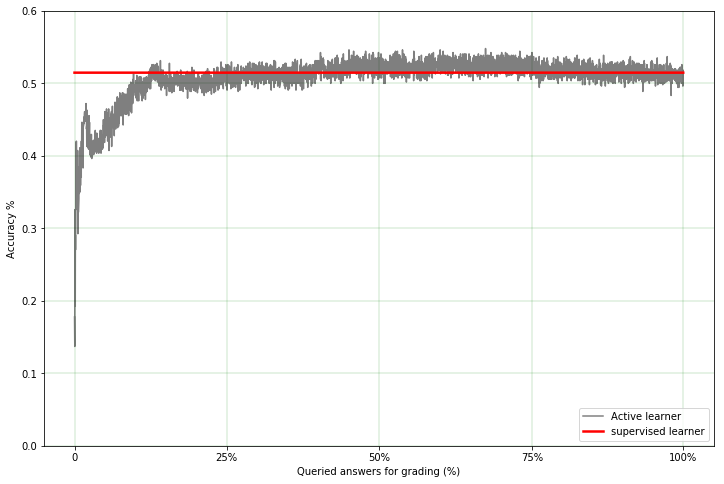

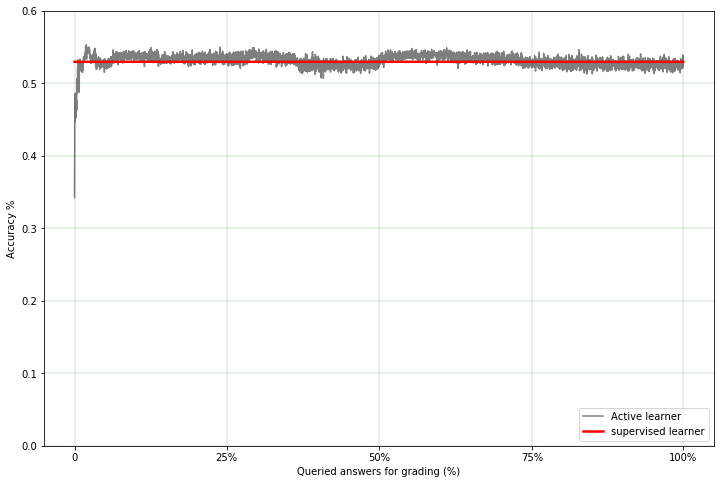

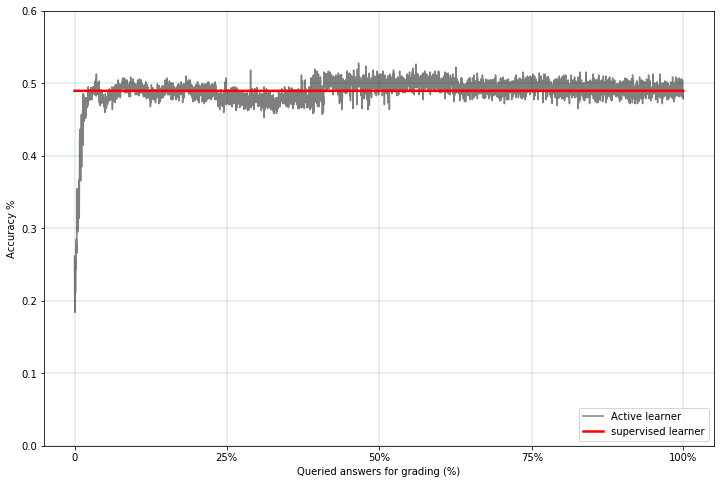

In [11]:
title = ["Unseen_Answers","Unseen_Questions","Unseen_Domain"]
## plotting
for i in range(3):
    fig = plt.figure(figsize=(12,8))
    plt.plot(dict_accuracy_al[i][0], label = "Active learner" , alpha=0.5,color = 'k')
    plt.plot([dict_accuracy_sl[i][0] for _ in range(len(dict_accuracy_al[i][0]))],linewidth=2.5,color="r",label = "supervised learner")
    plt.xlabel("Queried answers for grading (%)")
    plt.ylabel("Accuracy %")
    # plt.title(model_title[i])
    plt.grid(color='g', linestyle='-', linewidth=0.2)
    plt.ylim(0,0.6)
    plt.xticks([0,int(len(dict_accuracy_al[0][0])/4),int(len(dict_accuracy_al[0][0])/2),\
           int(len(dict_accuracy_al[0][0])/1.33),int(len(dict_accuracy_al[0][0]))],['0','25%','50%','75%','100%'])
#     plt.xticklabels(['0','20%','40%','60%','80%'])
    # plt.legend(bbox_to_anchor=(2.10, 0.65),prop = {'size':14})
    plt.legend(loc = "lower right")
    plt.show()
    fig.savefig("../Plotting/images/{}".format(title[i]))
    

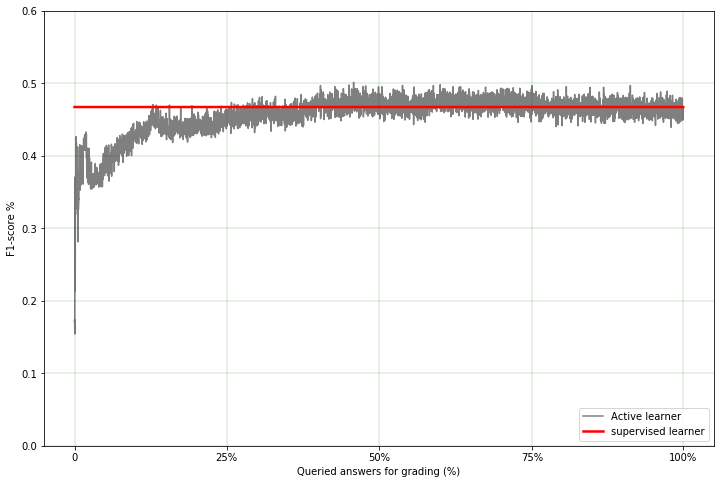

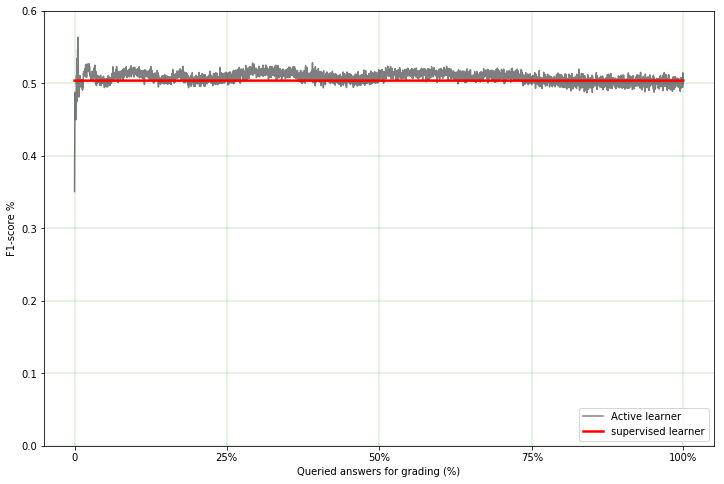

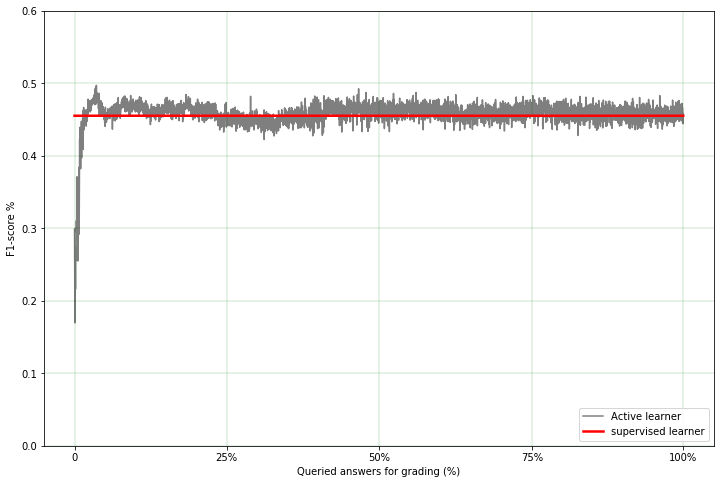

In [12]:
title = ["Unseen_Answers","Unseen_Questions","Unseen_Domain"]
## plotting
for i in range(3):
    fig = plt.figure(figsize=(12,8))
    plt.plot(f1_score_list[i][0], label = "Active learner" , alpha=0.5,color = 'k')
    plt.plot([dict_f1score_sl[i][0] for _ in range(len(f1_score_list[i][0]))],linewidth=2.5,color="r",label = "supervised learner")
    plt.xlabel("Queried answers for grading (%)")
    plt.ylabel("F1-score %")
    # plt.title(model_title[i])
    plt.grid(color='g', linestyle='-', linewidth=0.2)
    plt.ylim(0,0.6)
    plt.xticks([0,int(len(f1_score_list[0][0])/4),int(len(f1_score_list[0][0])/2),\
           int(len(f1_score_list[0][0])/1.33),int(len(f1_score_list[0][0]))],['0','25%','50%','75%','100%'])
#     plt.xticklabels(['0','20%','40%','60%','80%'])
    # plt.legend(bbox_to_anchor=(2.10, 0.65),prop = {'size':14})
    plt.legend(loc = "lower right")
    plt.show()
    fig.savefig("../Plotting/images/{}_f1".format(title[i]))